In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
import pickle
import skimage
from imaris_ims_file_reader.ims import ims
import h5py
import tables
np.random.seed(42) # for reproducibility

In [2]:
sys.path.insert(1, 'aics-shparam')
from aicsshparam import shtools, shparam

# example

In [3]:
# Function that returns binary images containing one of the three
# shapes: cubes, spheres octahedrons of random sizes.
def get_random_3d_shape():
    idx = np.random.choice([0, 1, 2], 1)[0]
    element = [ball, cube, octahedron][idx]
    label = ['ball', 'cube', 'octahedron'][idx]
    img = element(10 + int(10 * np.random.rand()))
    img = np.pad(img, ((1, 1), (1, 1), (1, 1)))
    img = img.reshape(1, *img.shape)
    # Rotate shapes to increase dataset variability.
    img = shtools.rotate_image_2d(
        image=img,
        angle=360 * np.random.rand()
    ).squeeze()
    return label, img

# Compute spherical harmonics coefficients of shape and store them
# in a pandas dataframe.
df_coeffs = pd.DataFrame([])
for i in range(30):
    # Get a random shape
    label, img = get_random_3d_shape()
    # Parameterize with L=4, which corresponds to50 coefficients
    # in total
    (coeffs, _), _ = shparam.get_shcoeffs(image=img, lmax=4)
    coeffs.update({'label': [label]})
    coeffs = pd.DataFrame.from_dict(coeffs)
    df_coeffs = pd.concat([df_coeffs,coeffs], ignore_index=True)

# Vizualize the resulting dataframe
with pd.option_context('display.max_rows', 5, 'display.max_columns', 5):
    display(df_coeffs)

NameError: name 'ball' is not defined

# progeria cell

In [5]:
tables.file._open_files.close_all()
fn_p = "/Users/amulya/Downloads/Late_progeria_IF_Test_1.ims"
fn_n = "/Users/amulya/Downloads/NP_LMNA_K9me2_Pol2_Well2_40X_F00.ims"
f = ims(fn_n,write=True)
c1 = f[0][0]
c2 = f[0][1]

Opening writeable file: /Users/amulya/Downloads/NP_LMNA_K9me2_Pol2_Well2_40X_F00.ims 



/Users/amulya/anaconda3/envs/segmentation/lib/python3.7/site-packages/imaris_ims_file_reader/ims.py:189: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  self.hf = h5py.File(self.filePathComplete, 'a', swmr=True)


## binary mask

In [6]:
sys.path.insert(1, 'aics-segmentation')
# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from aicssegmentation.core.utils import get_middle_frame, hole_filling, get_3dseed_from_mid_frame
from skimage.morphology import remove_small_objects,  dilation, ball
from skimage.segmentation import watershed

In [7]:
intensity_scaling_param = [4000]
# intensity normalization
struct_img = intensity_normalization(c2, scaling_param=intensity_scaling_param)

intensity norm: min-max norm with upper bound 4000


In [8]:
gaussian_smoothing_sigma = 8
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

0


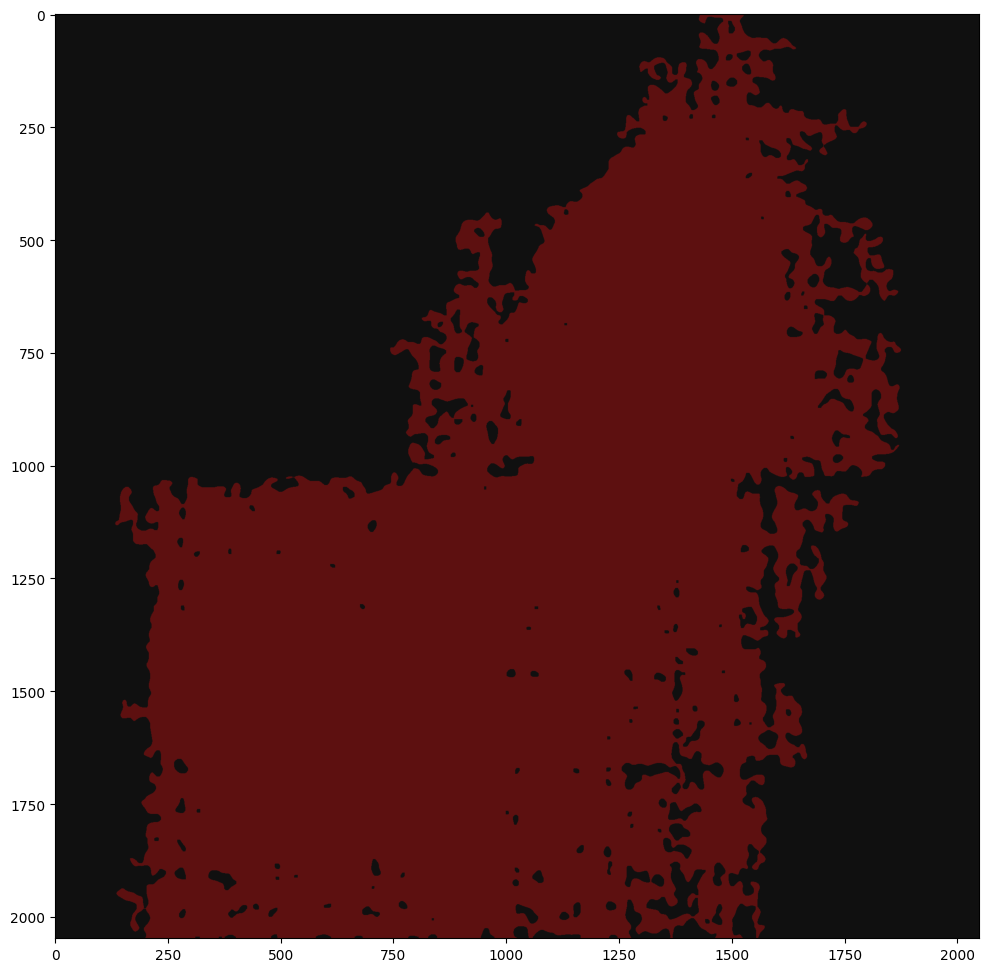

1


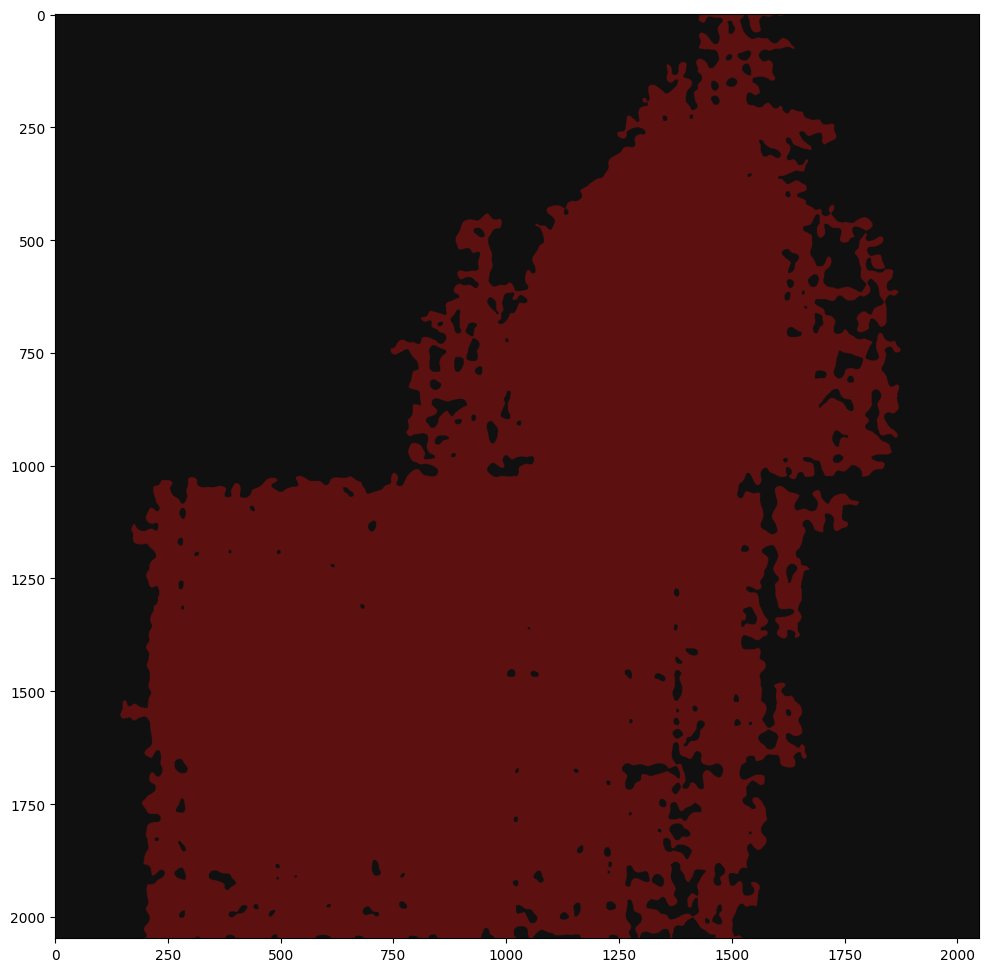

2


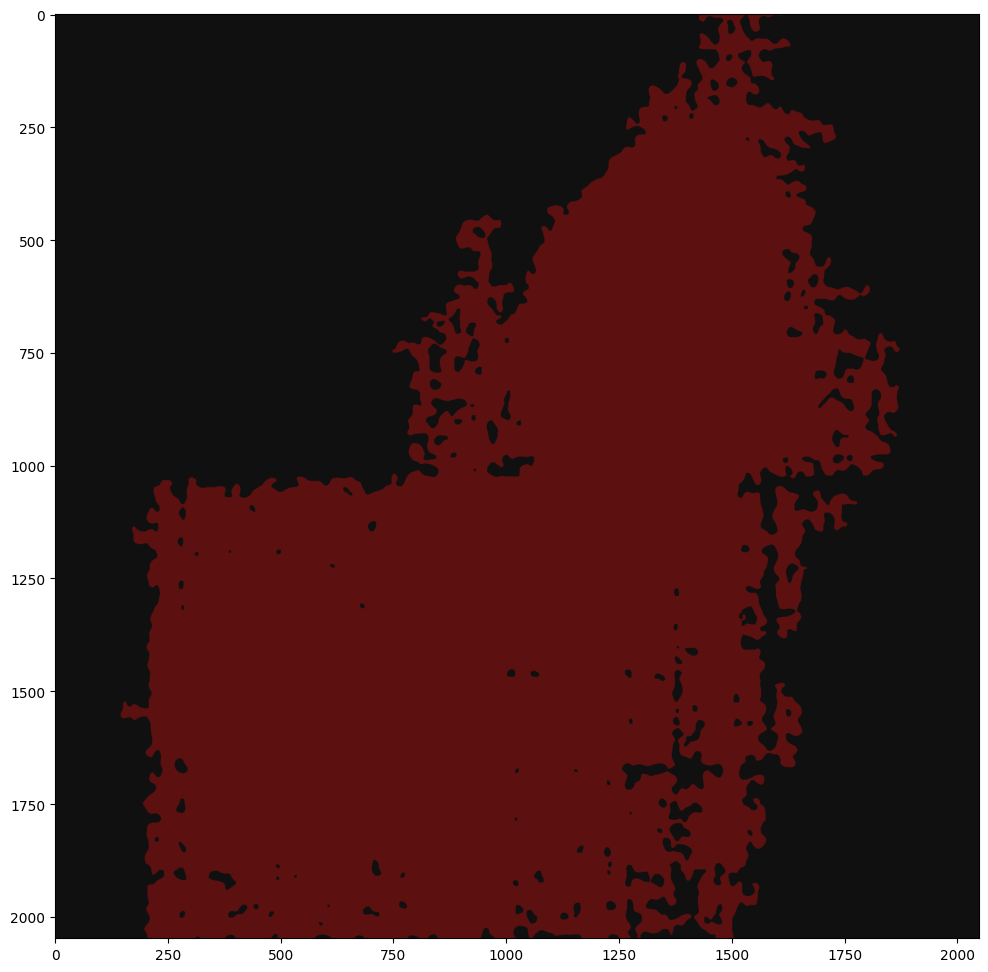

3


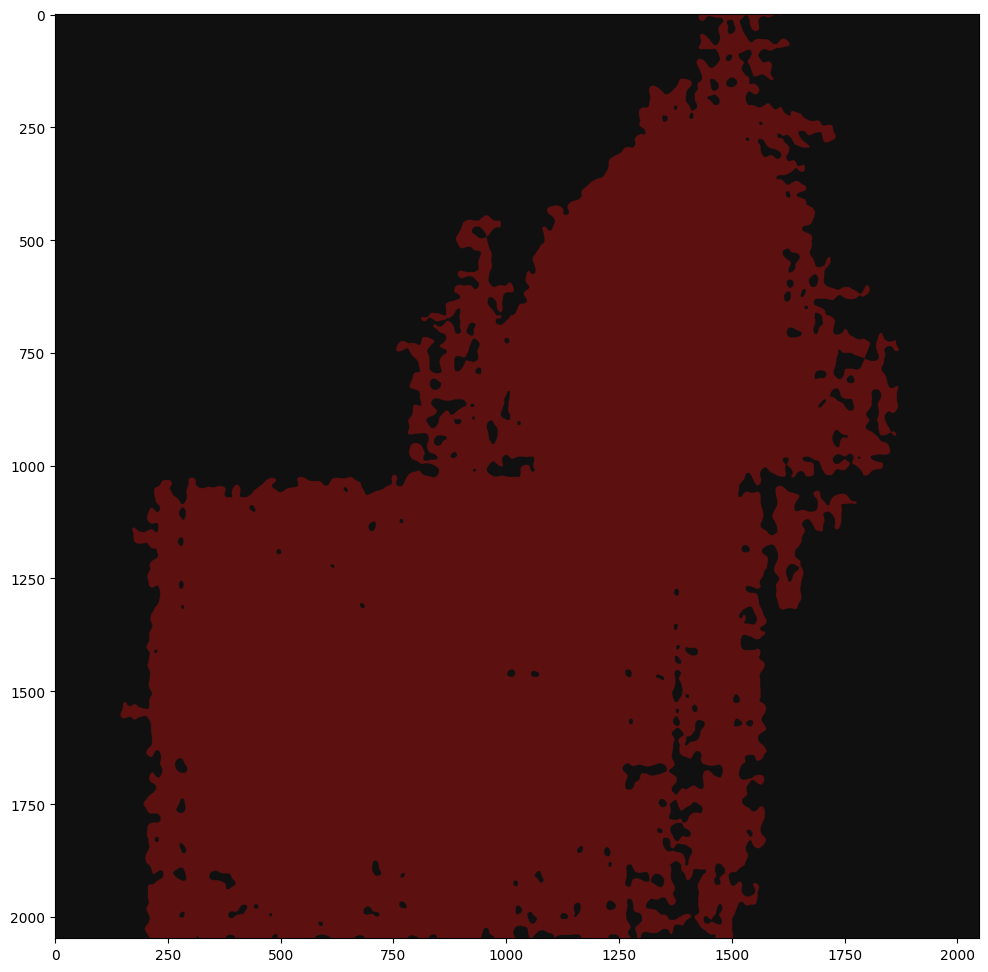

4


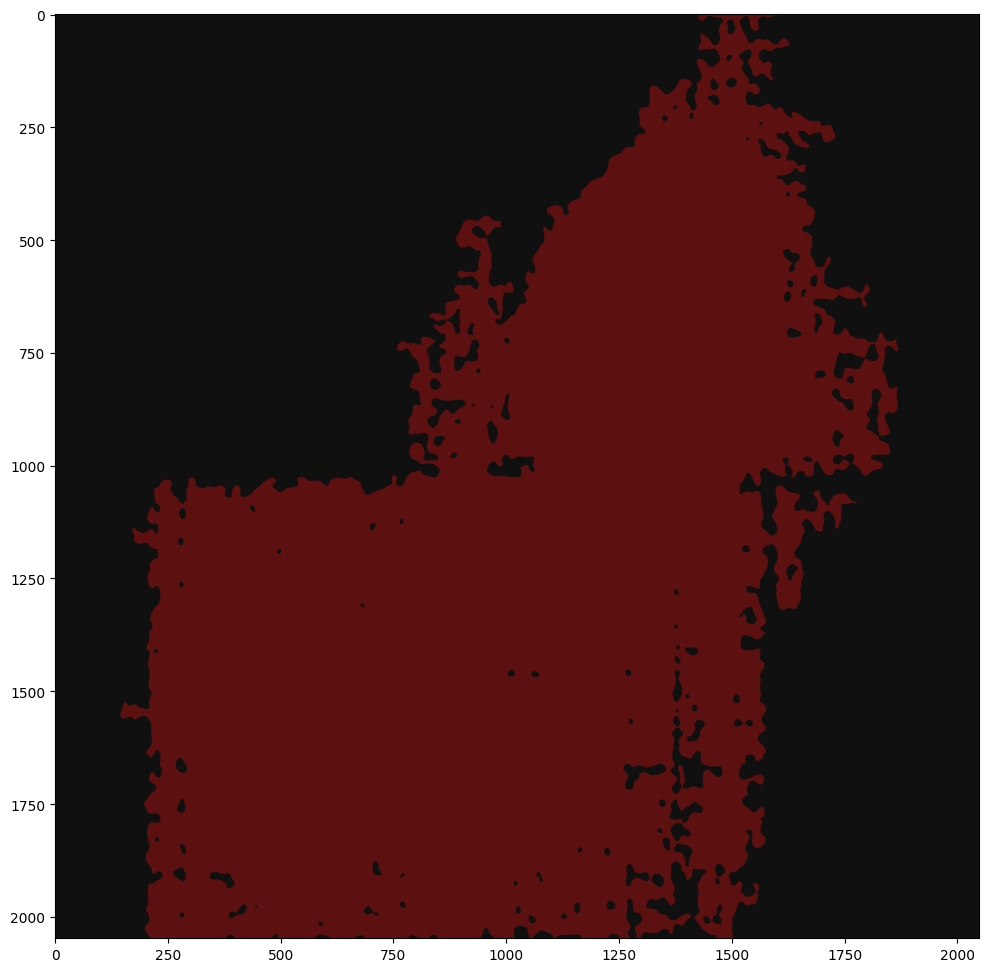

5


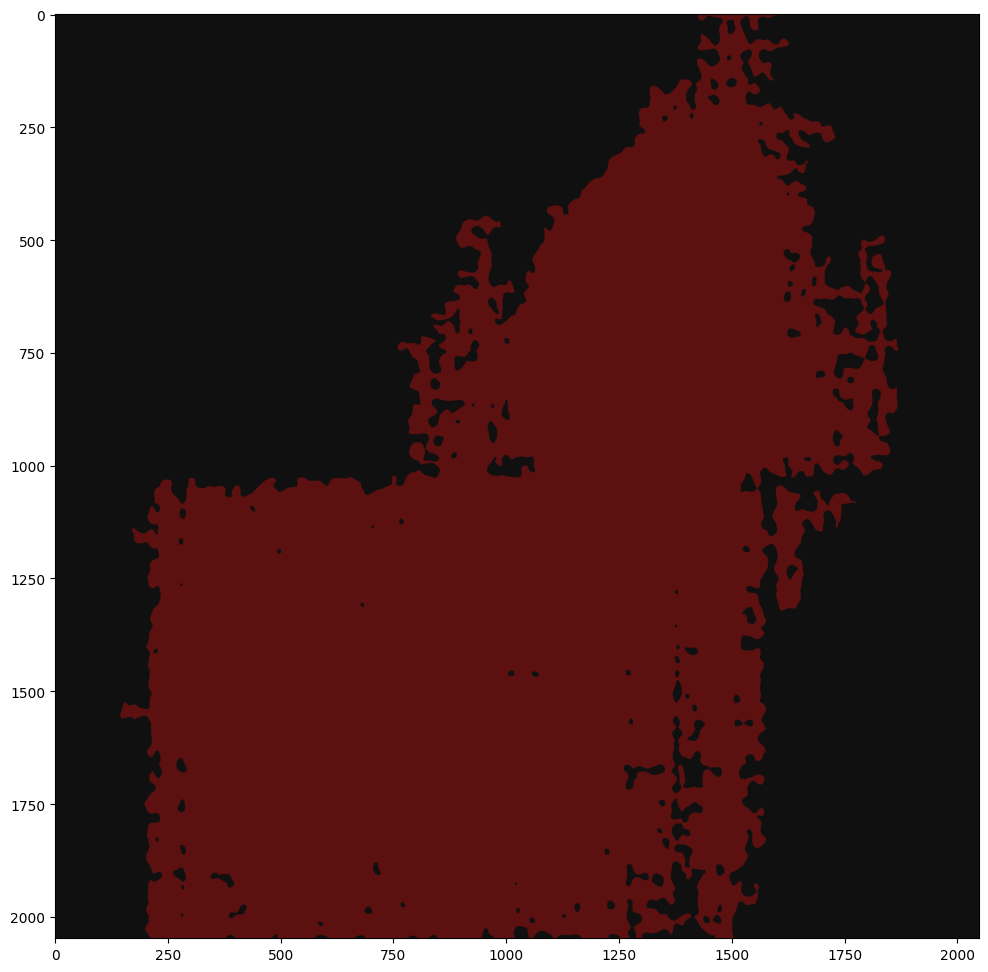

6


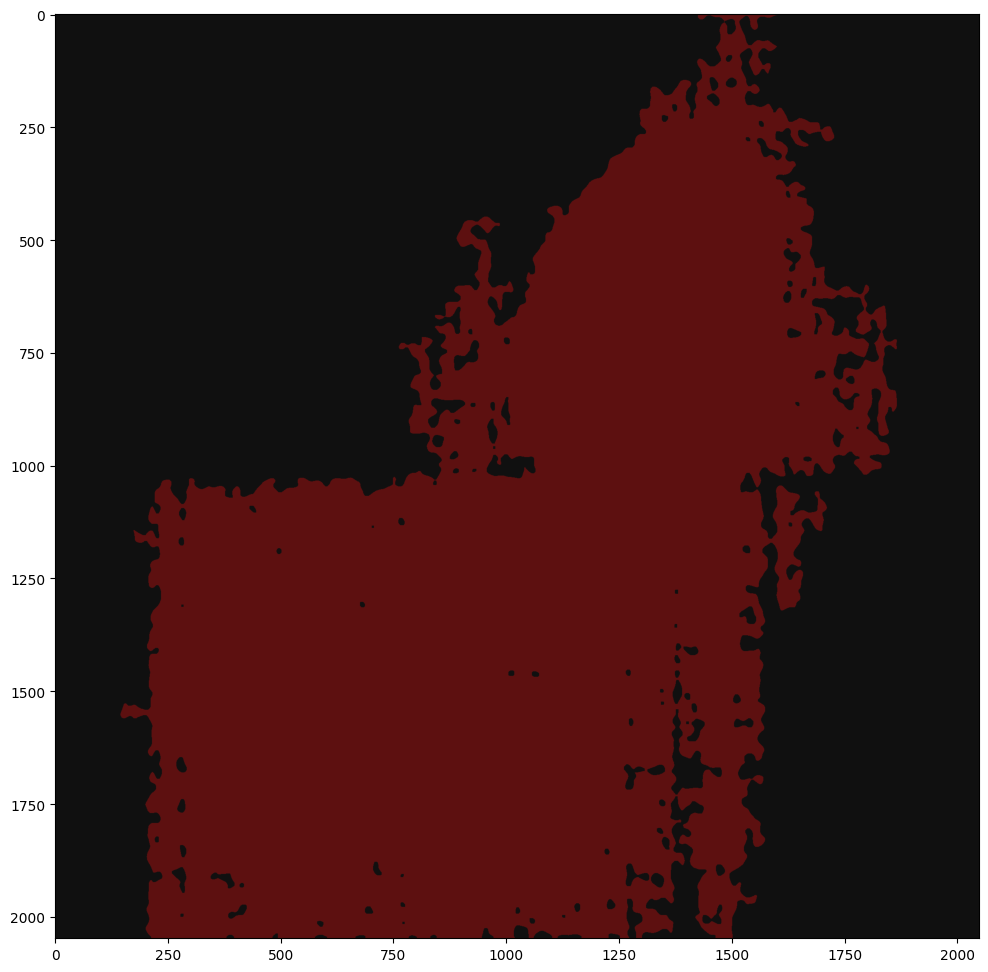

7


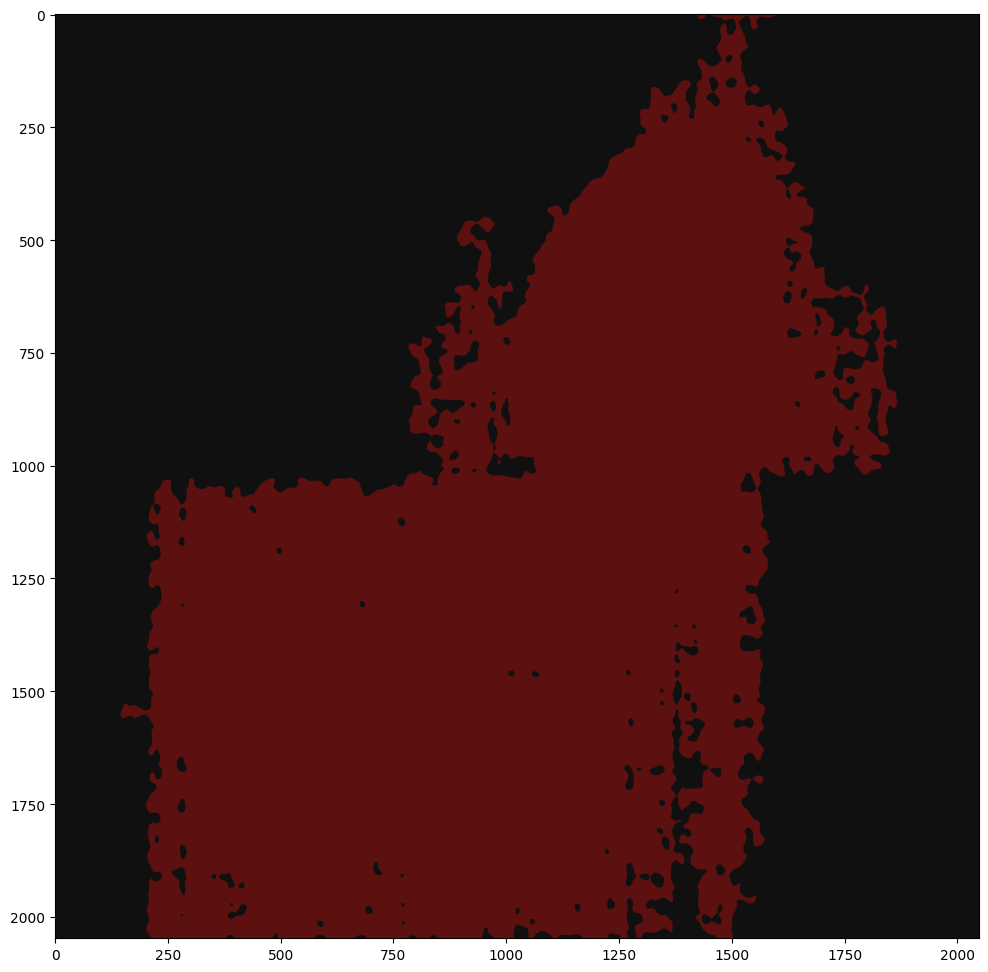

8


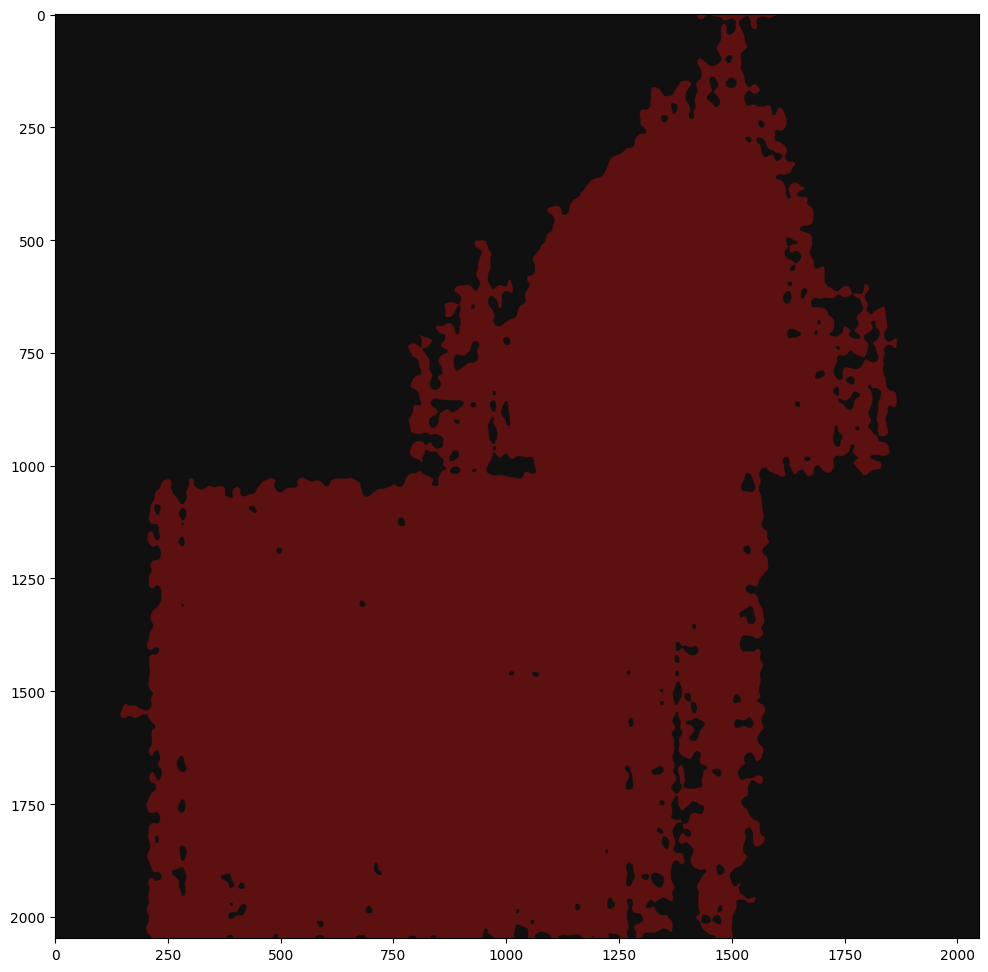

9


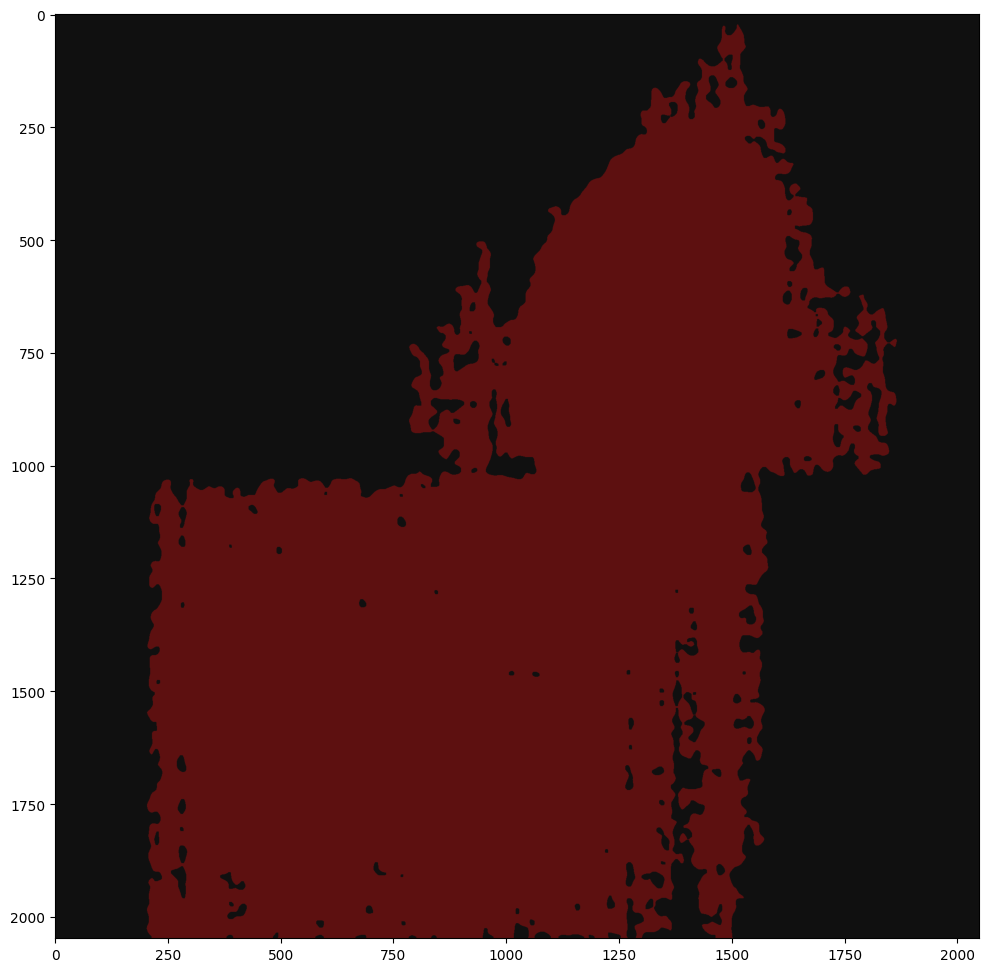

10


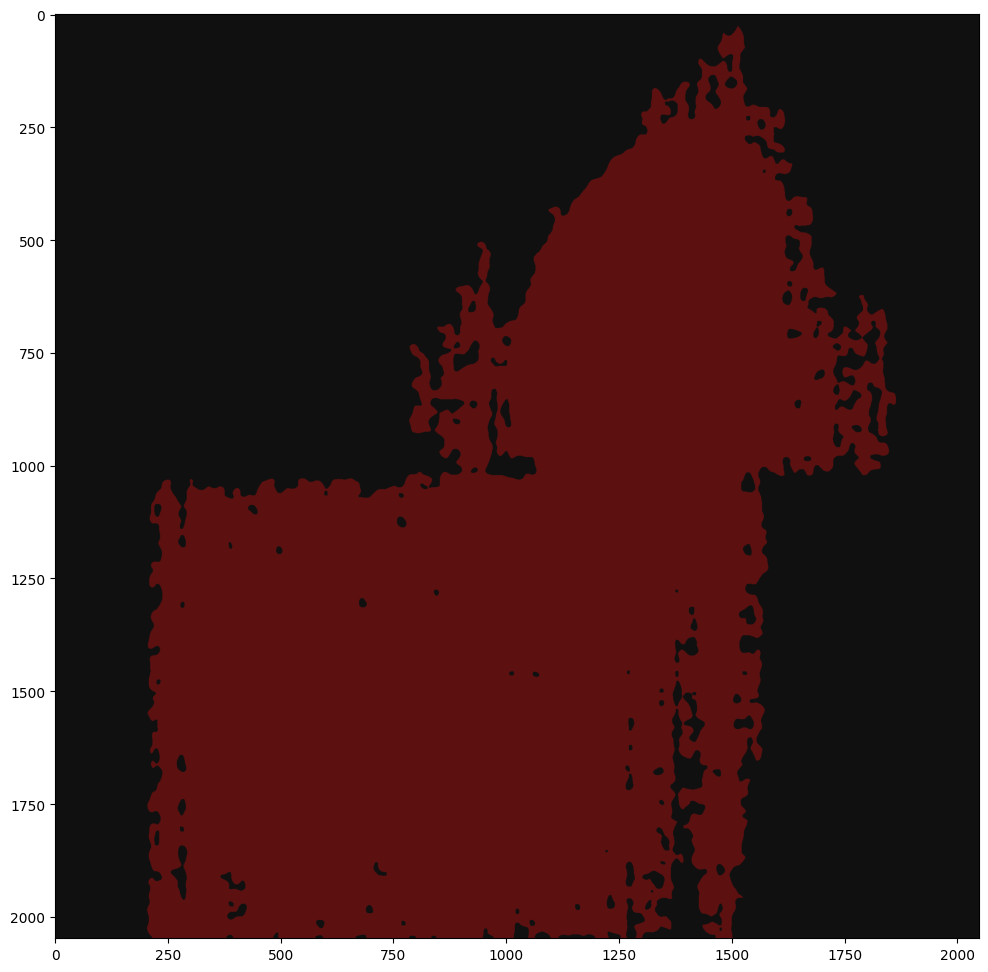

11


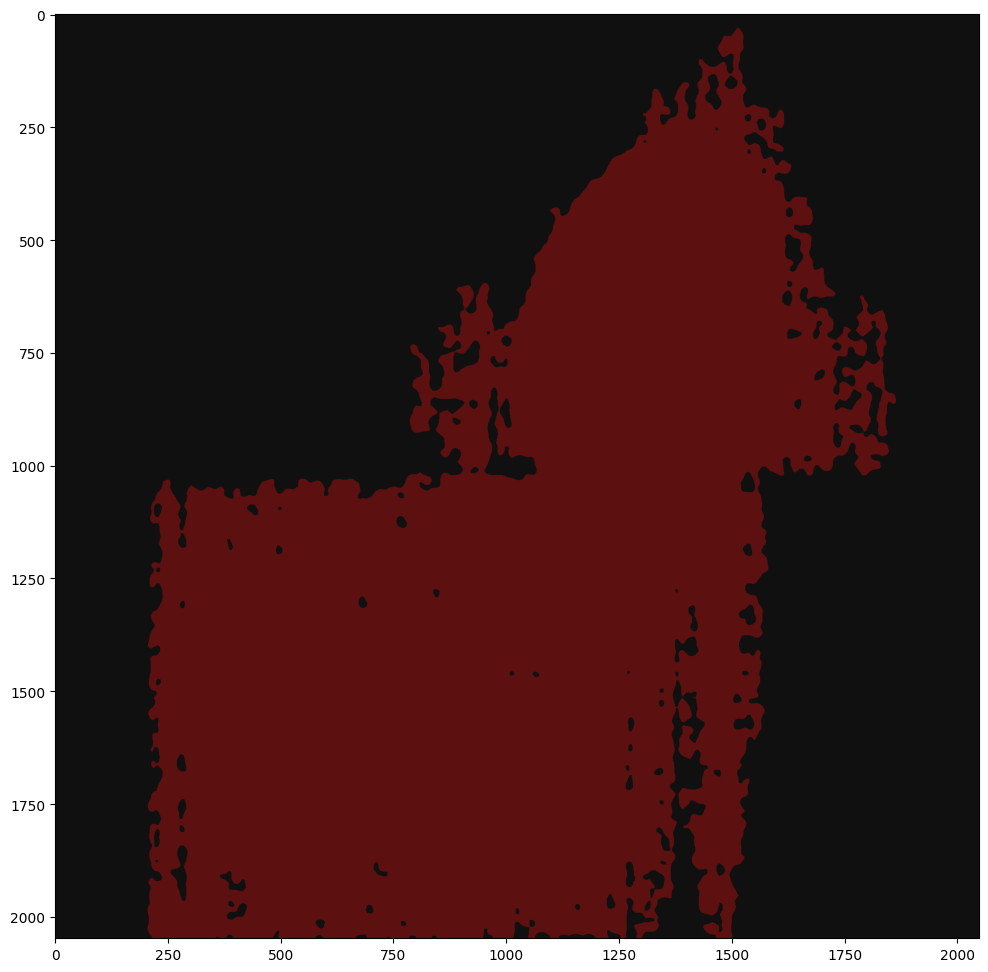

12


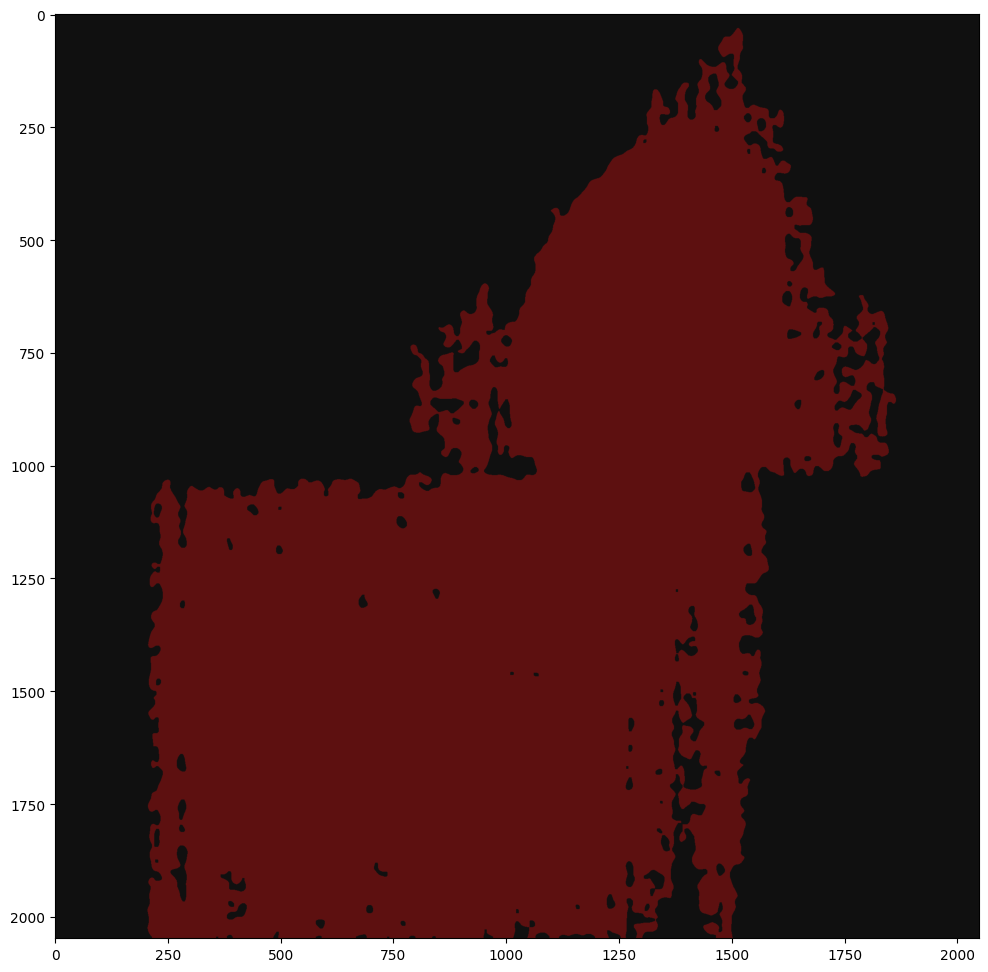

13


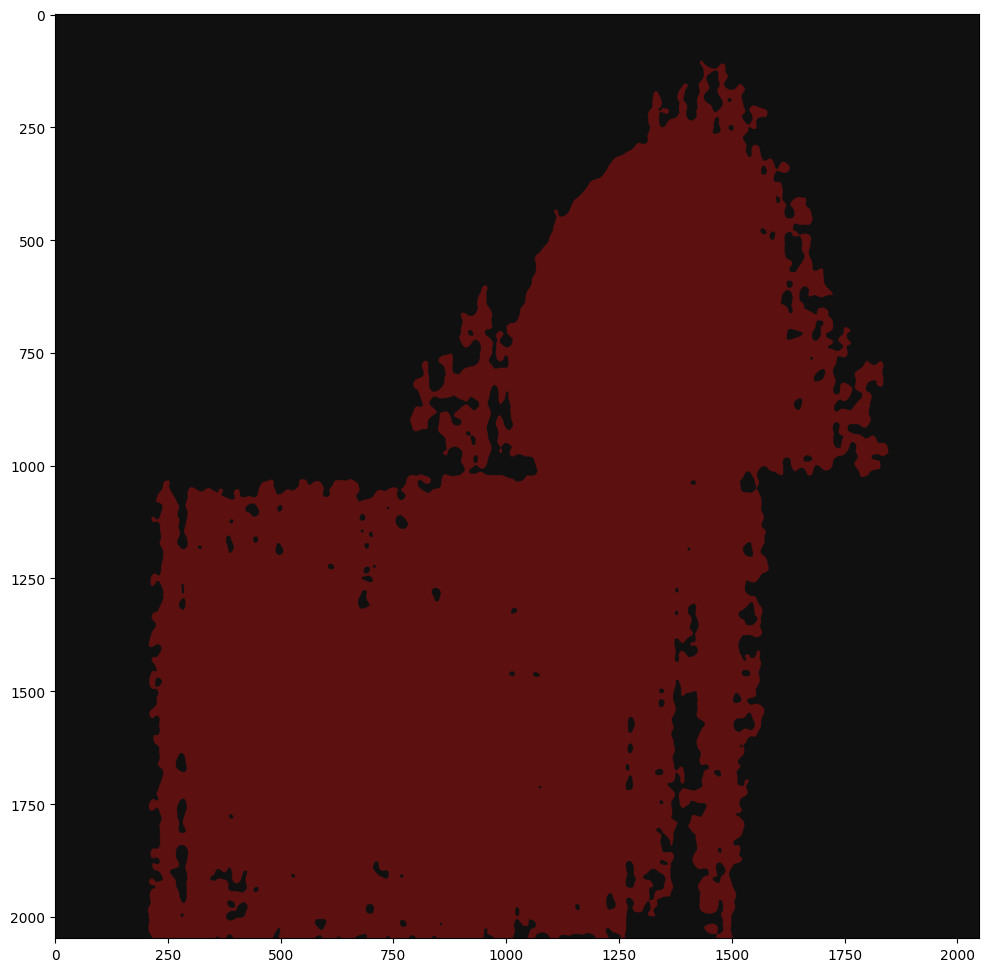

14


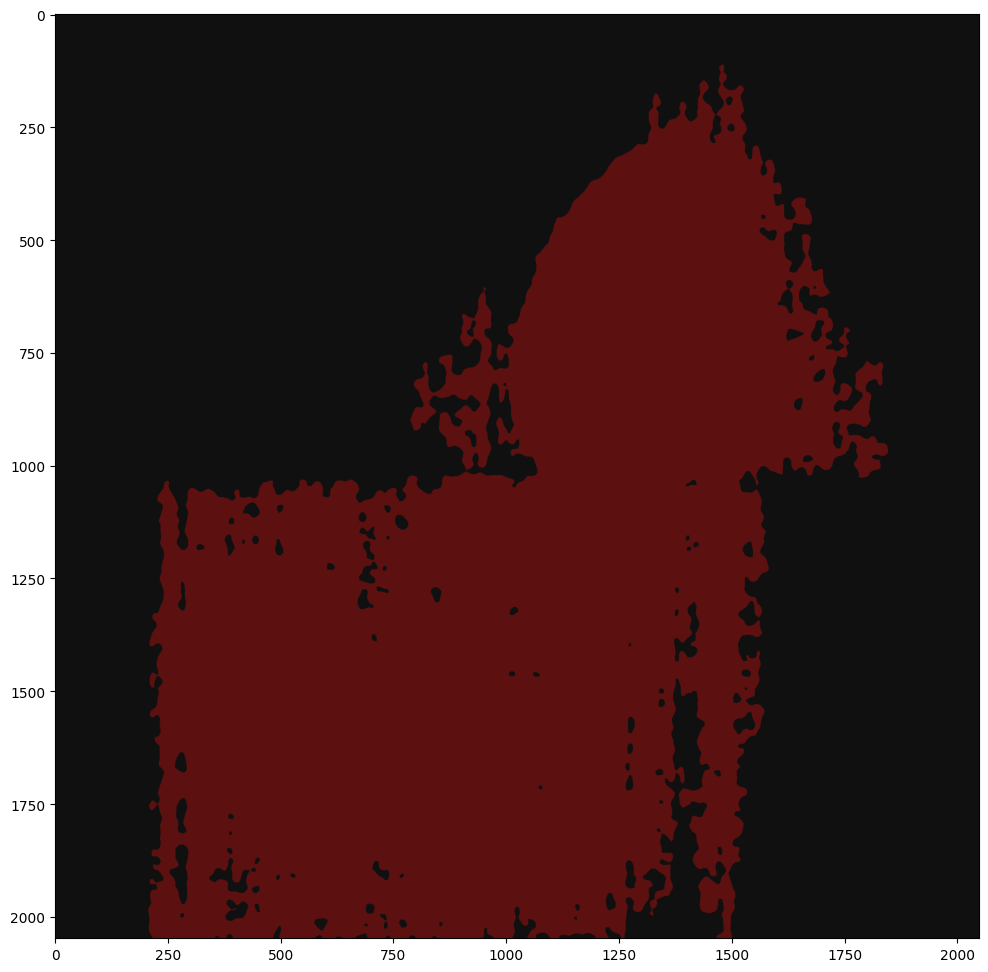

15


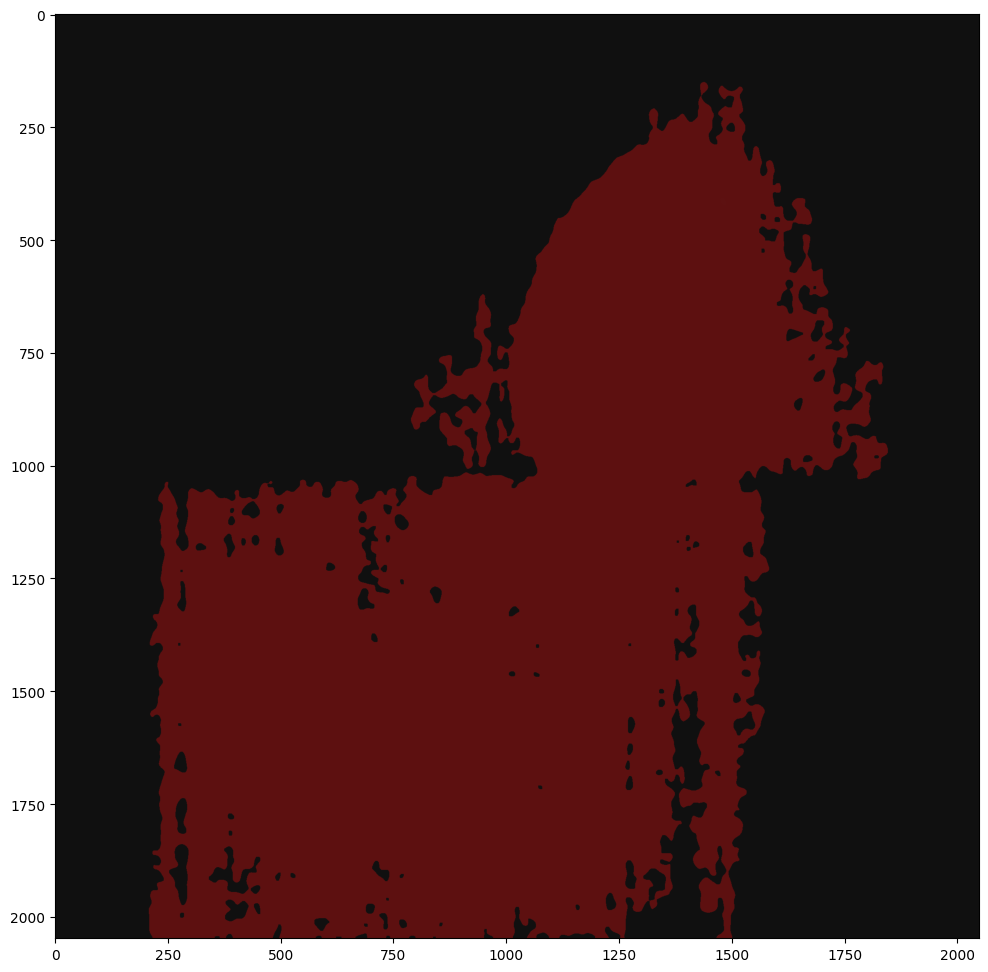

16


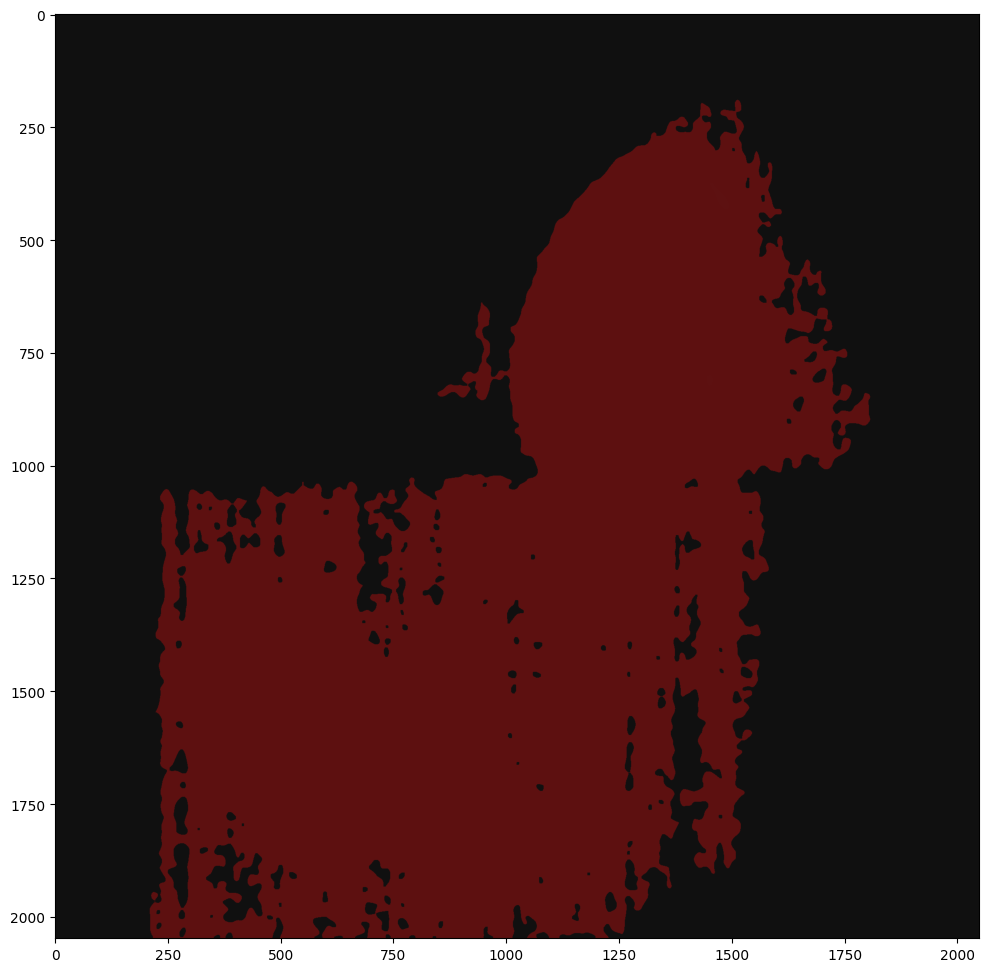

17


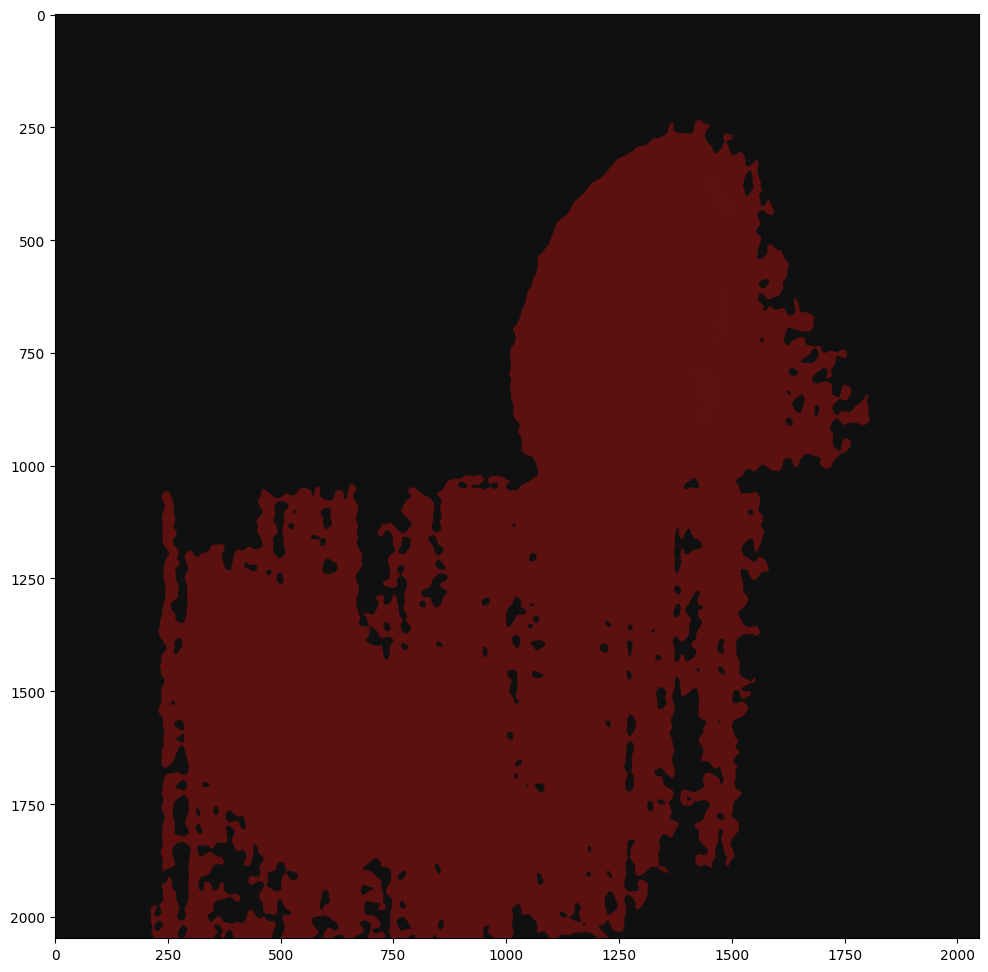

18


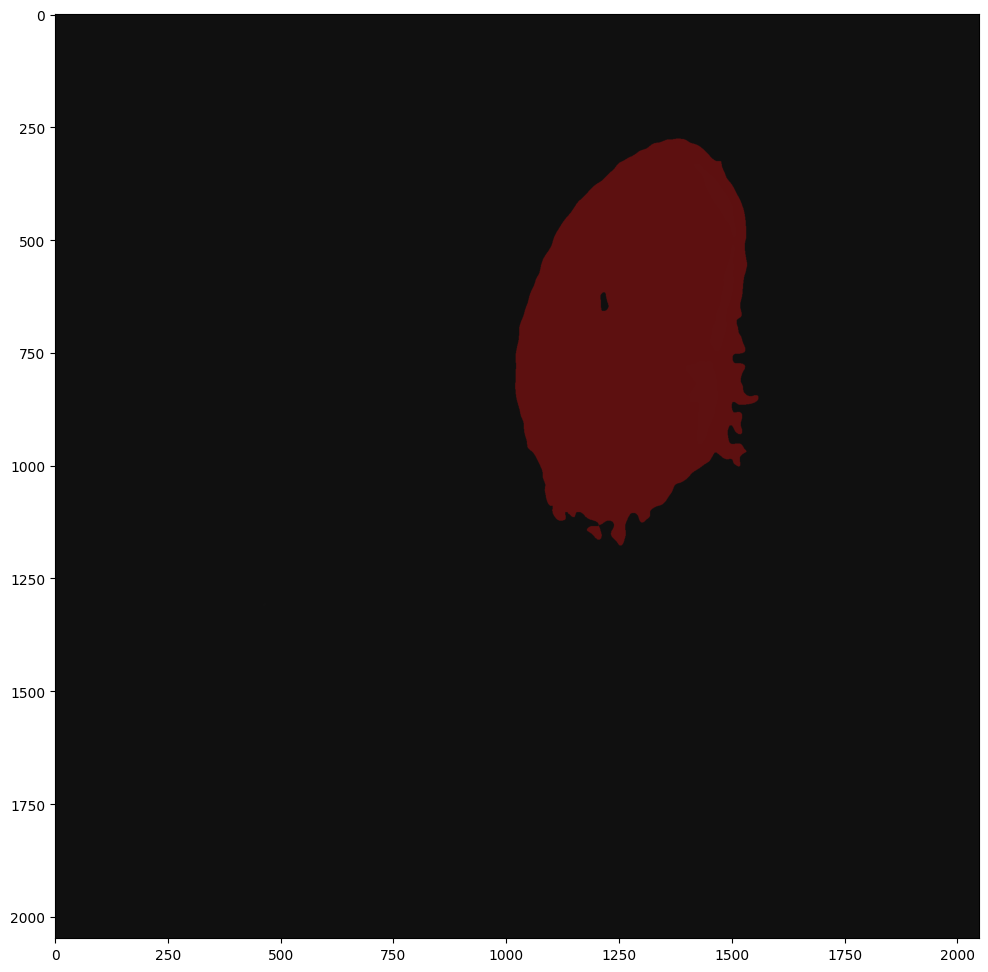

19


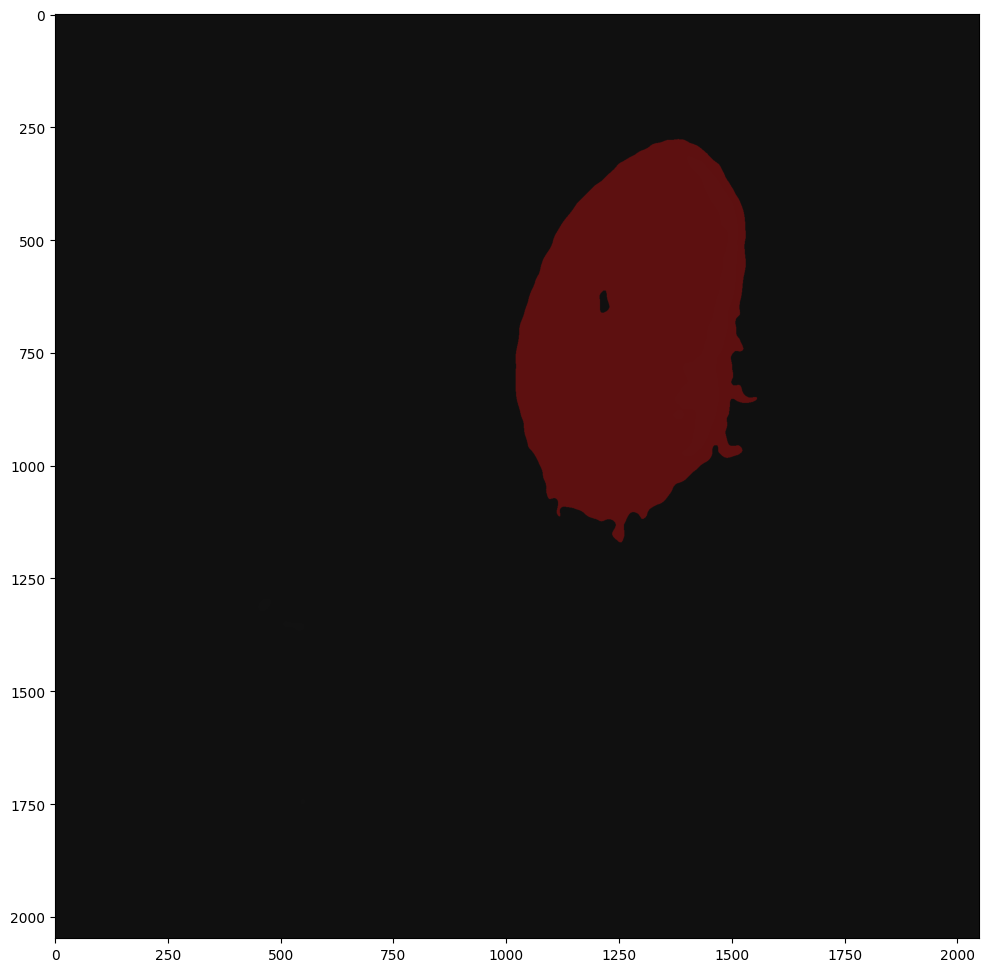

20


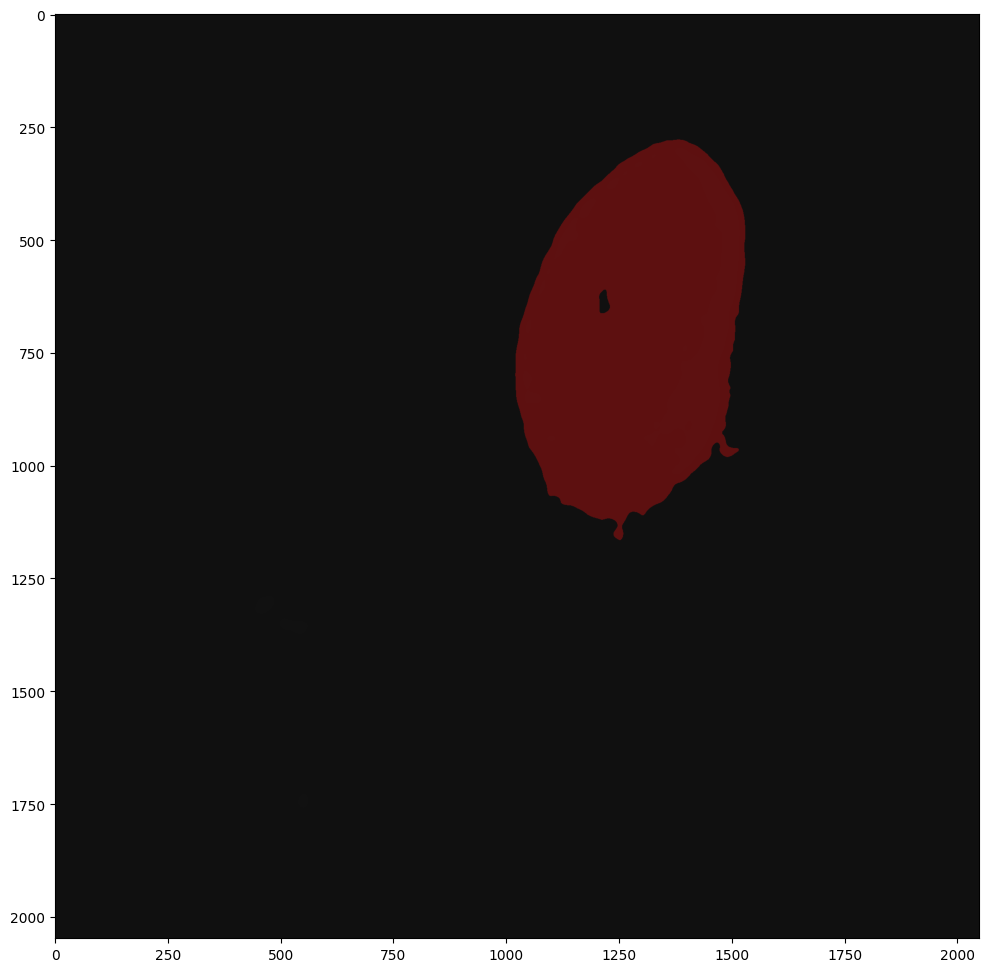

21


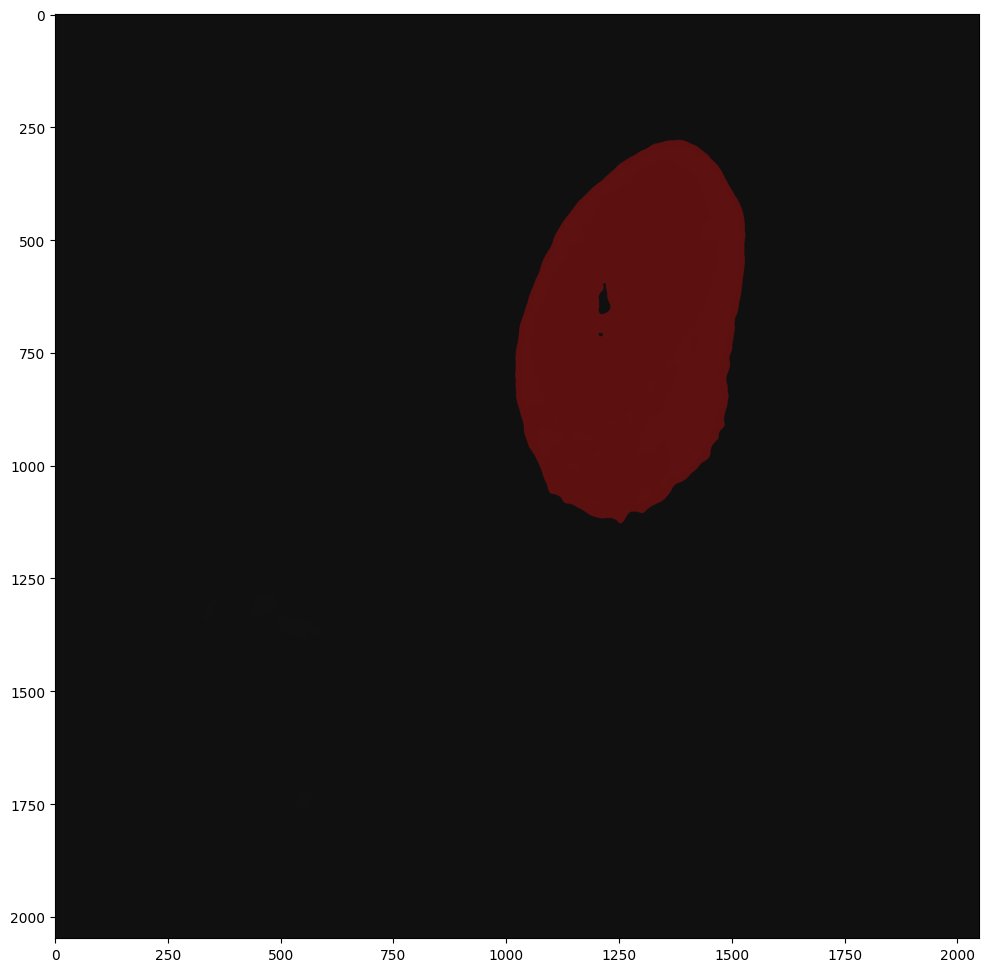

22


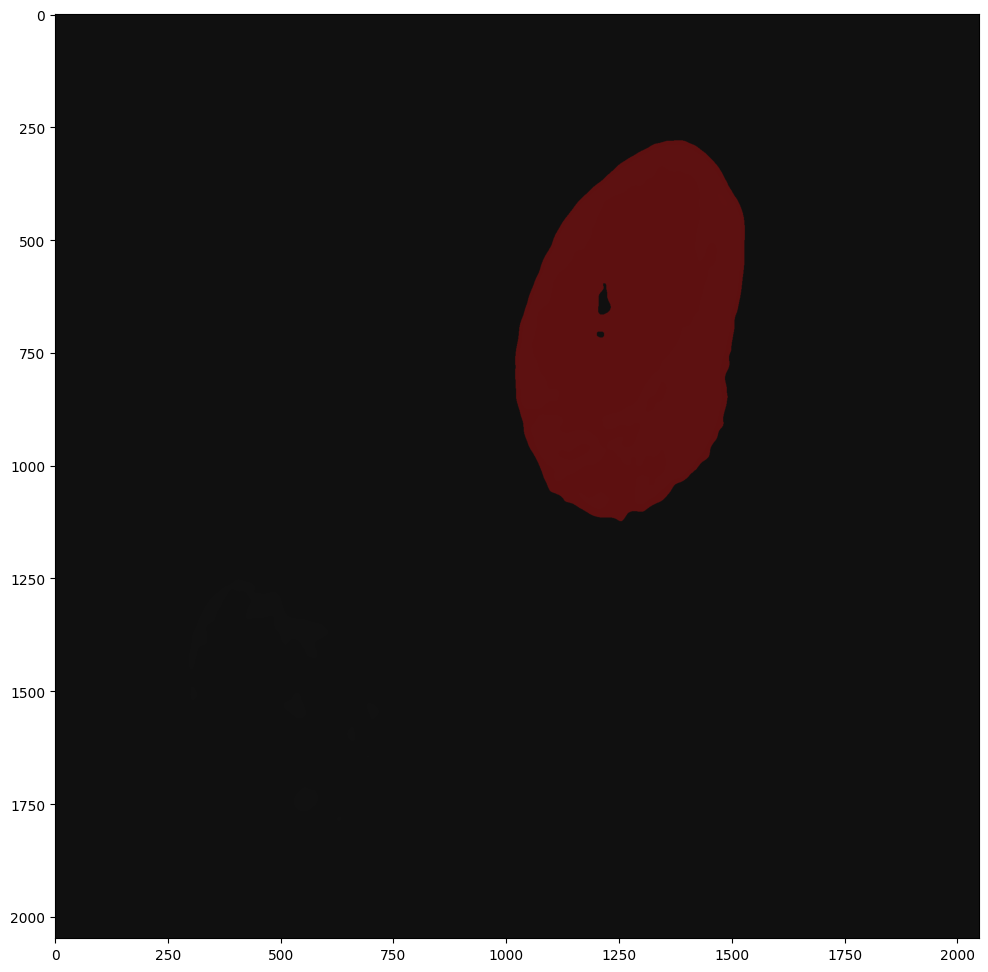

23


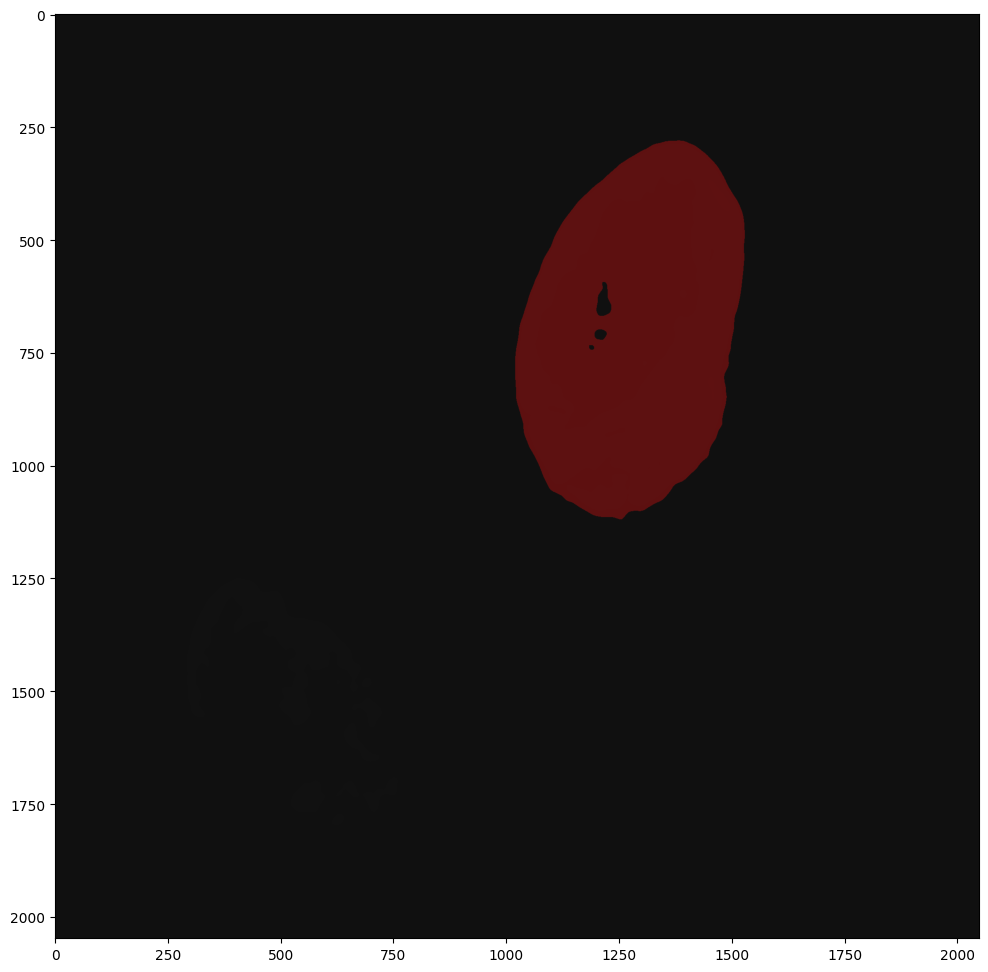

24


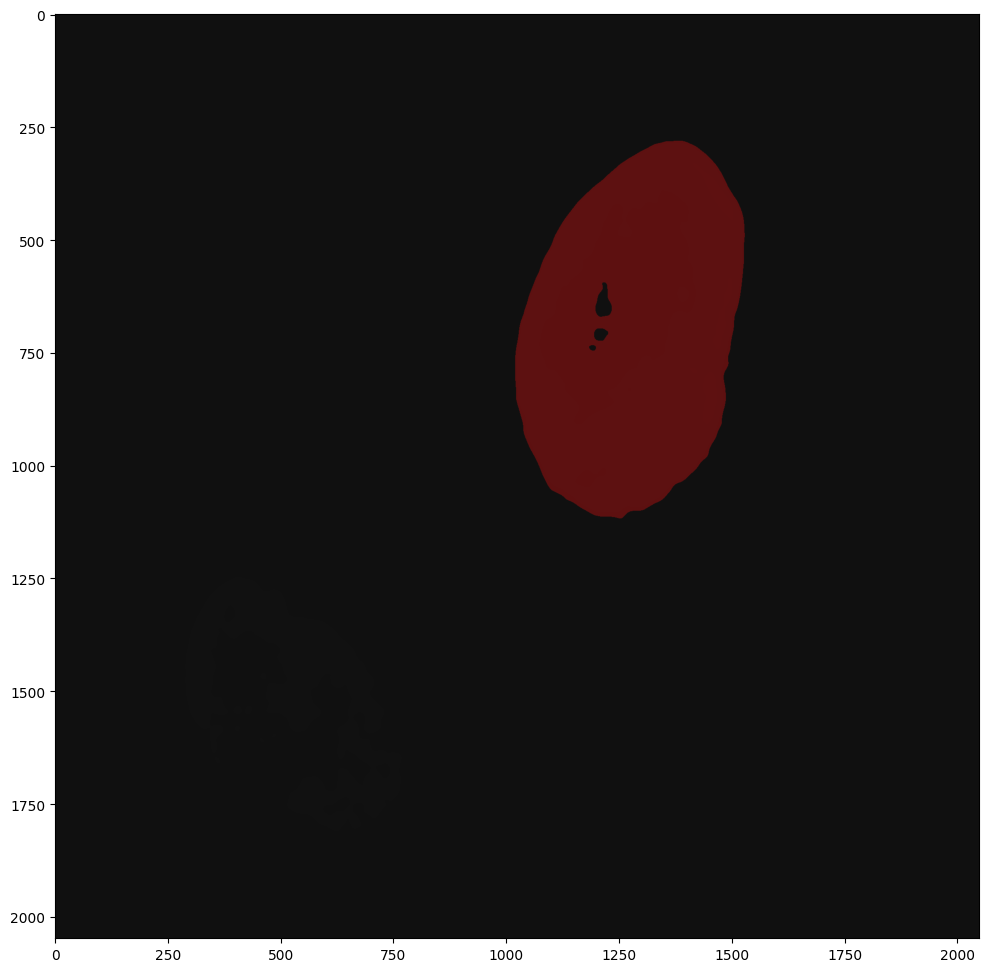

25


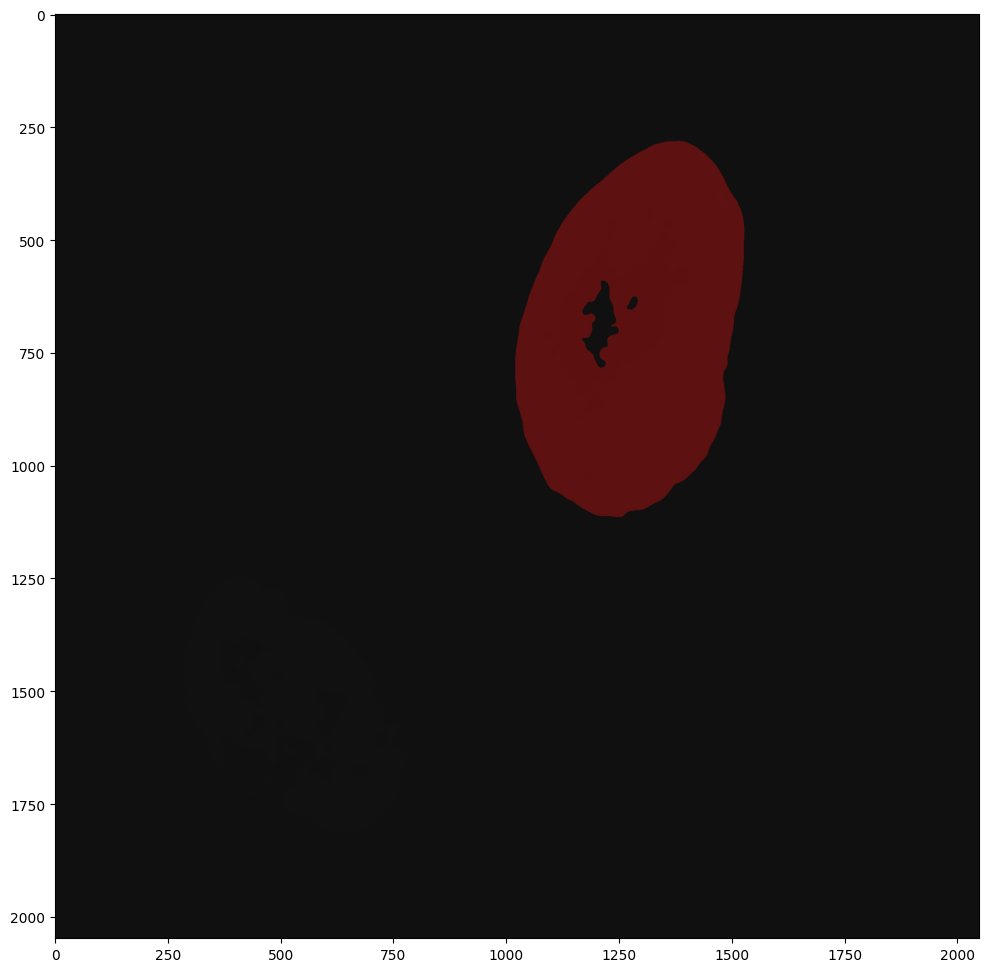

26


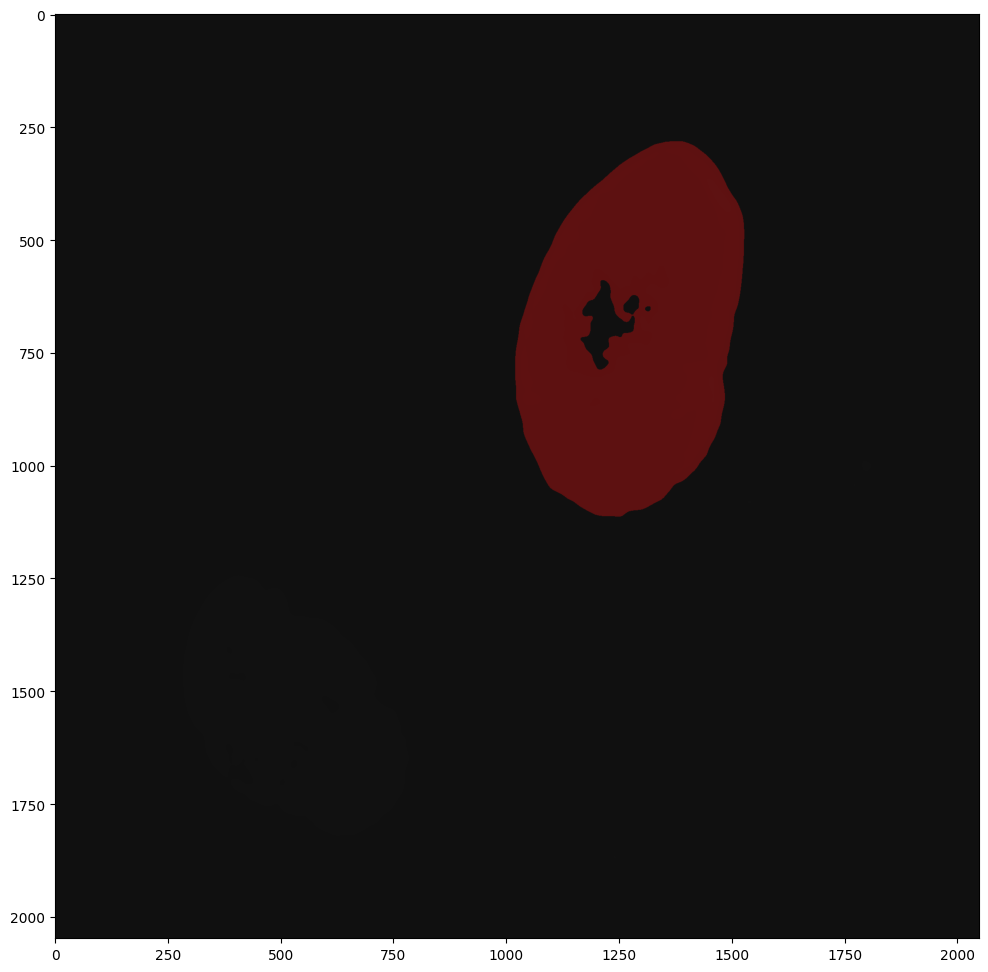

27


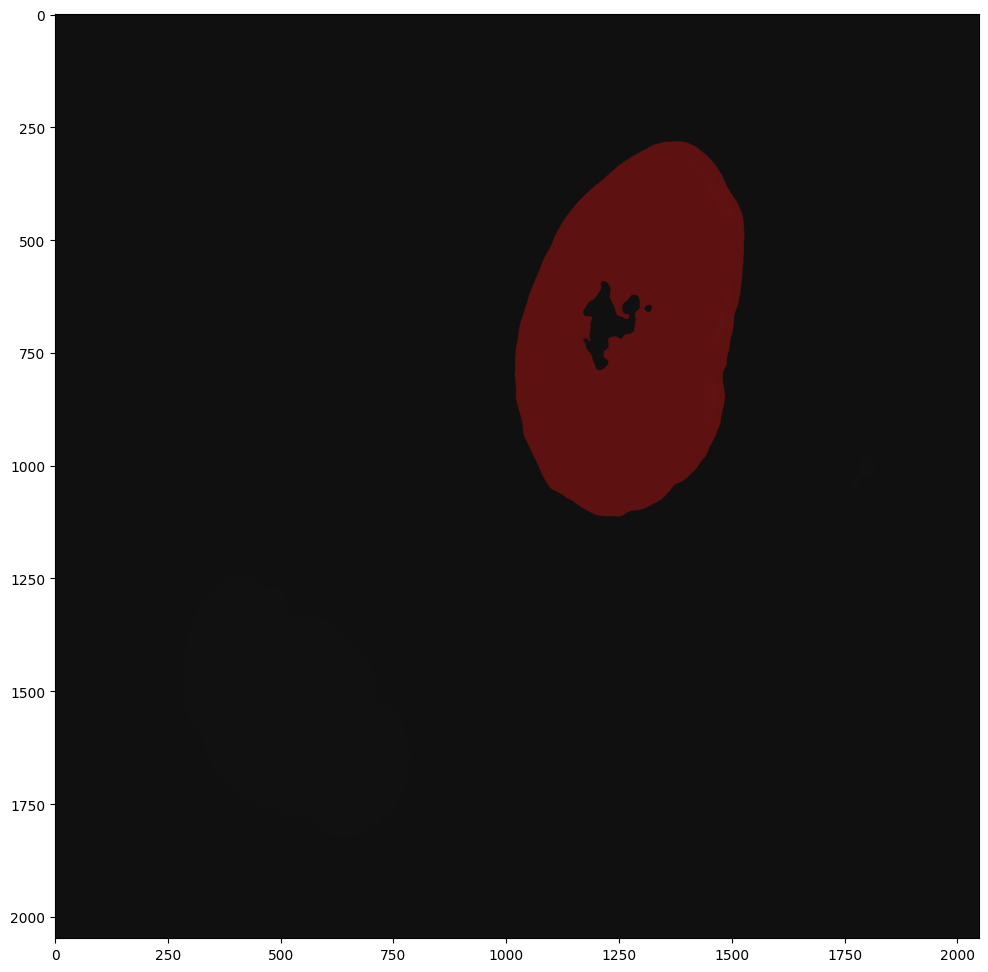

28


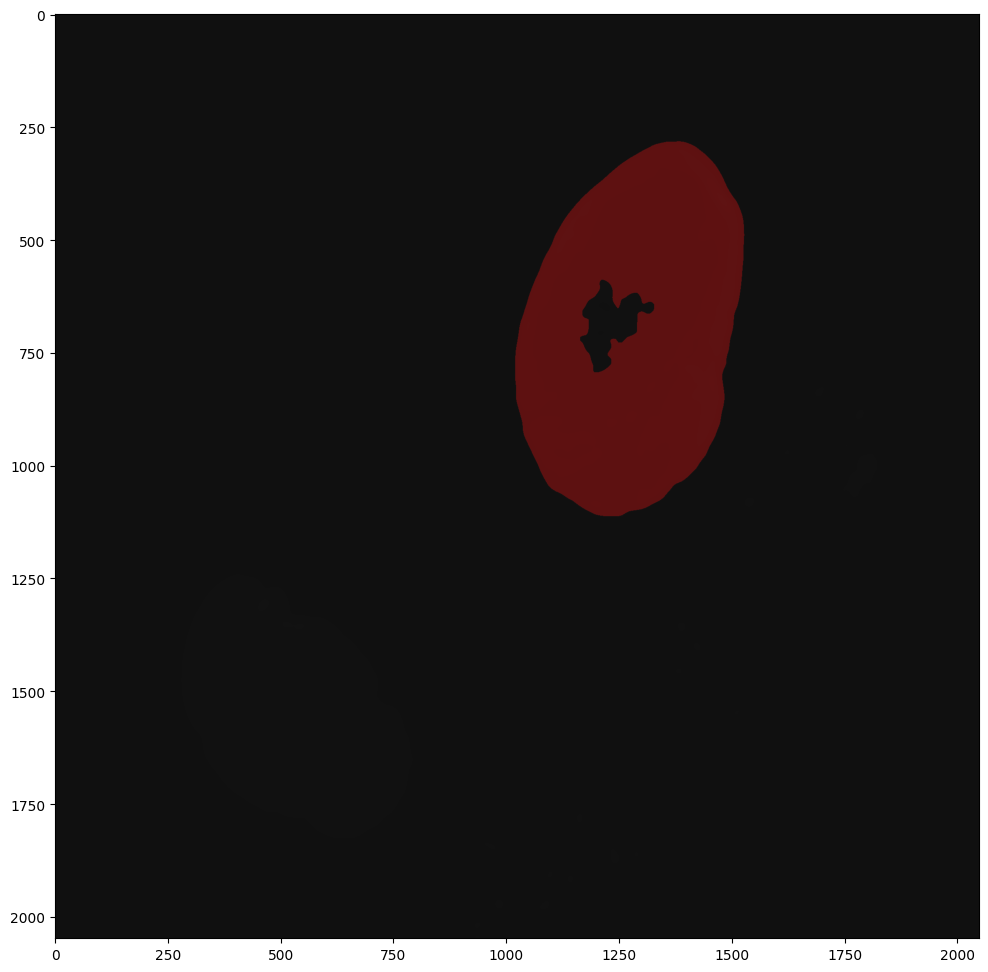

29


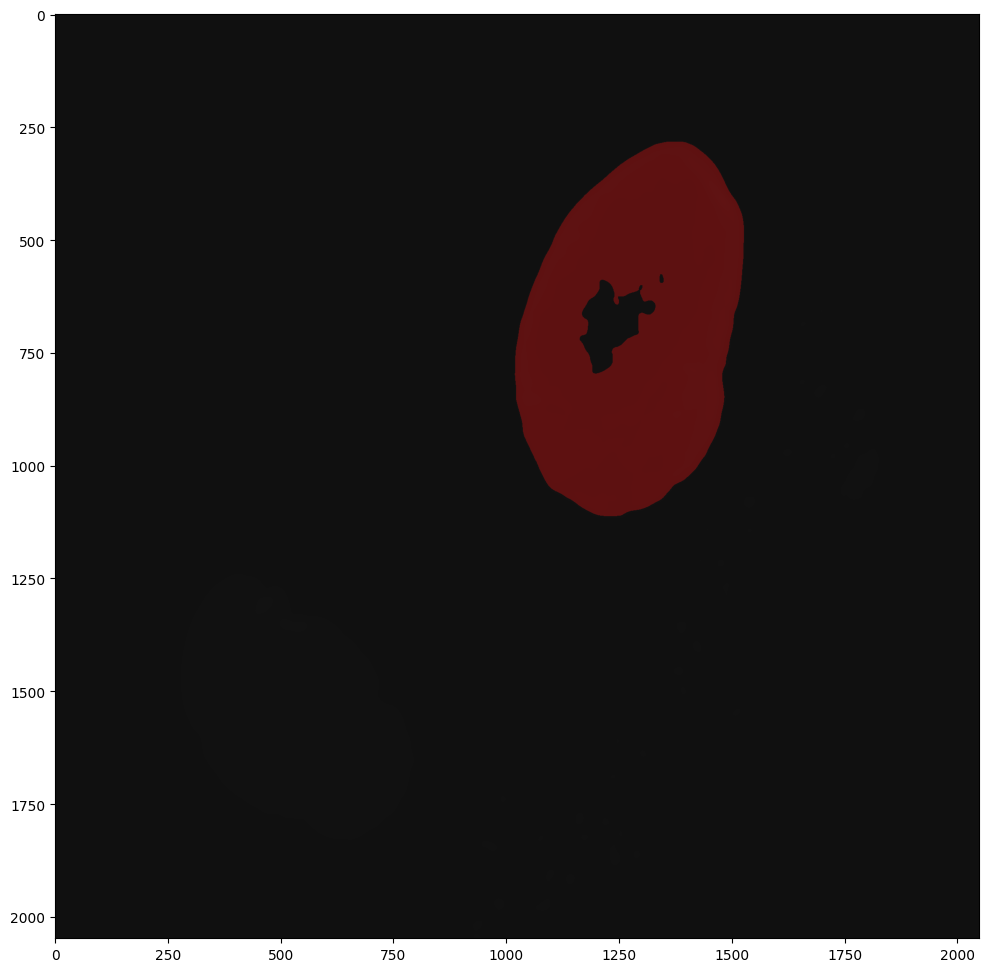

30


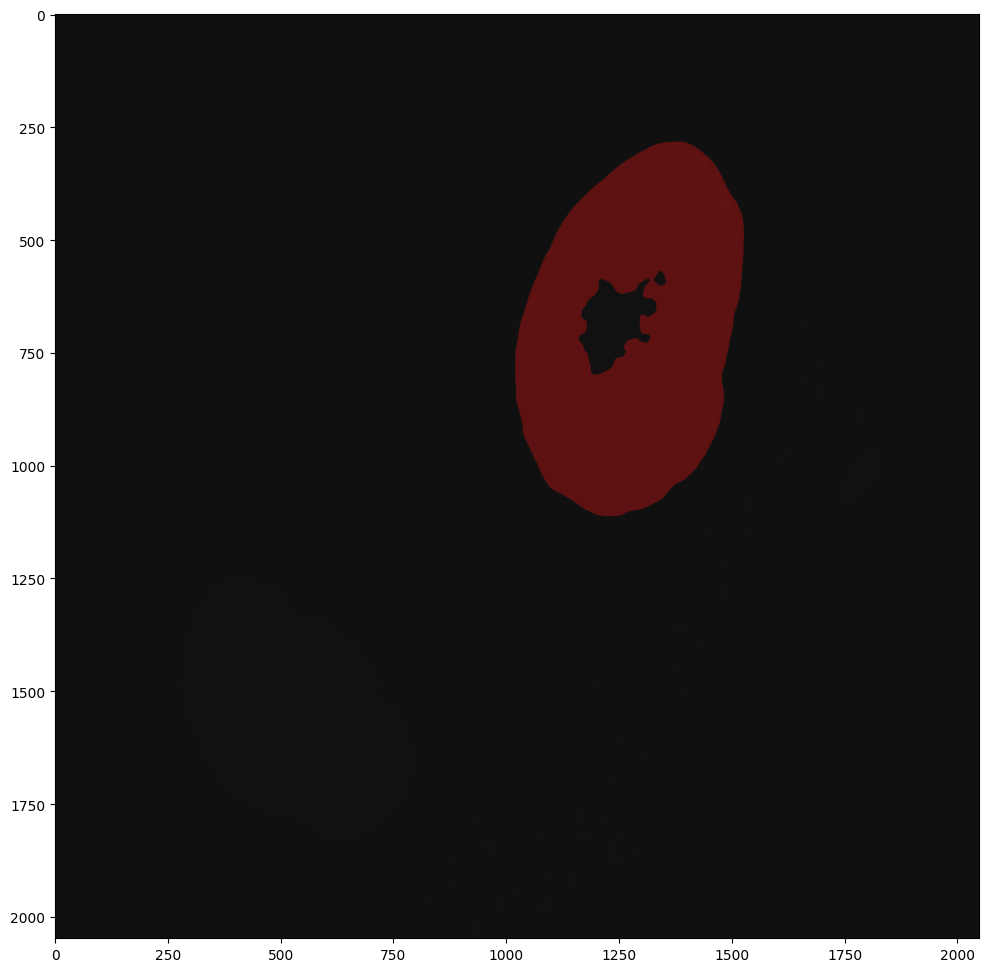

31


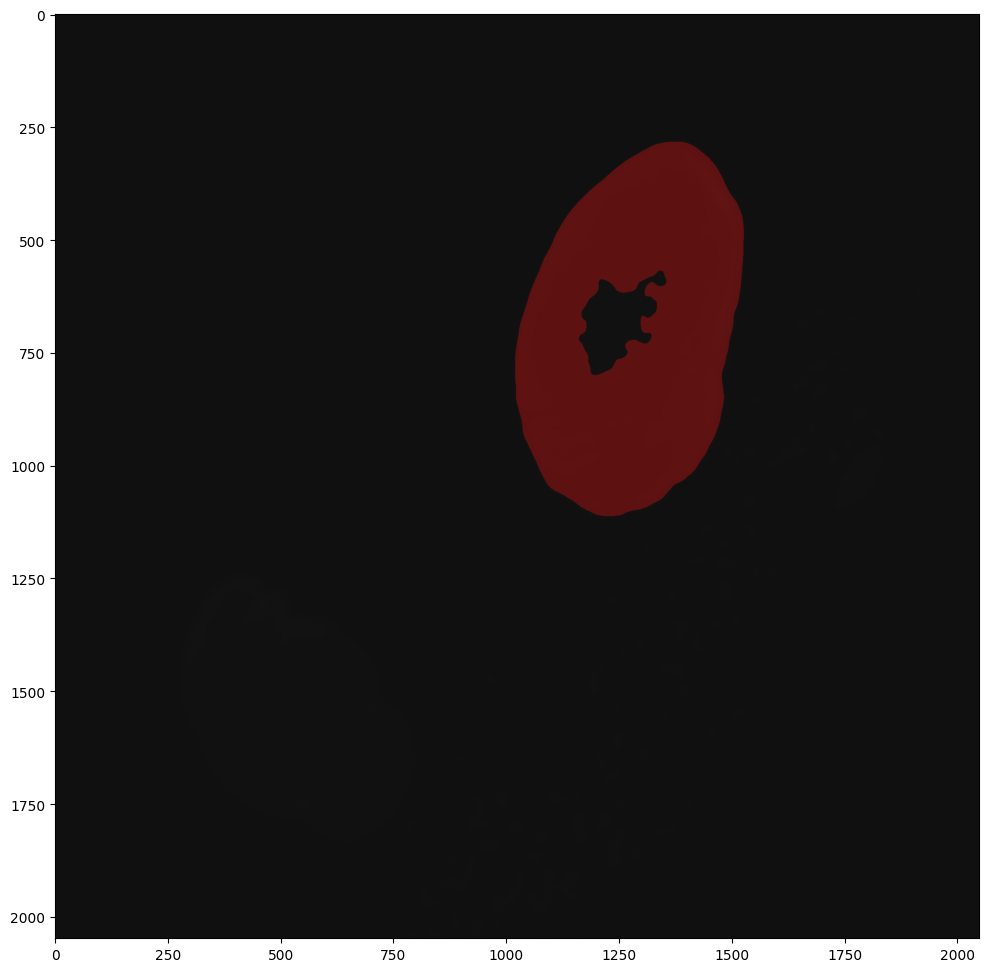

32


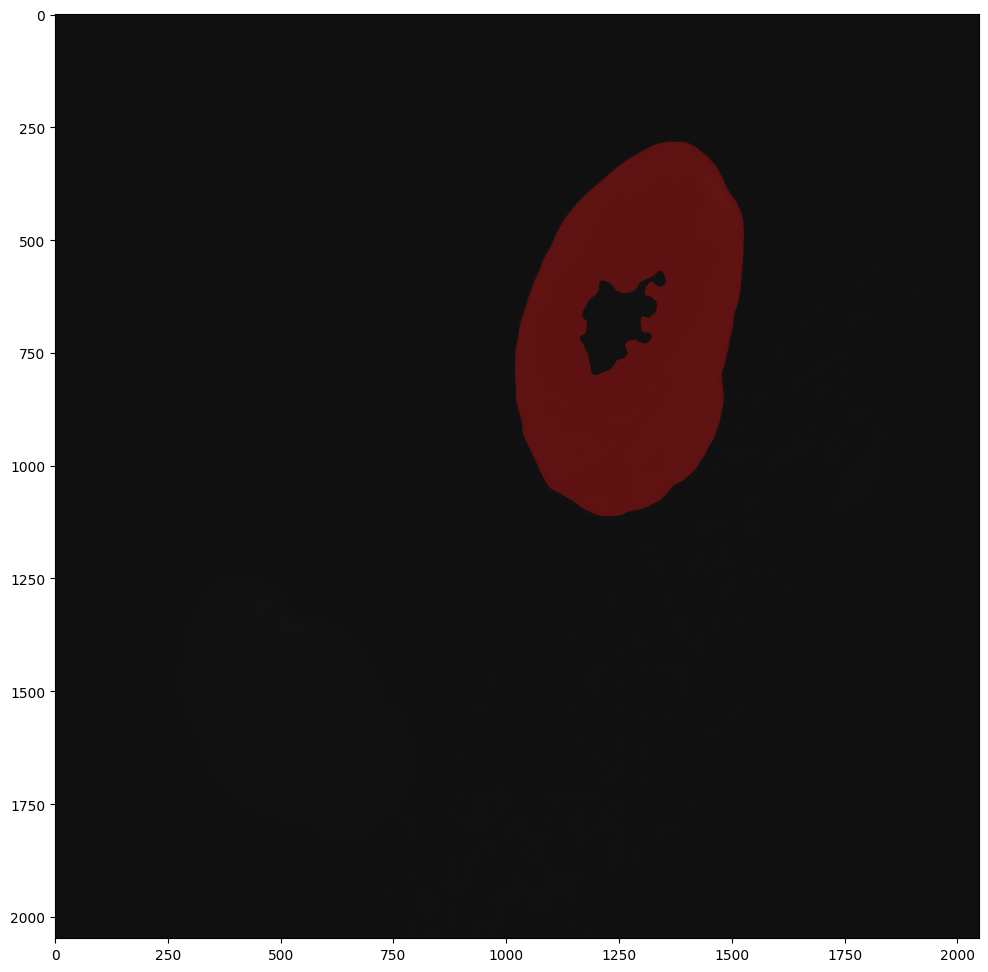

33


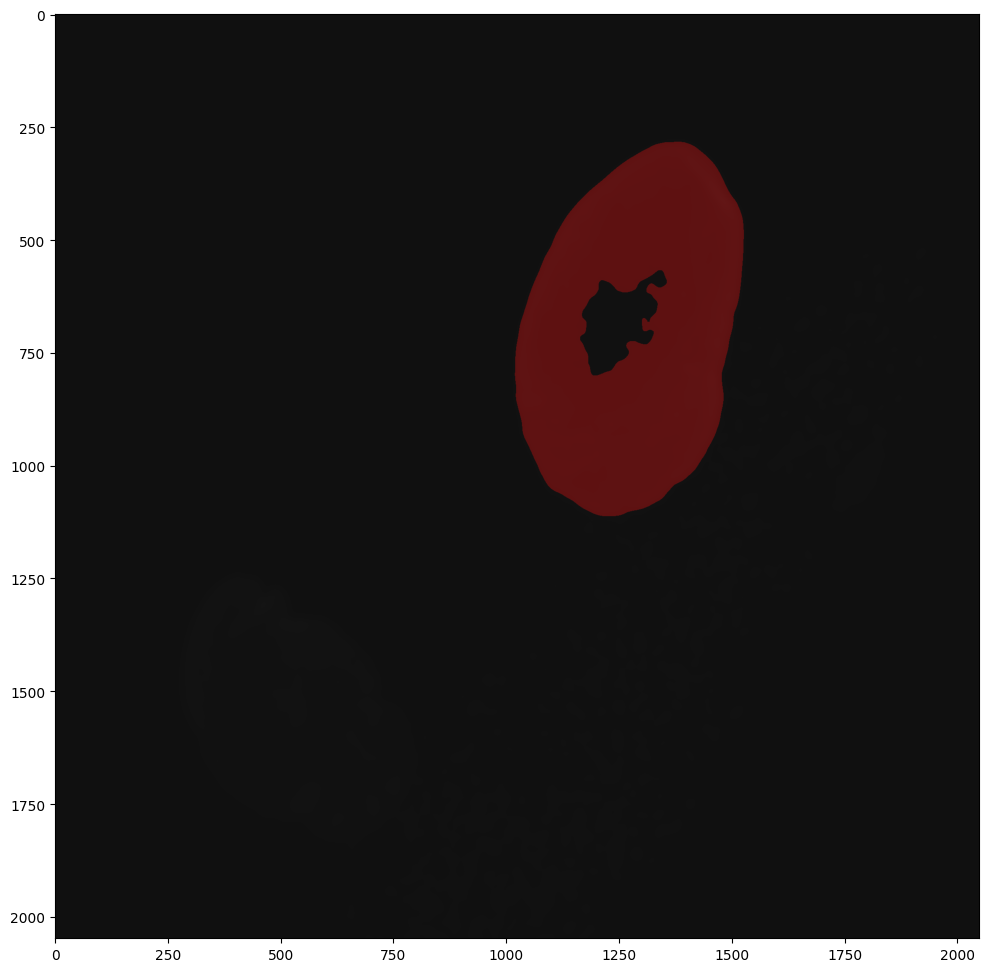

34


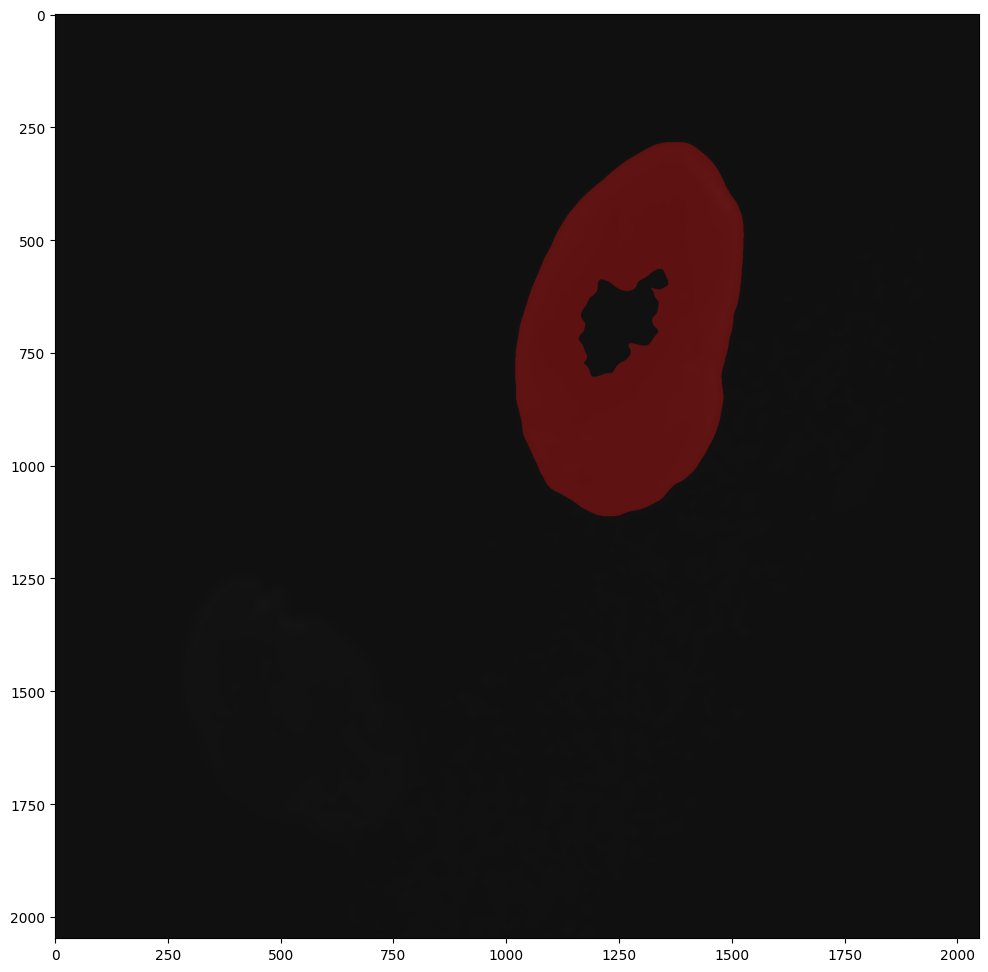

35


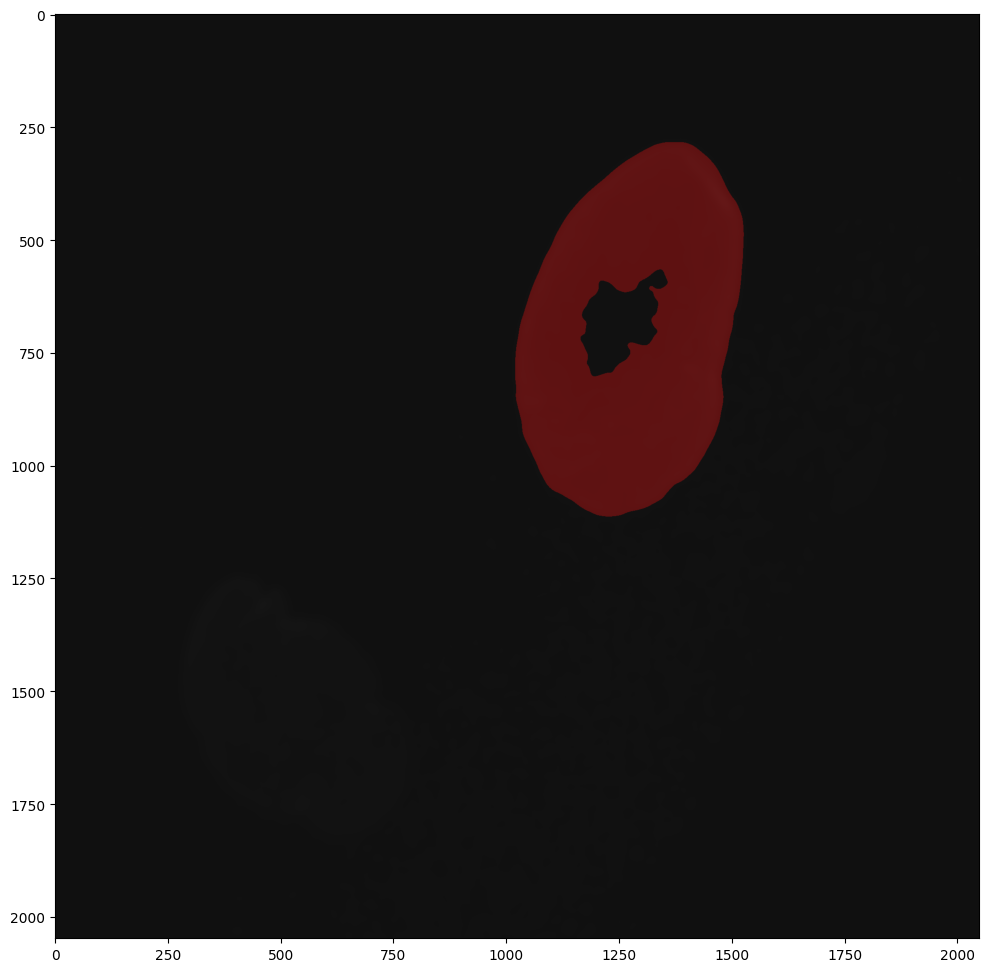

36


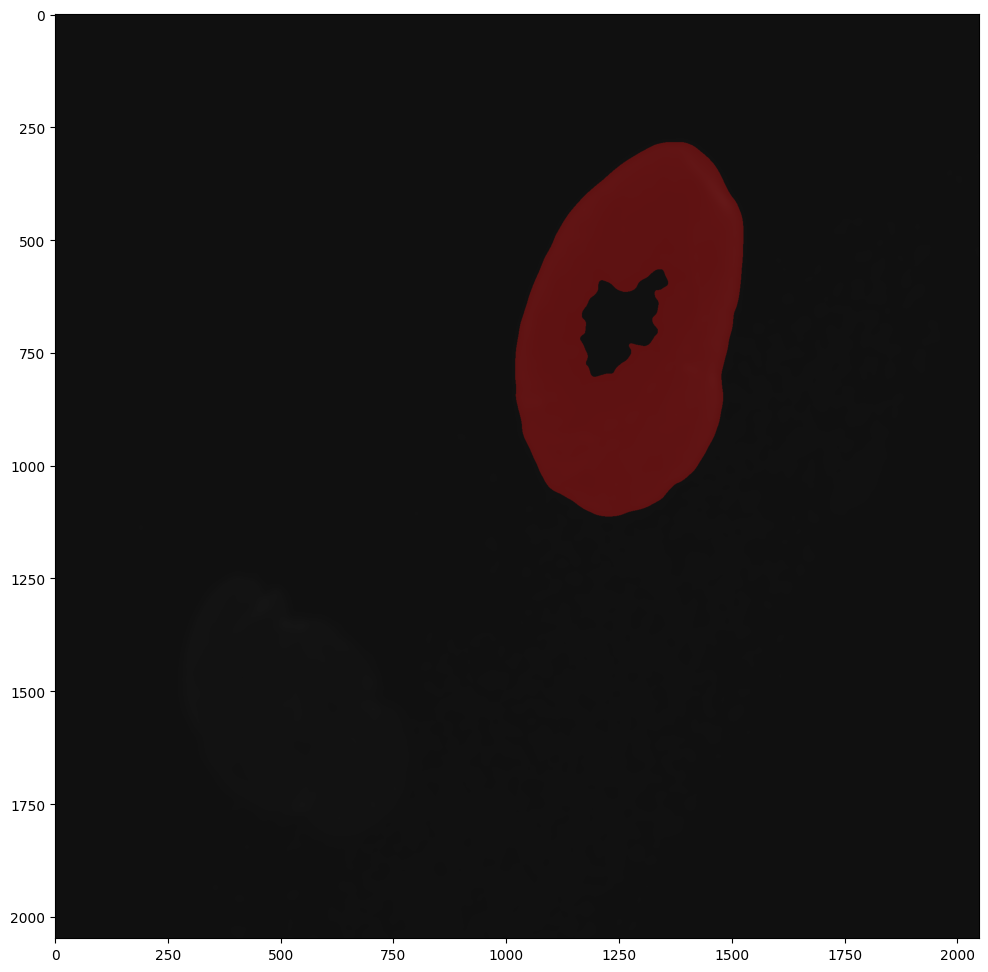

37


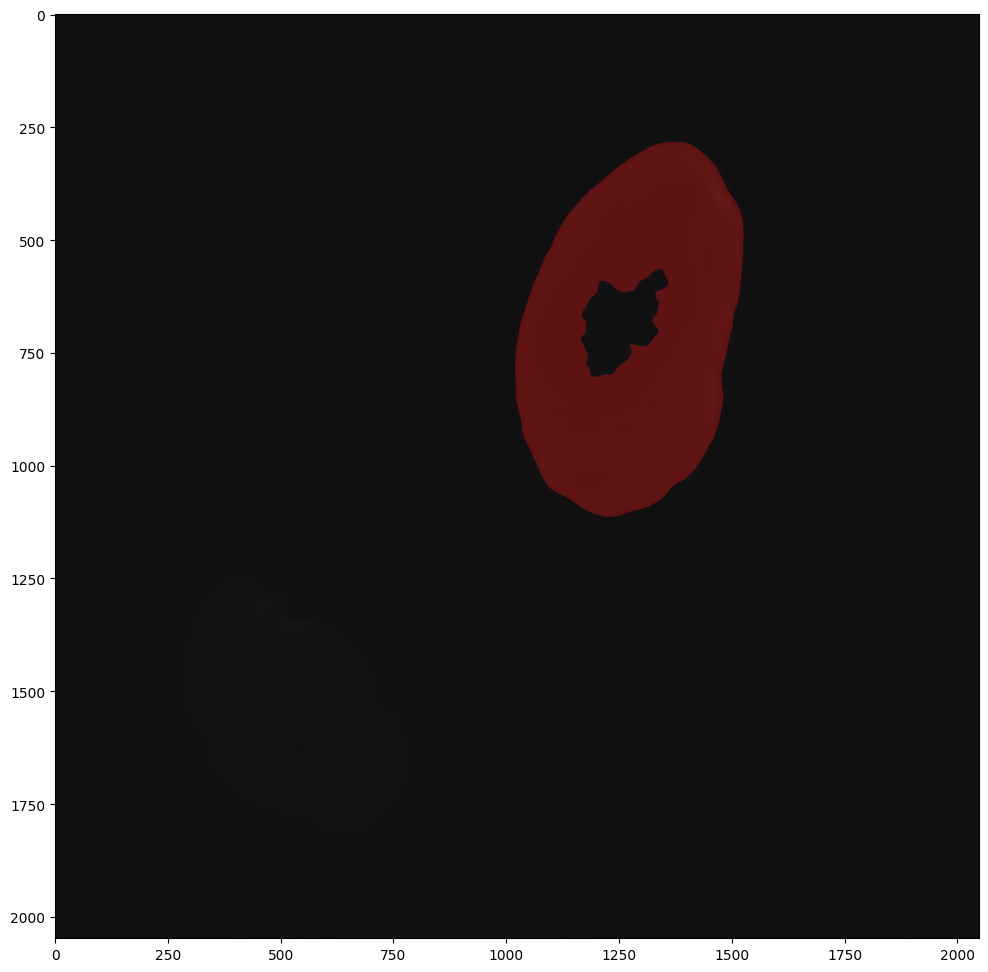

38


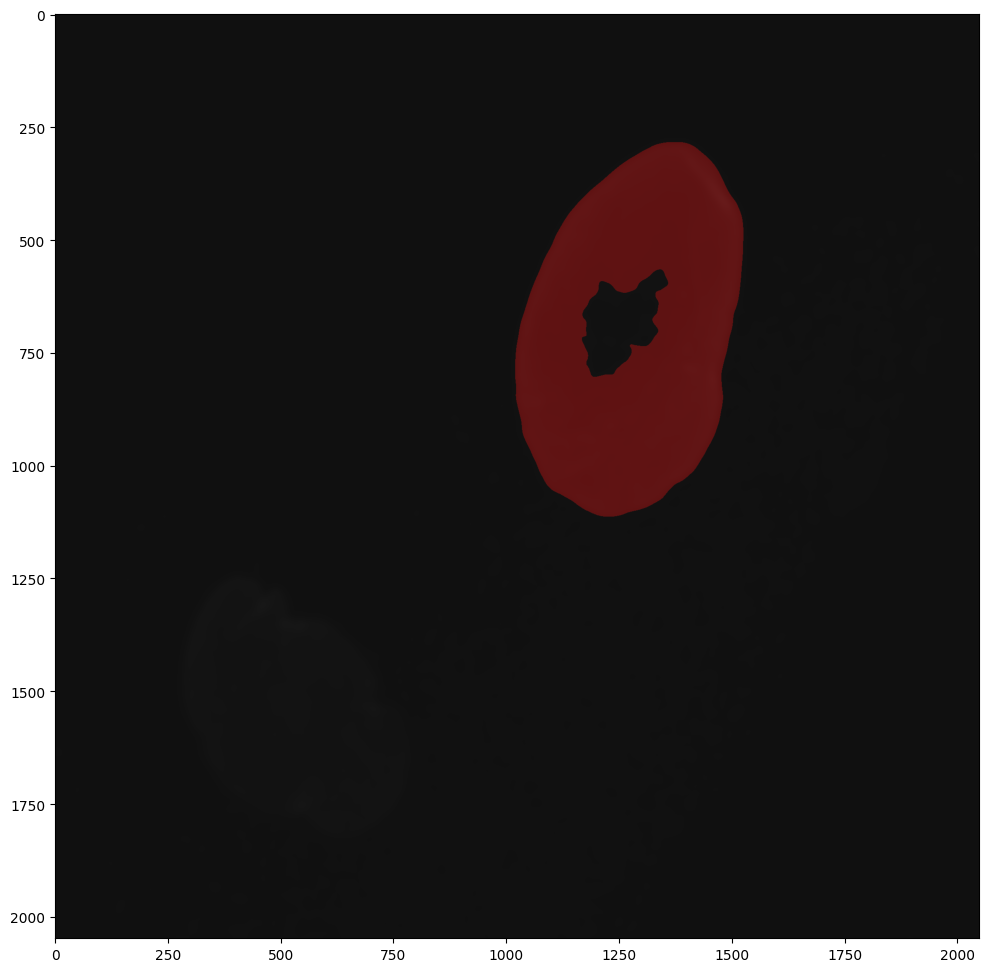

39


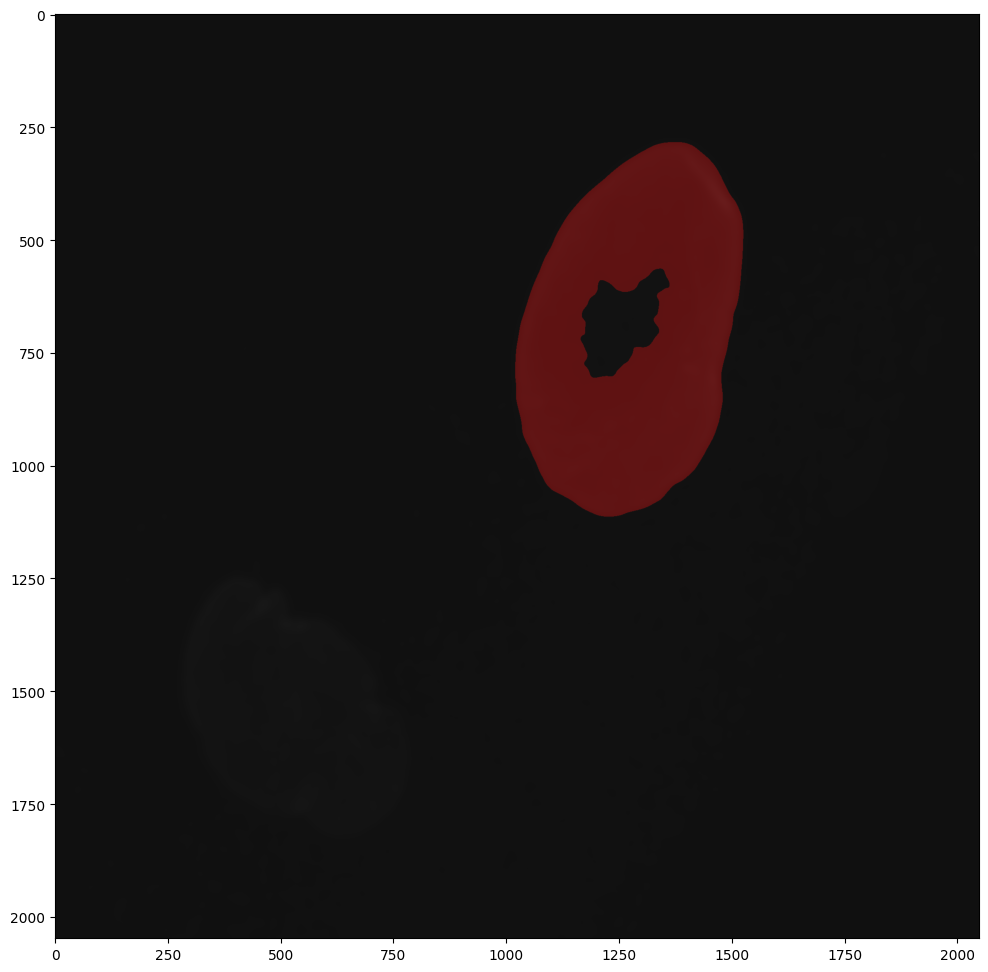

40


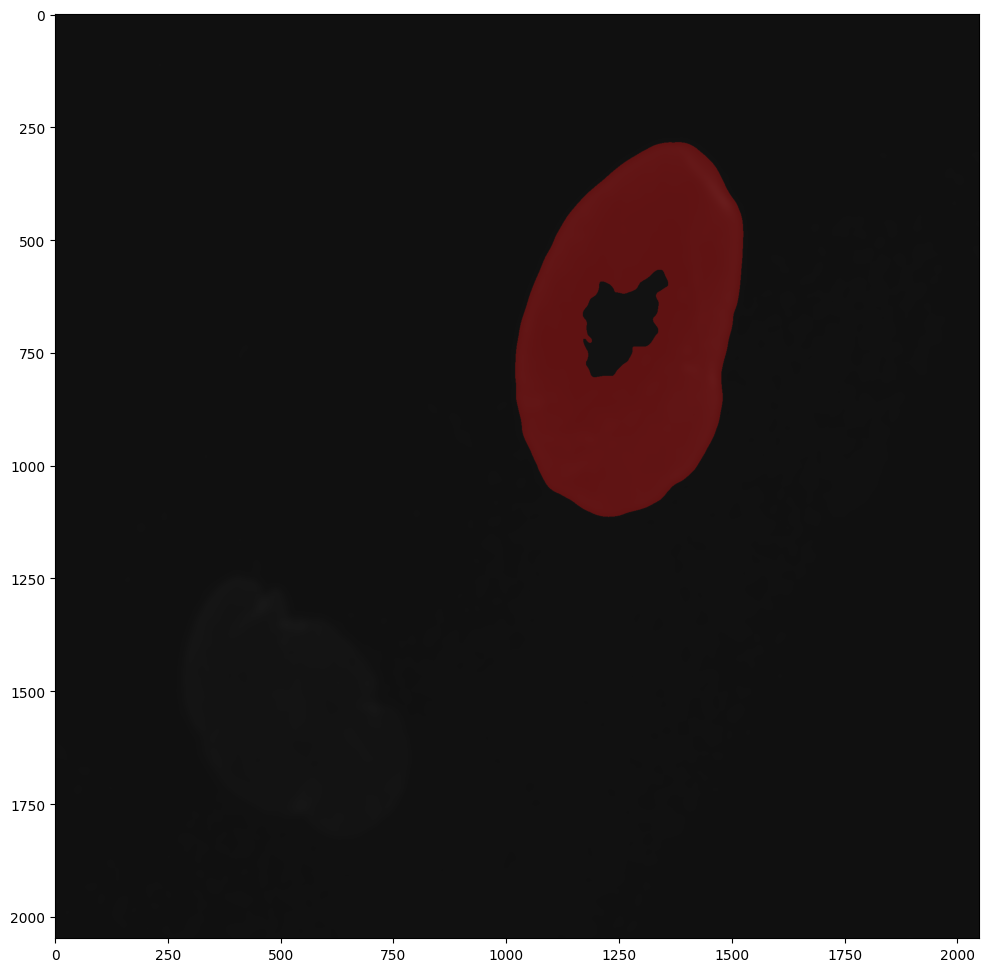

41


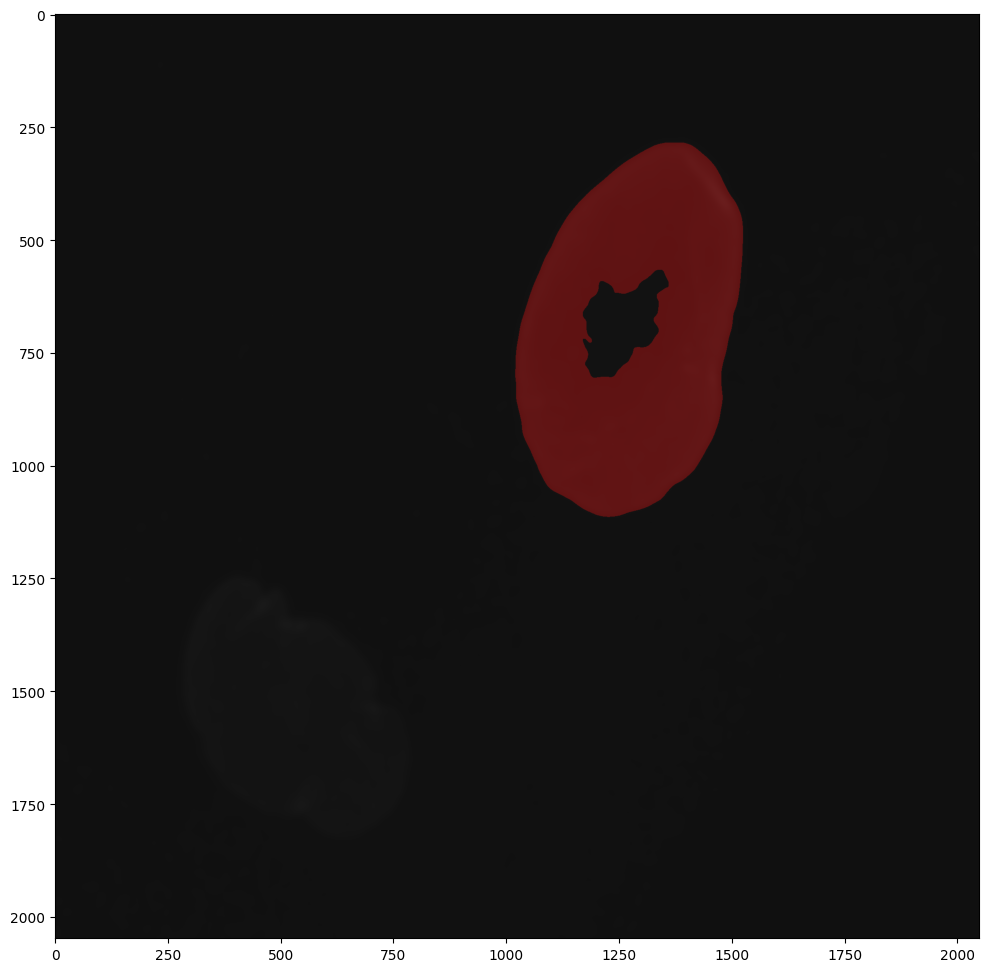

42


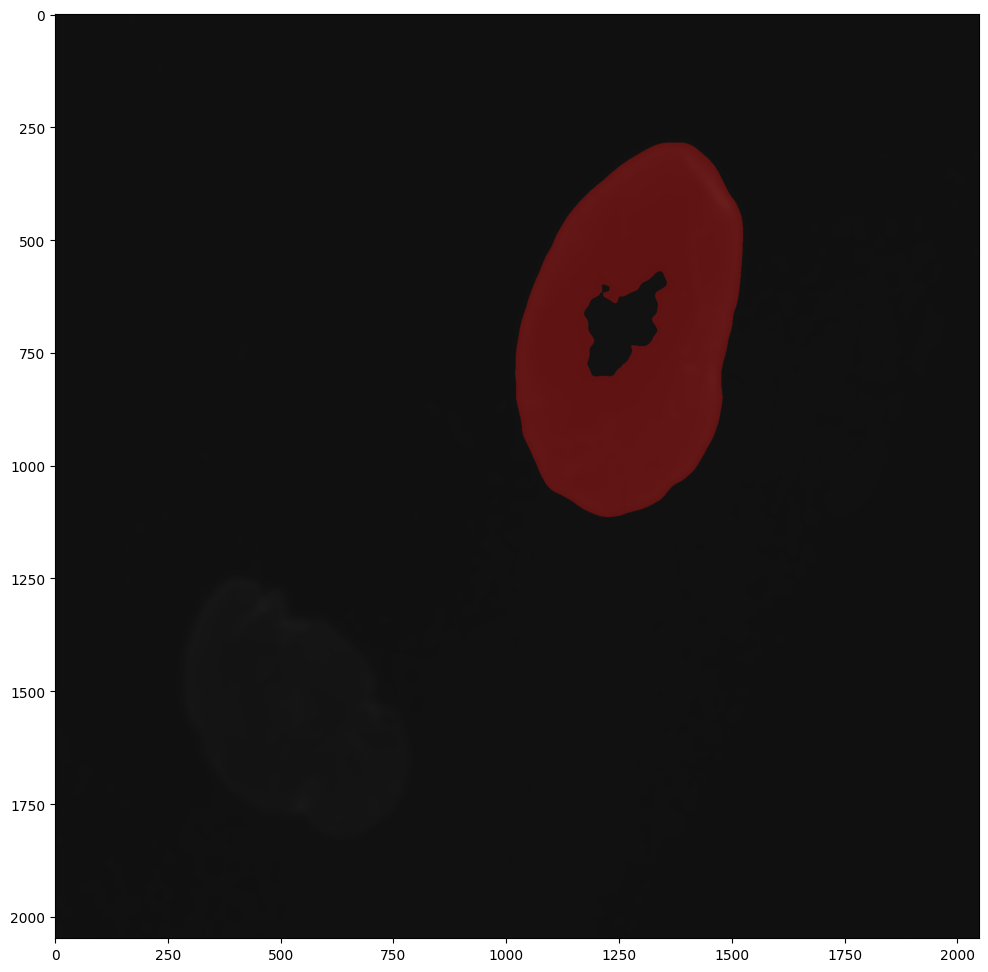

43


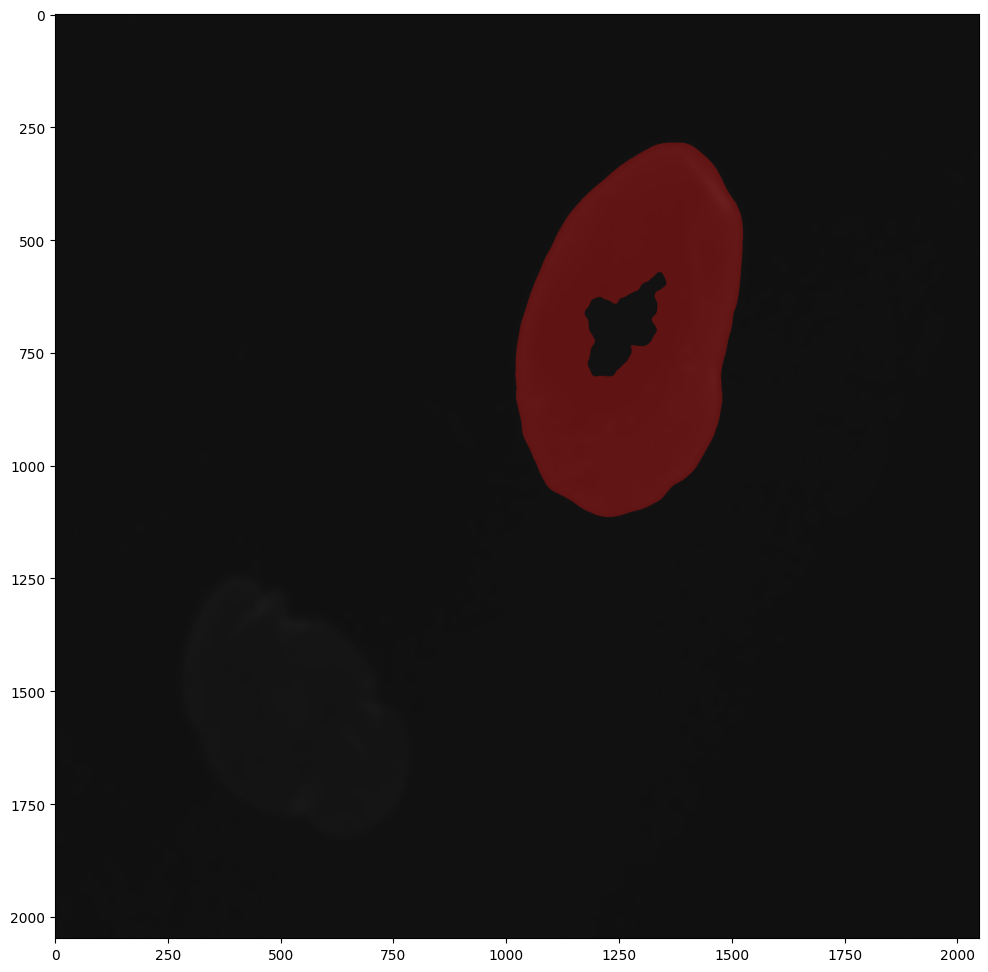

44


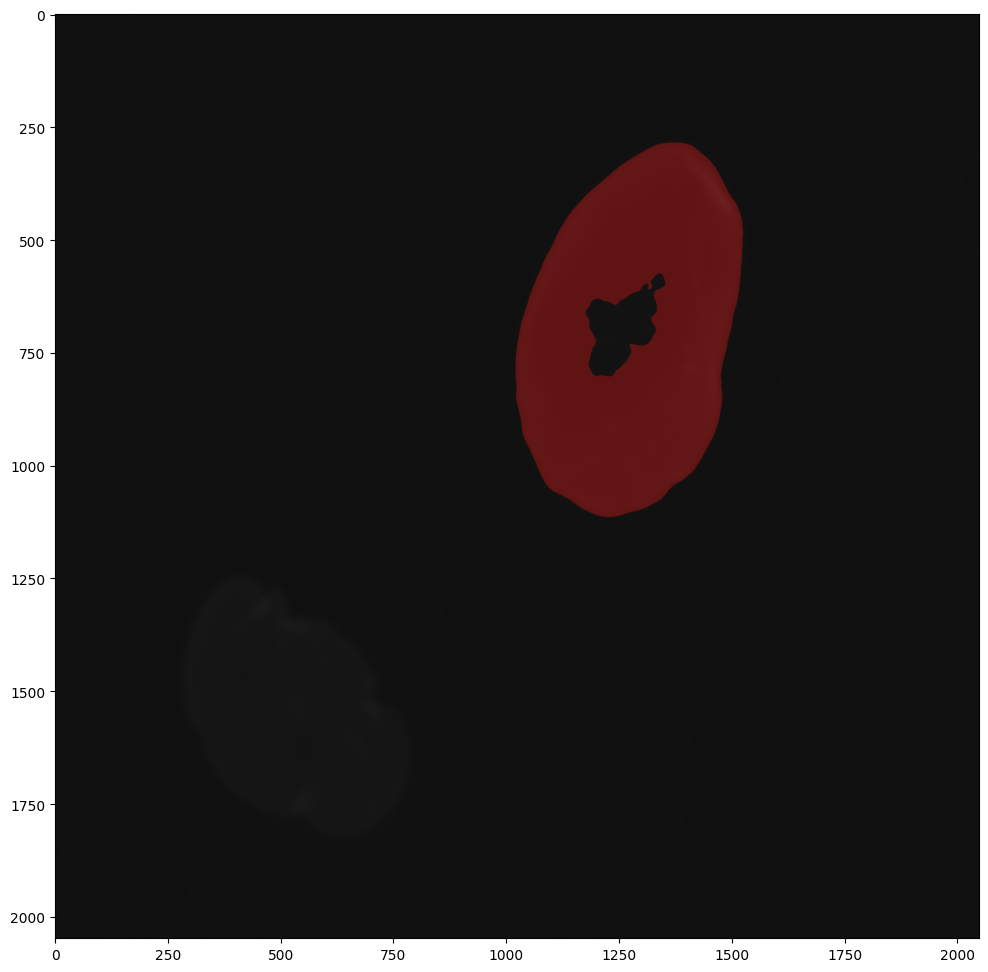

45


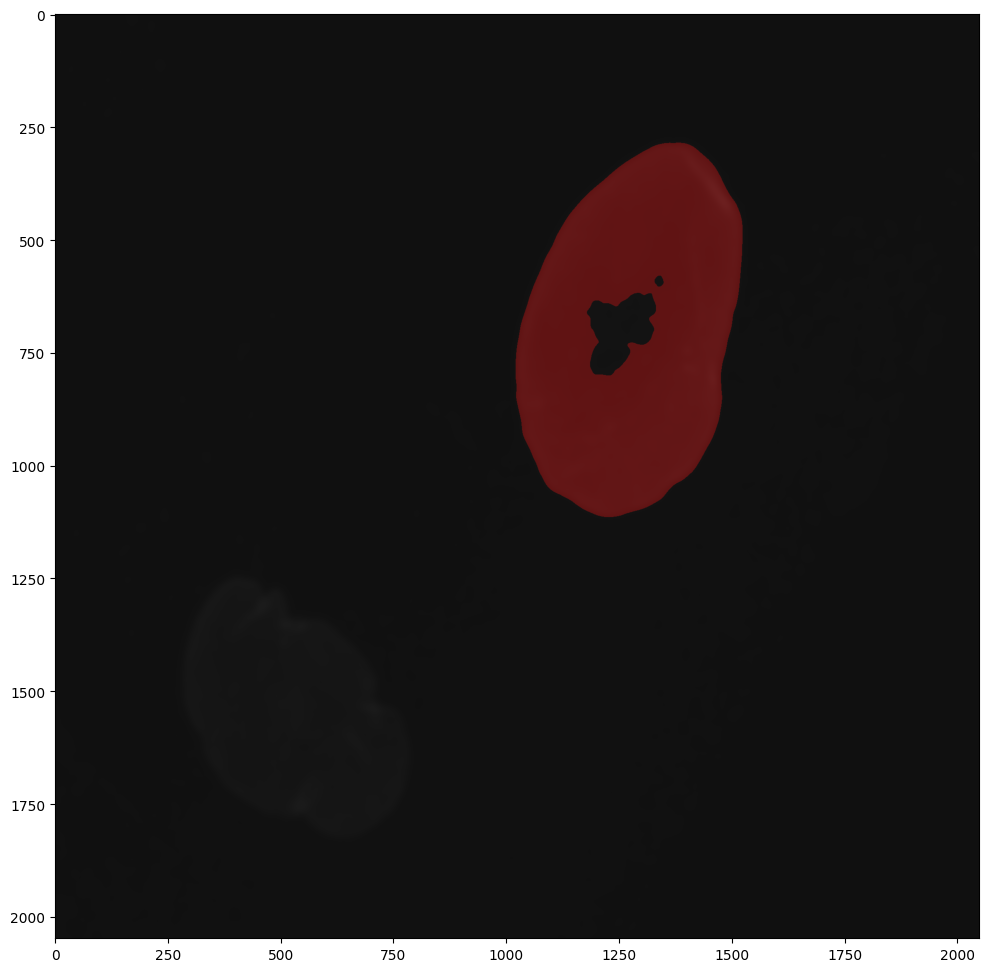

46


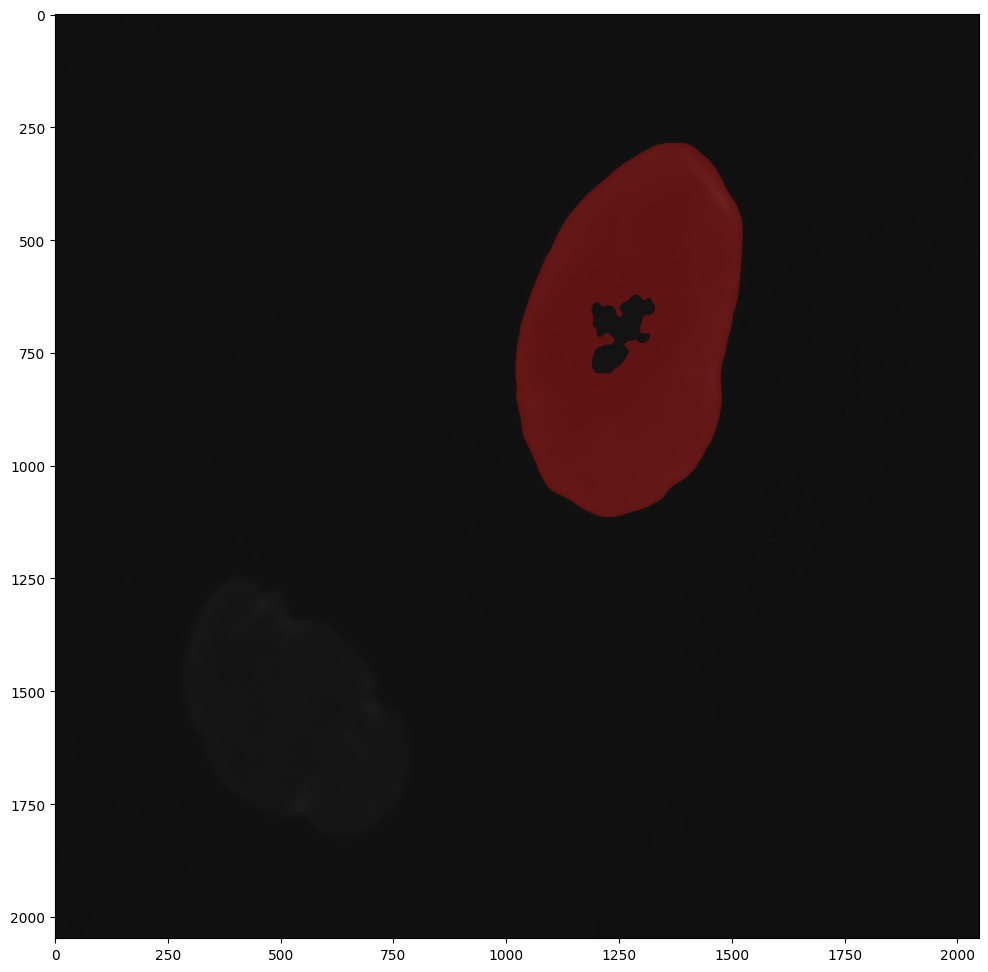

47


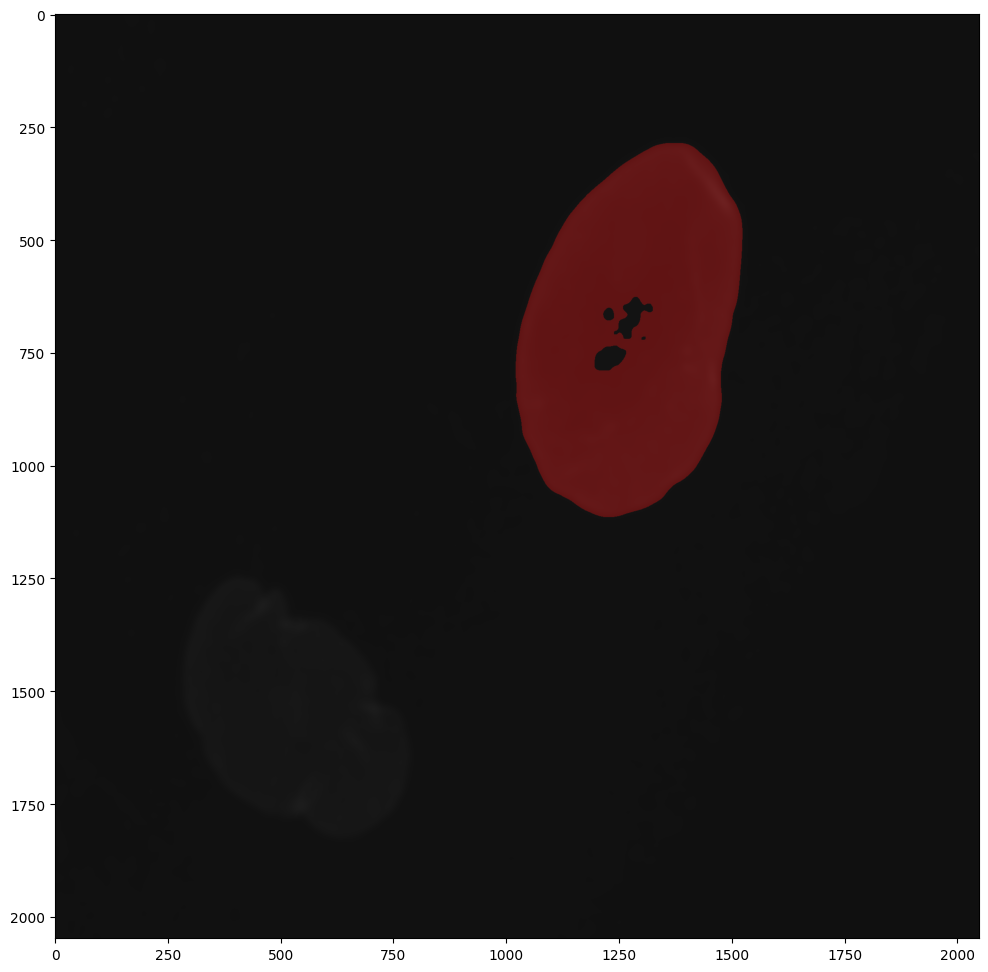

48


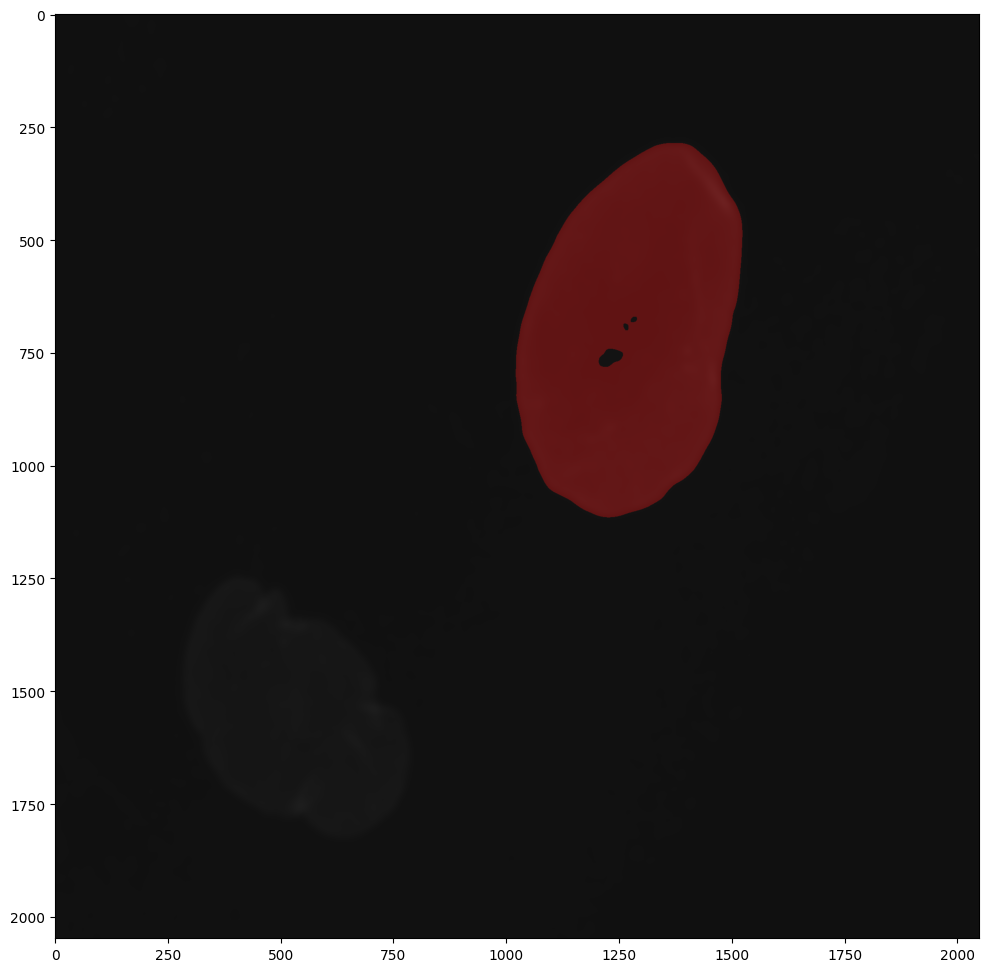

49


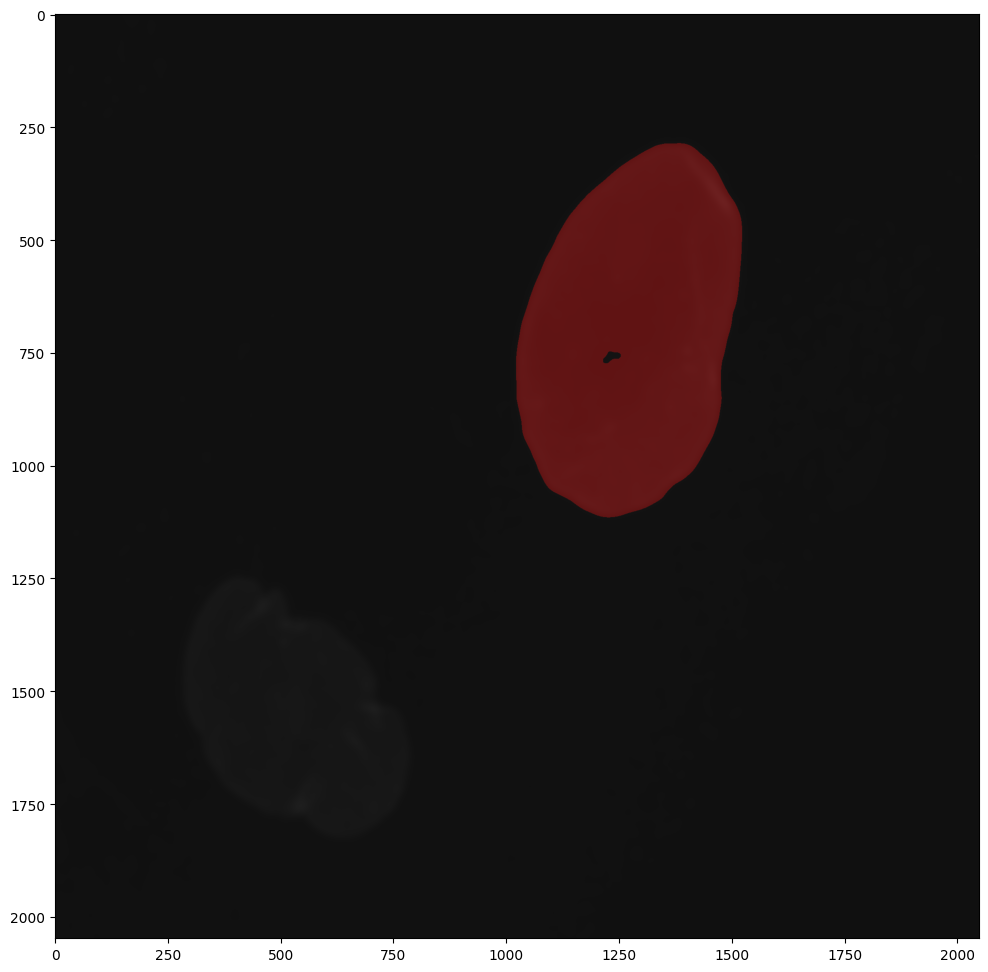

50


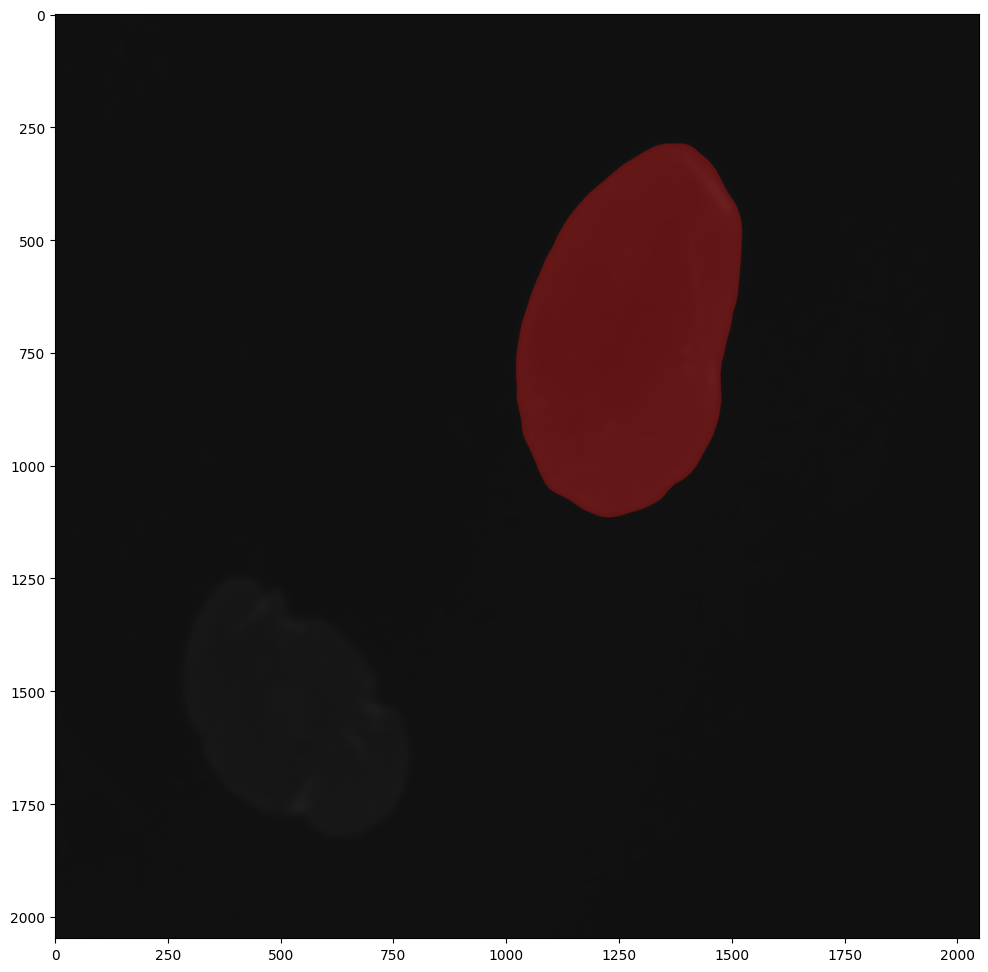

51


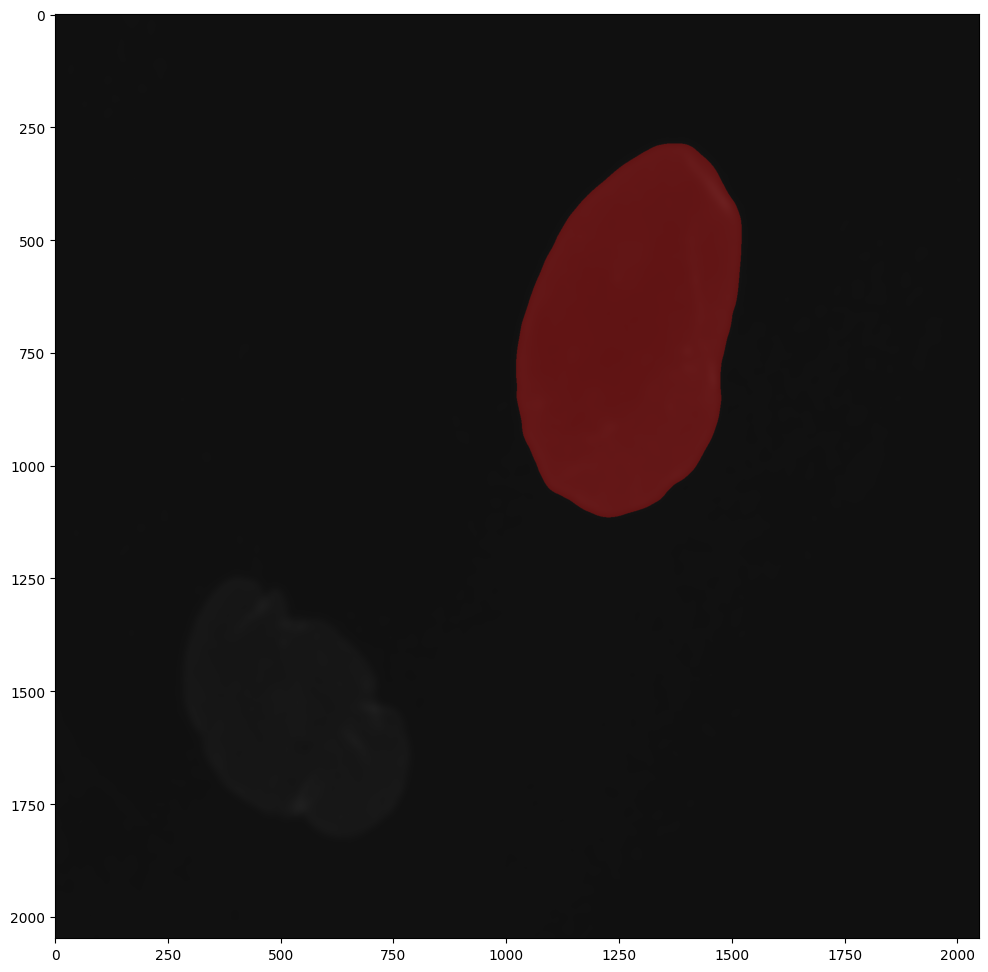

52


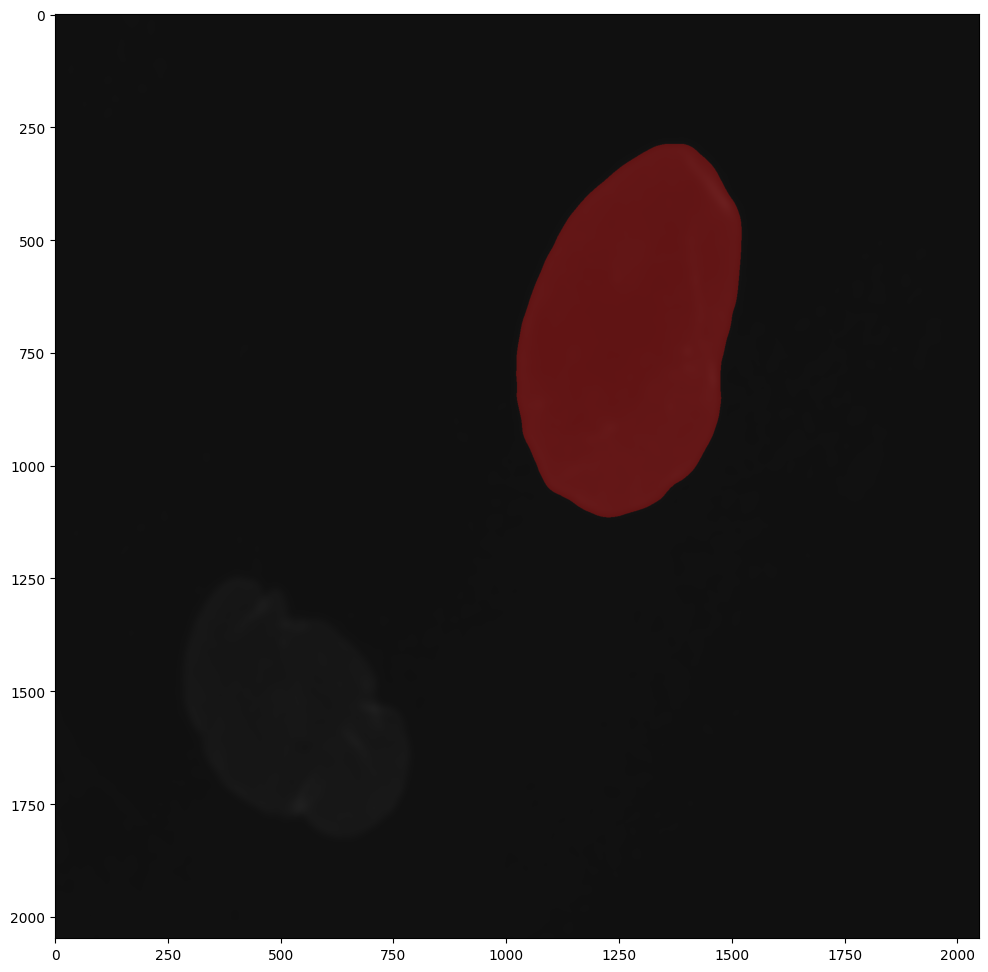

53


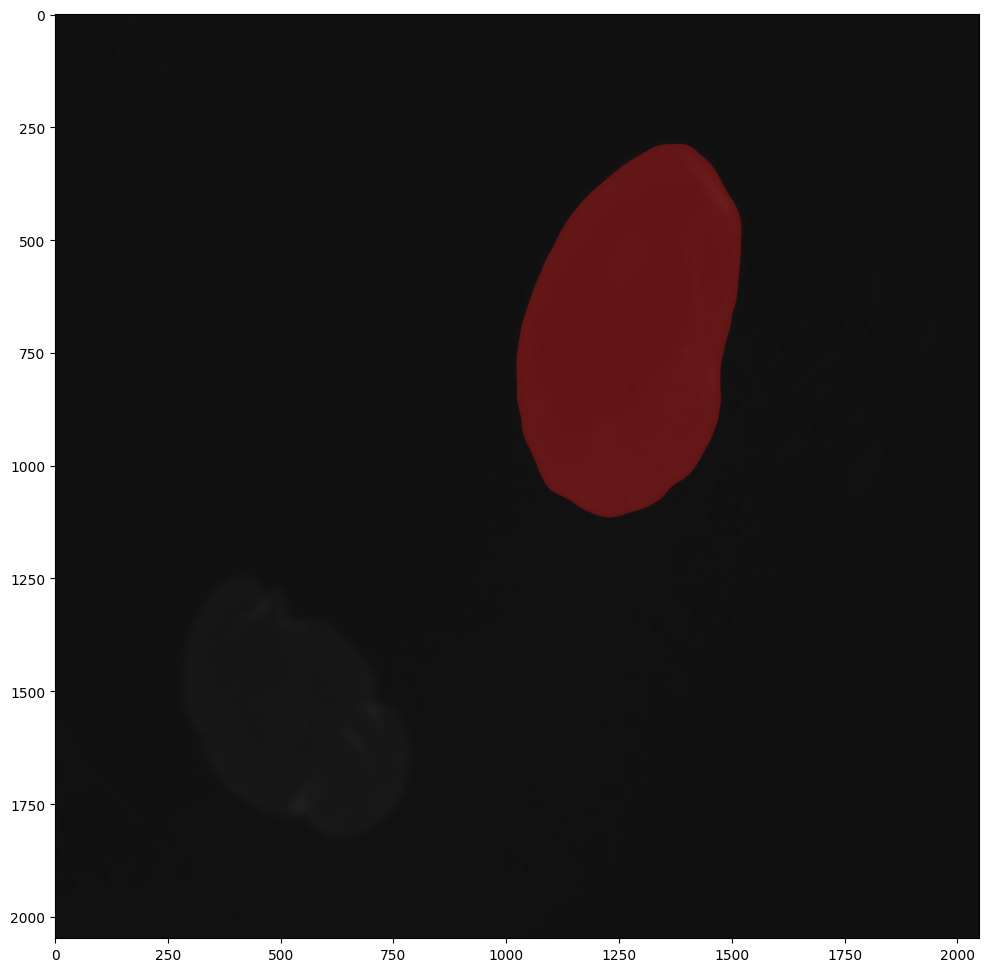

54


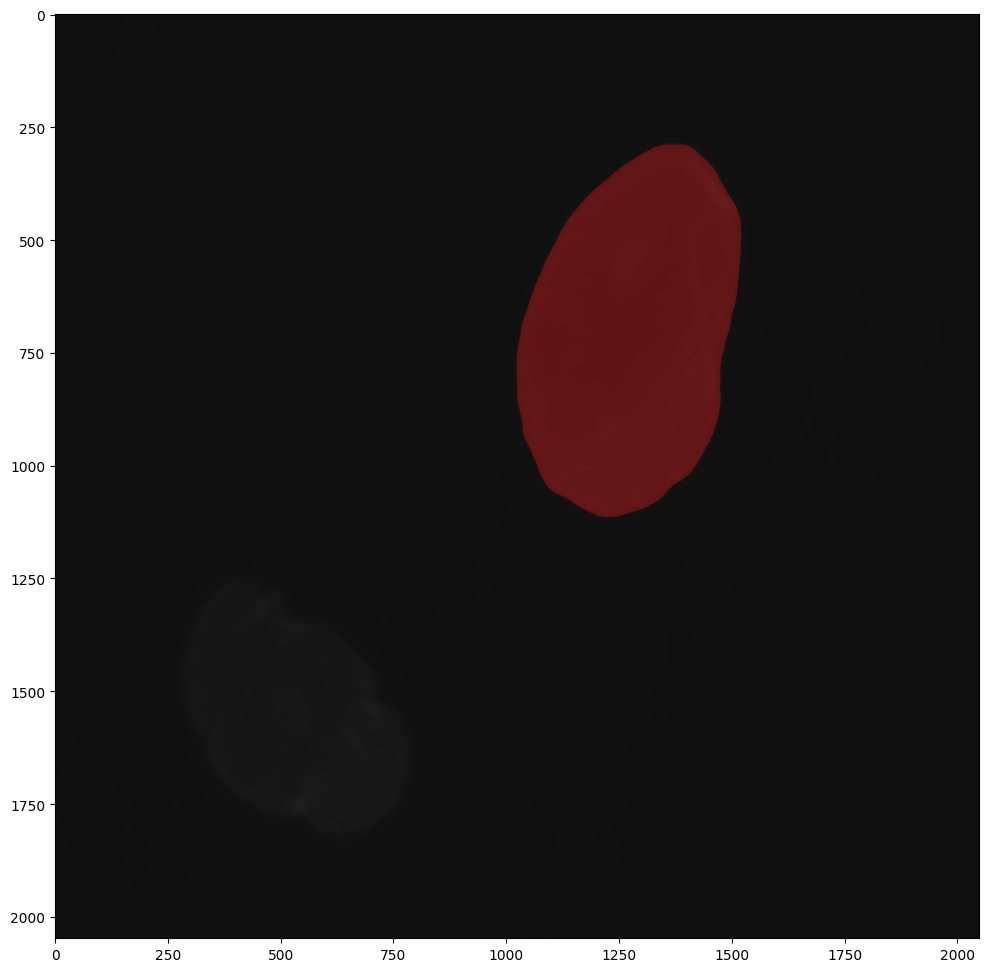

55


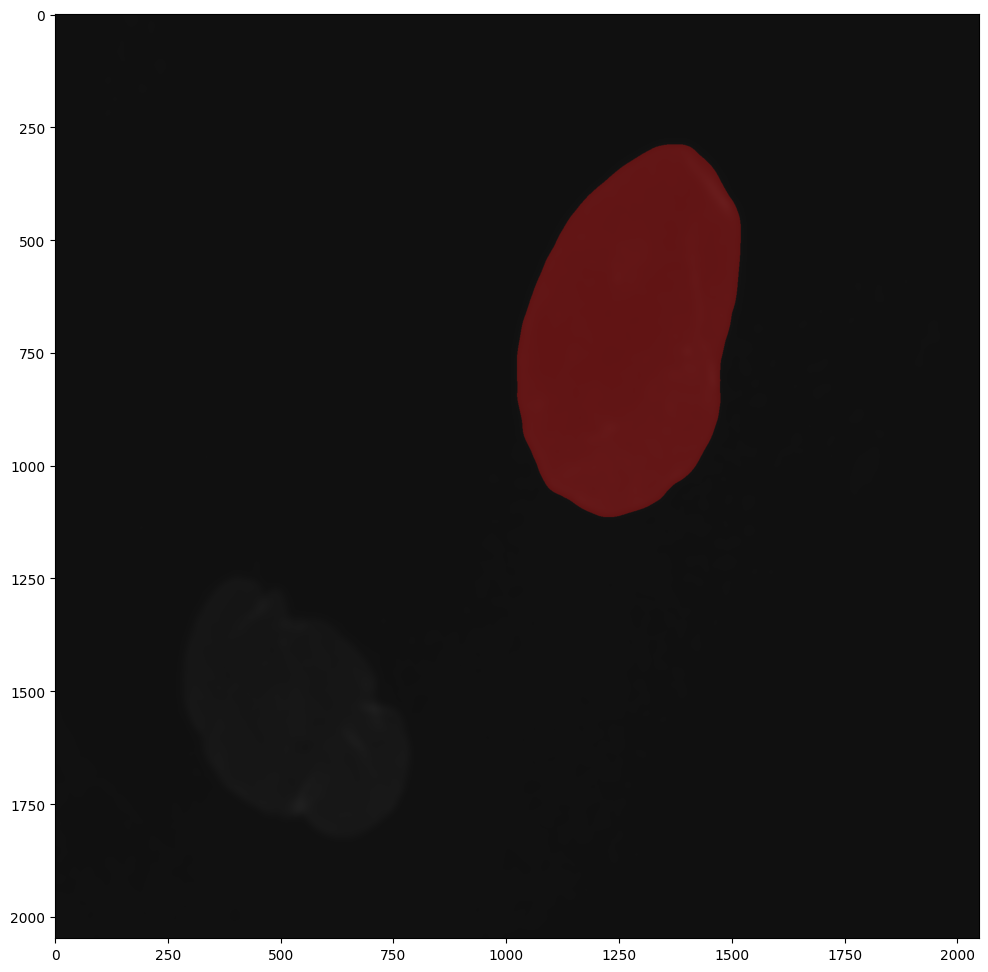

56


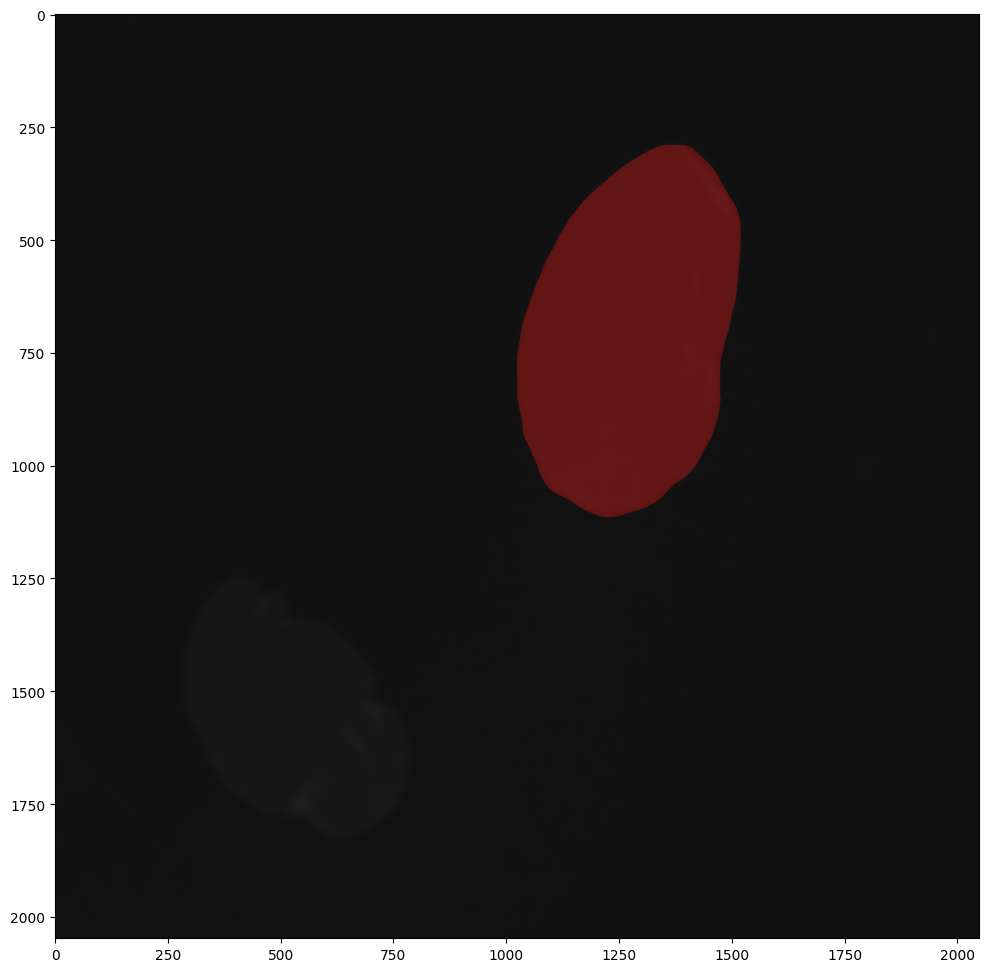

57


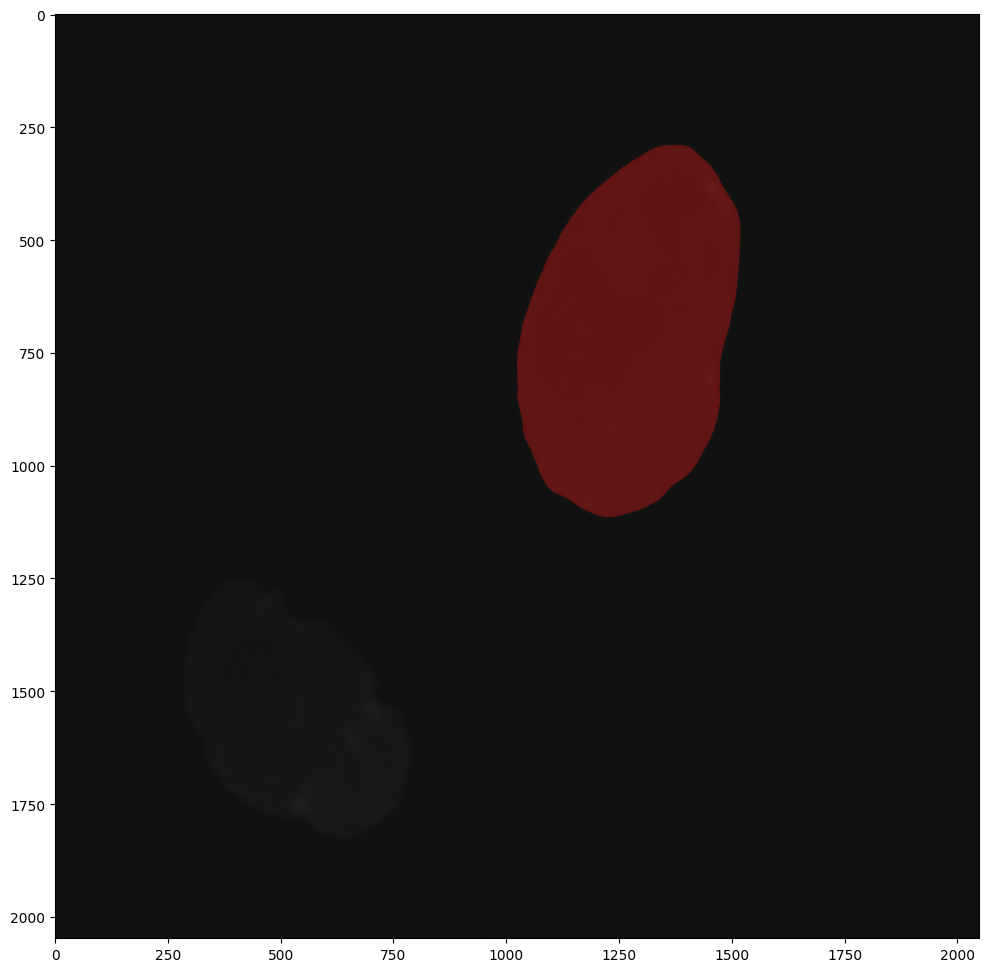

58


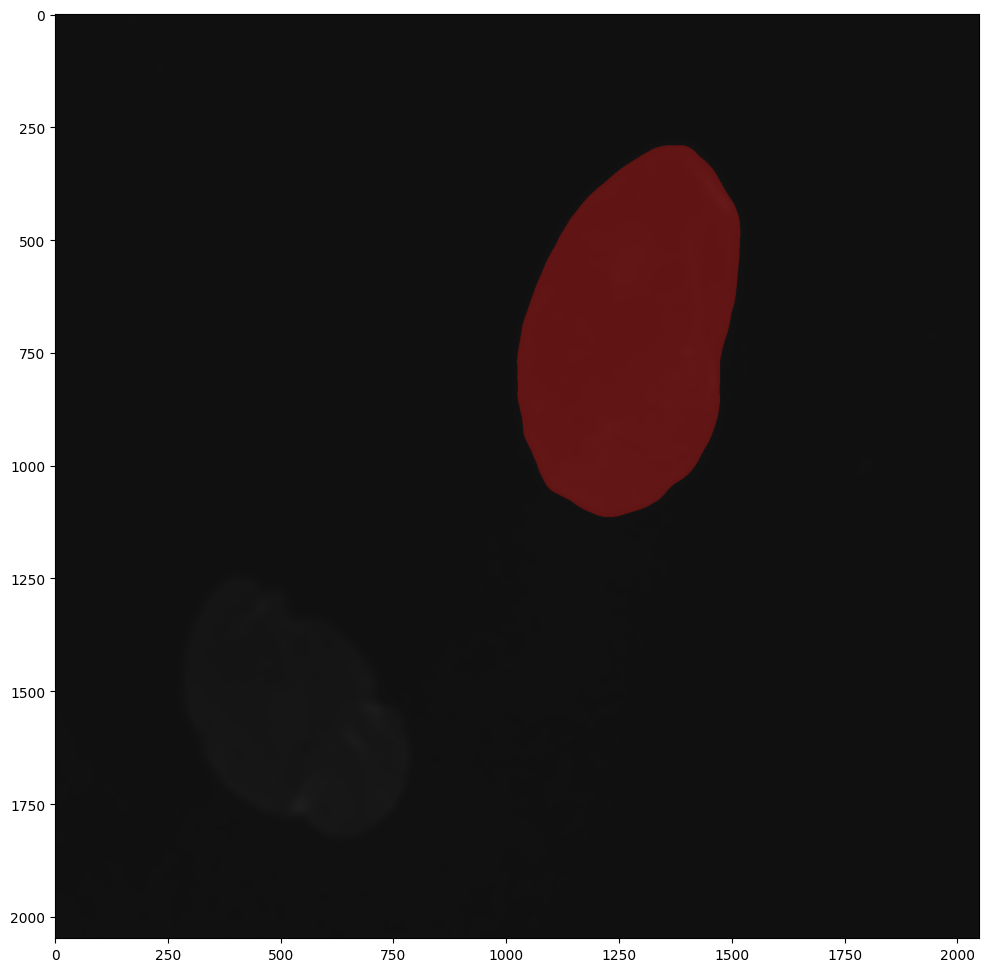

59


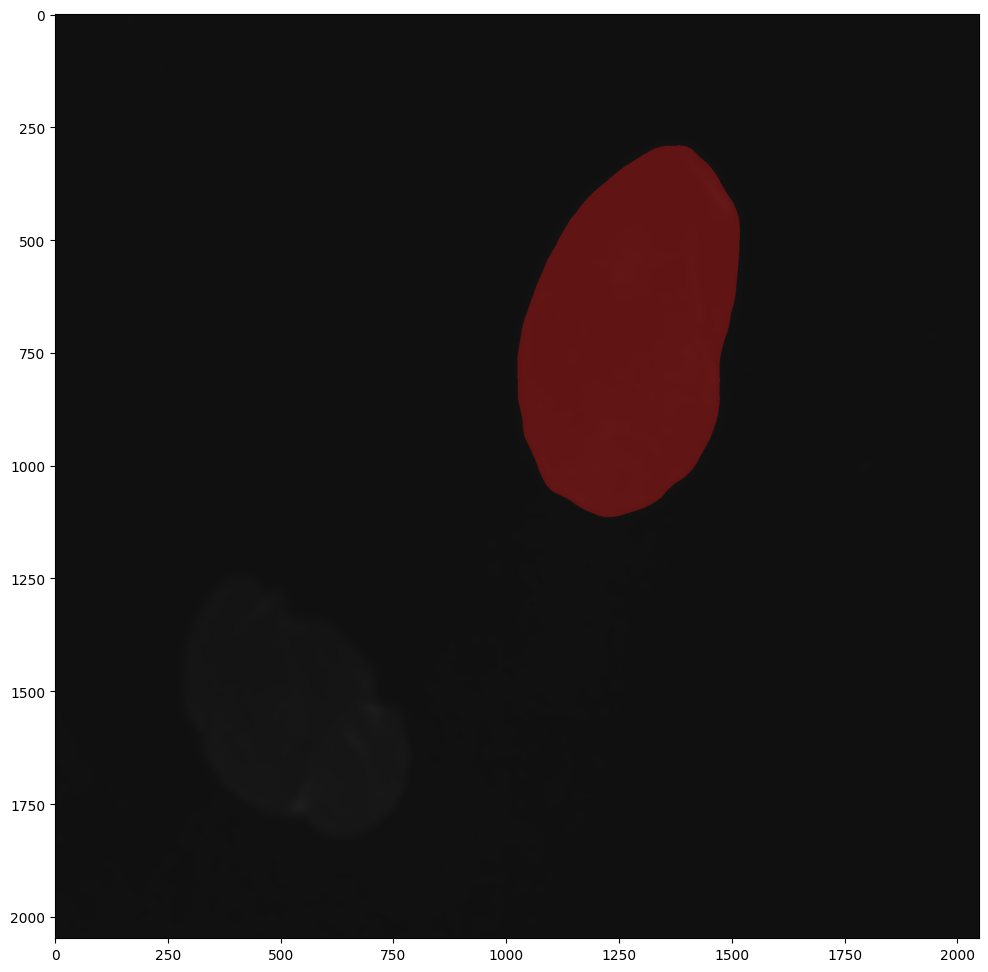

60


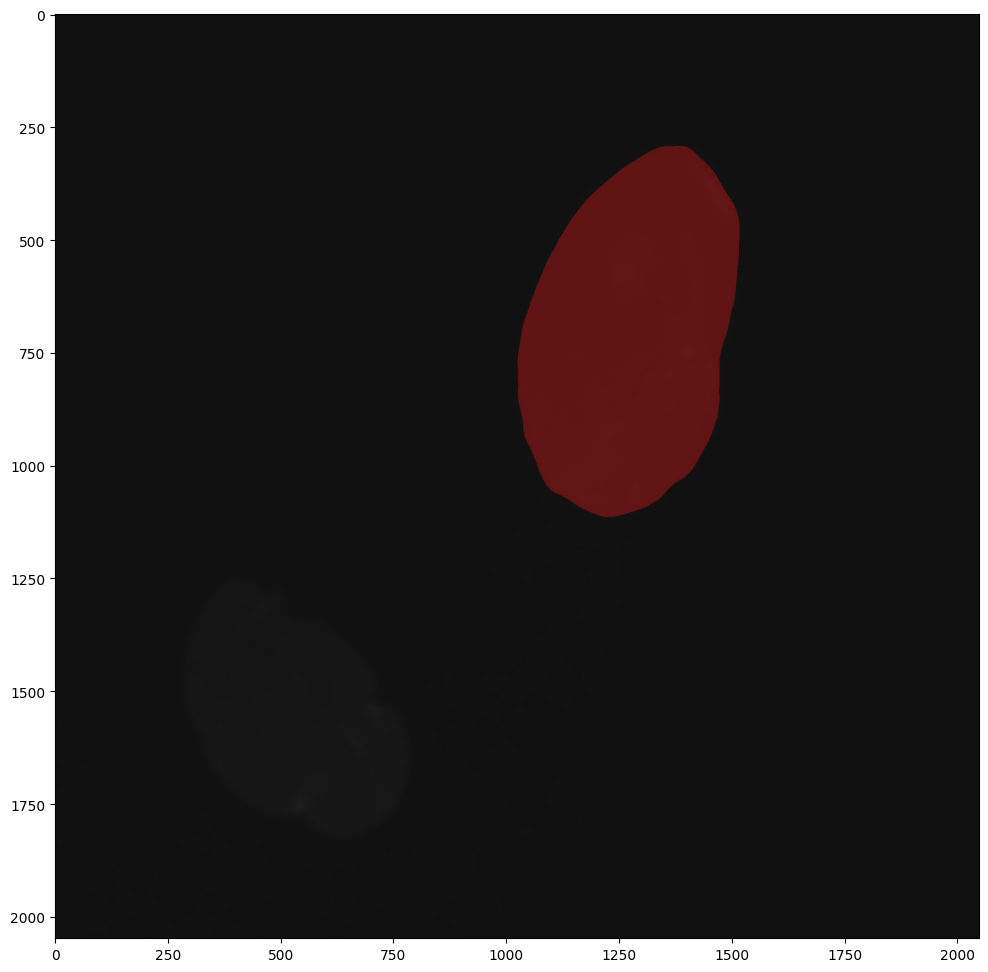

61


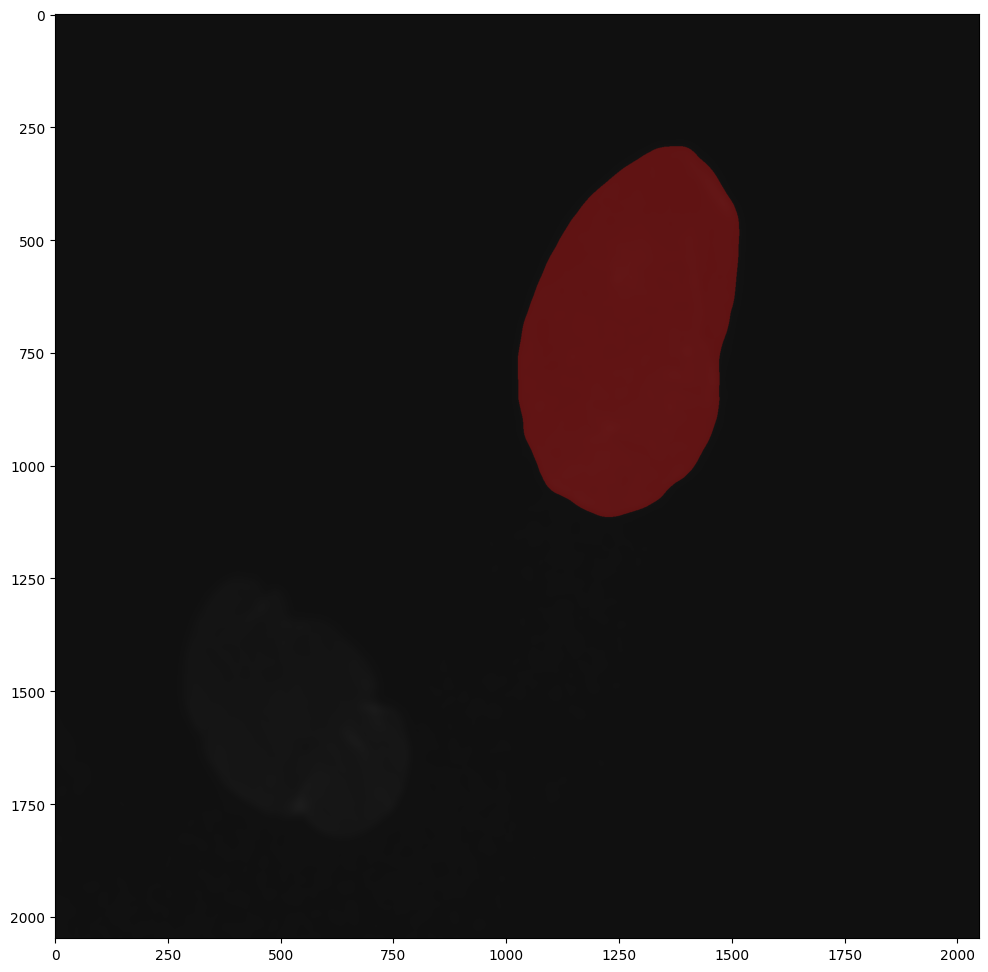

62


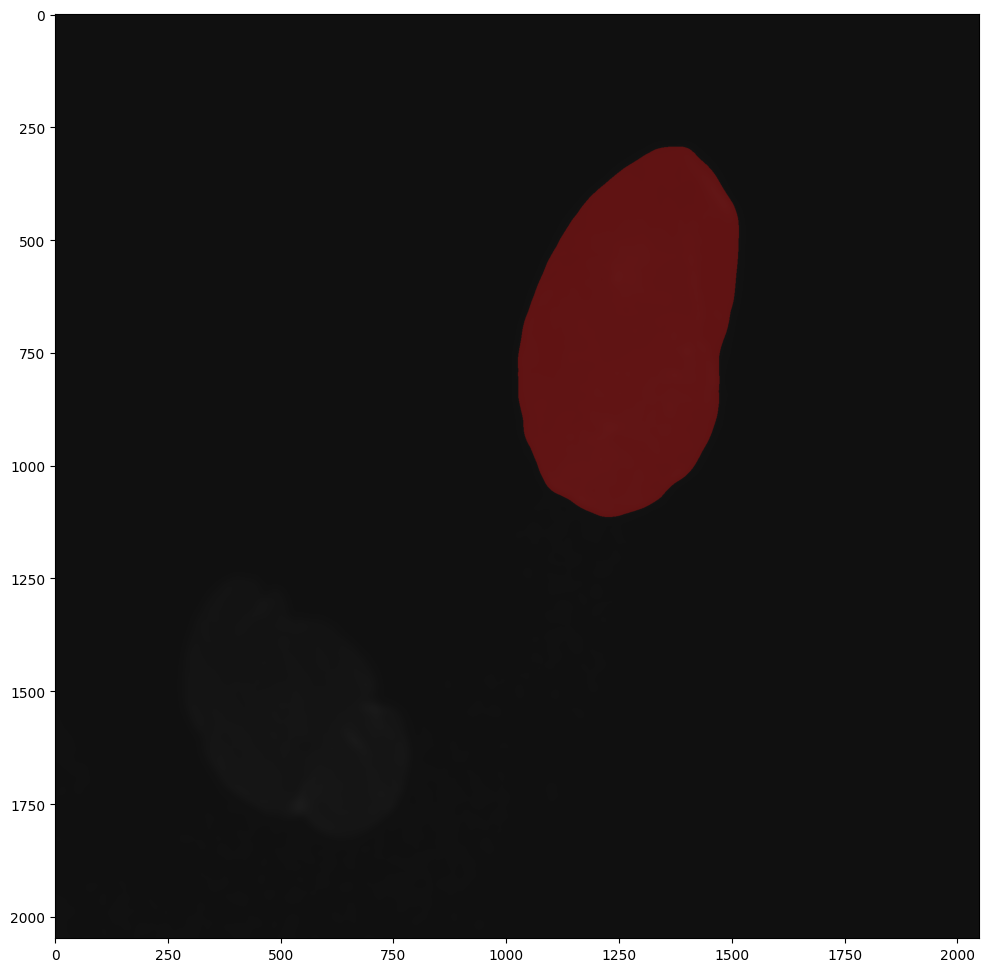

63


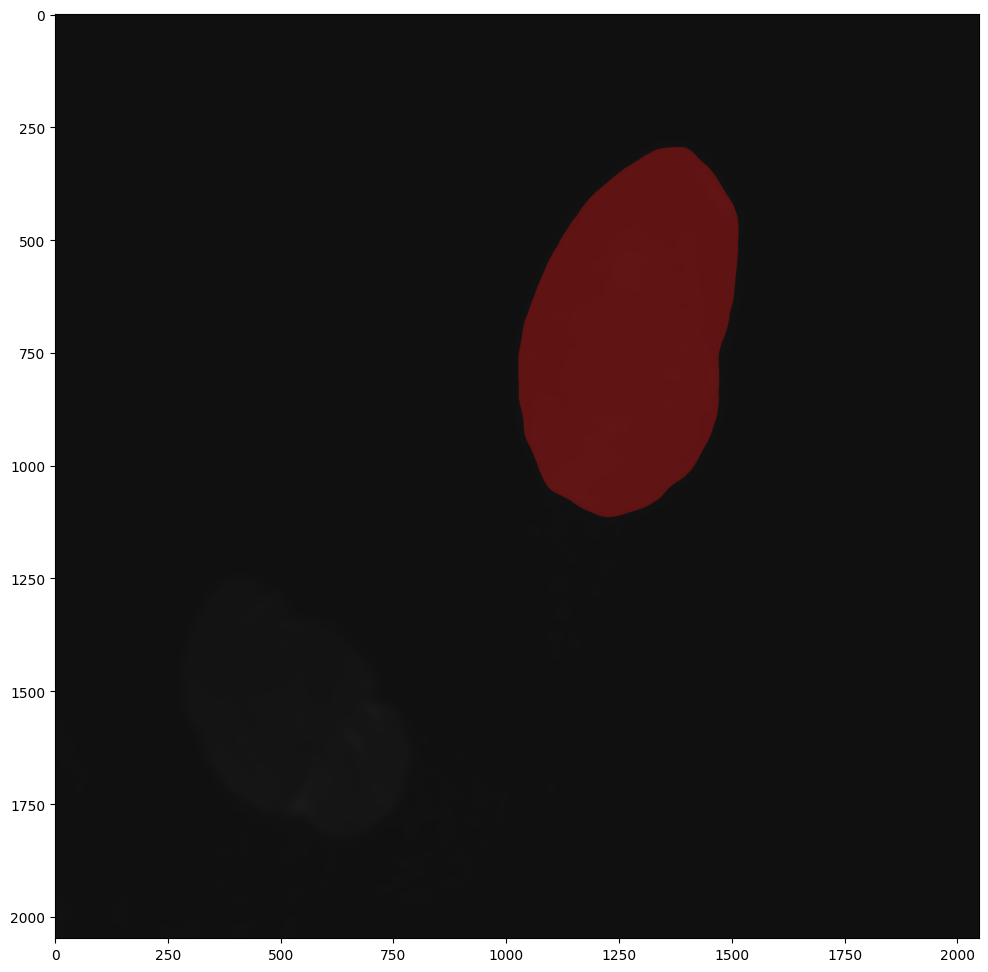

64


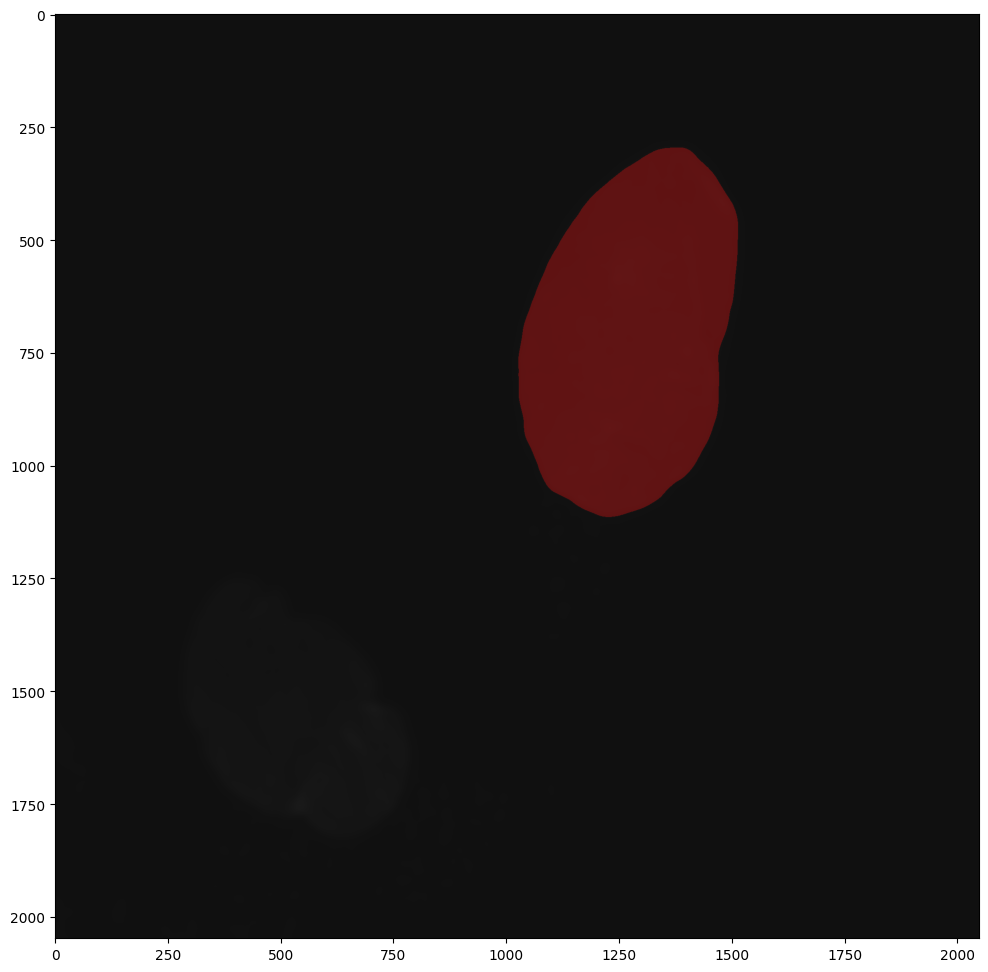

65


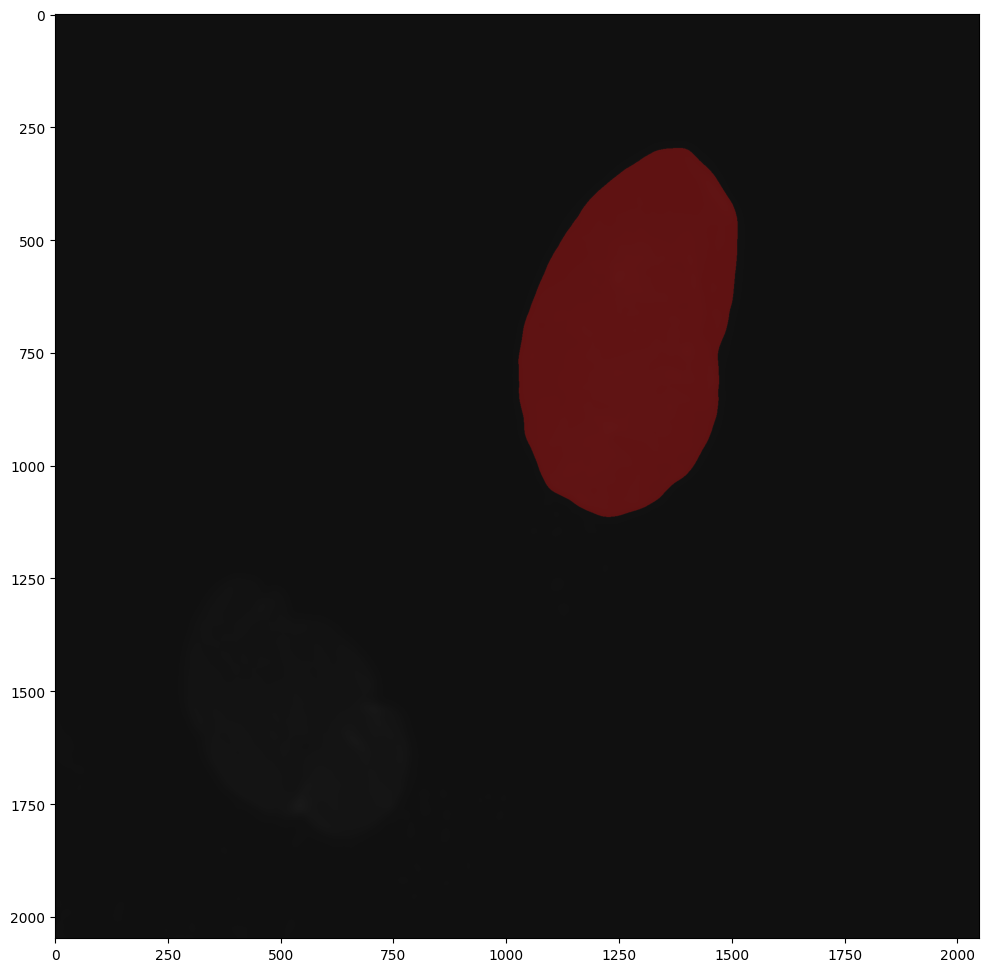

66


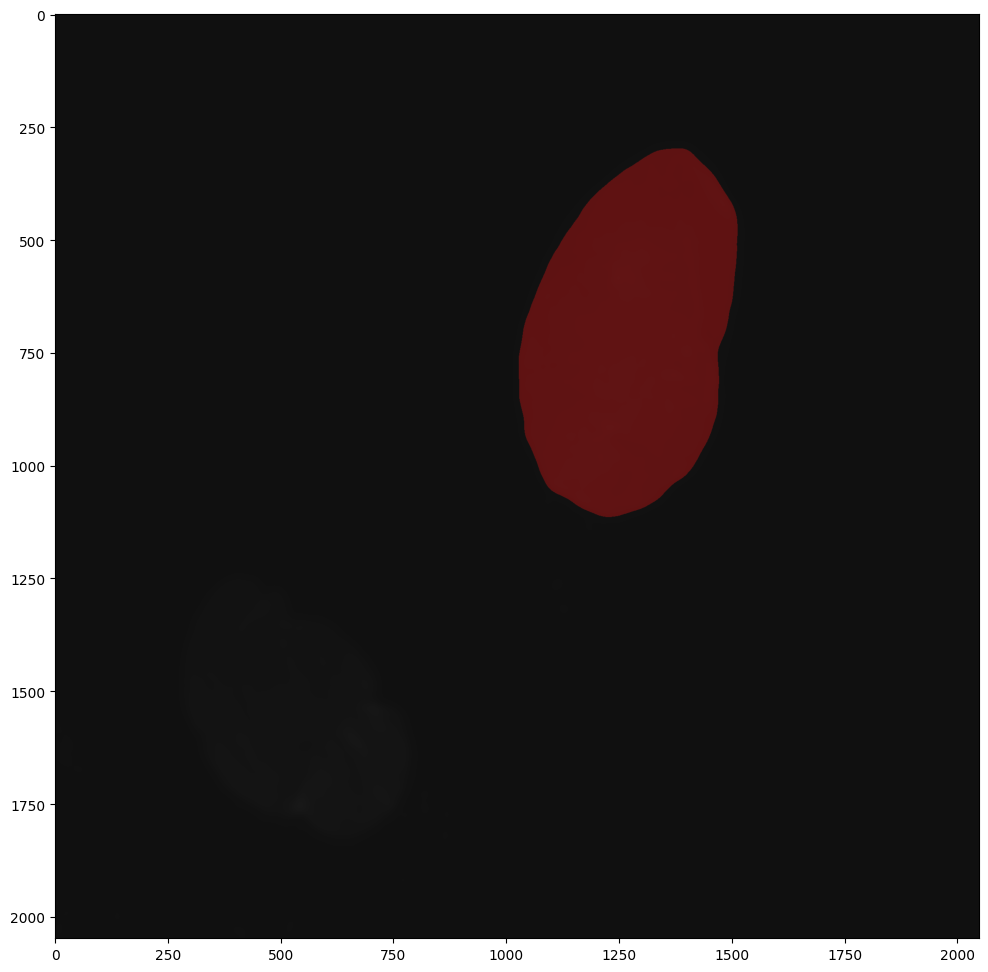

67


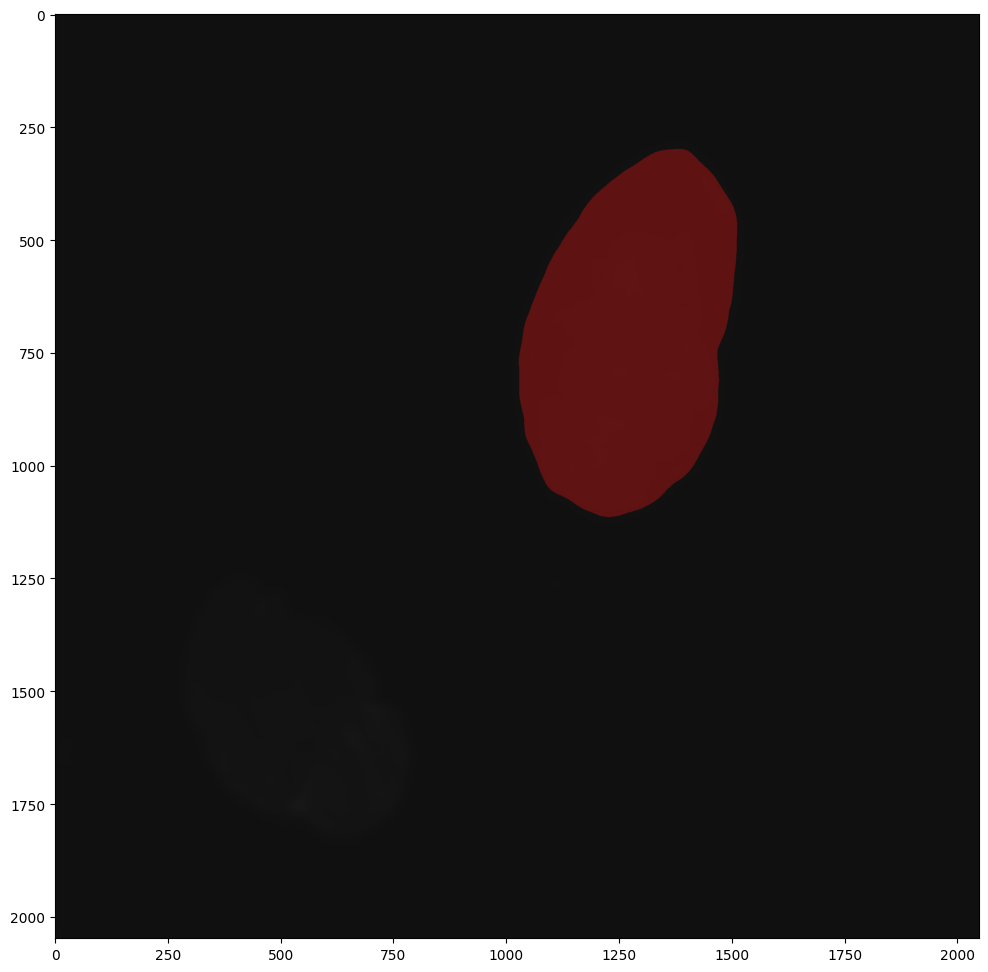

68


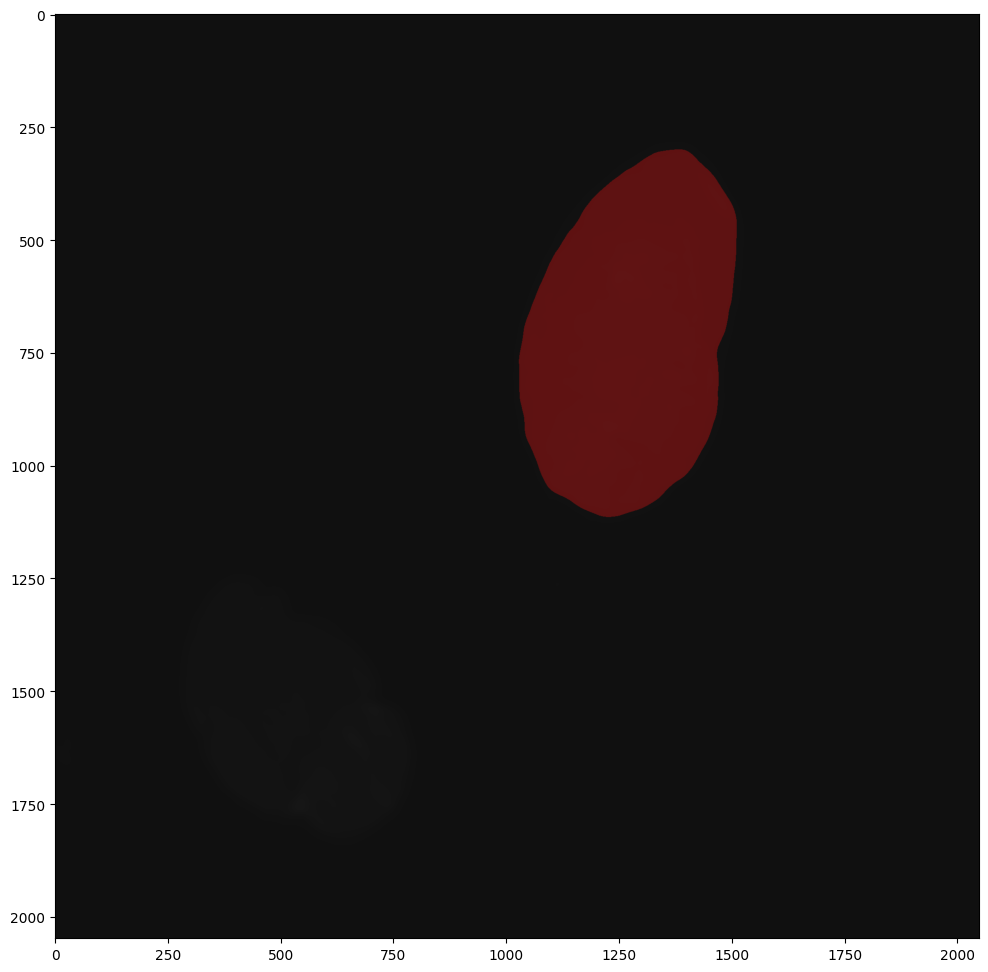

69


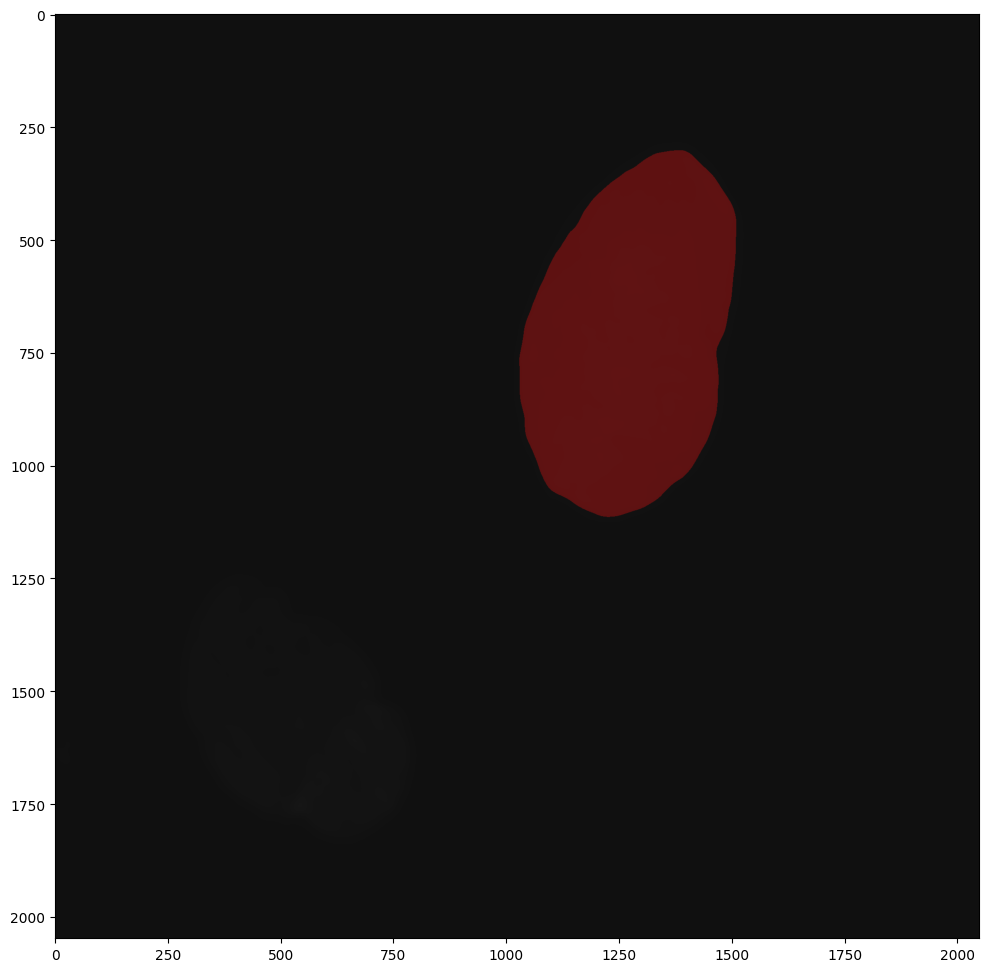

70


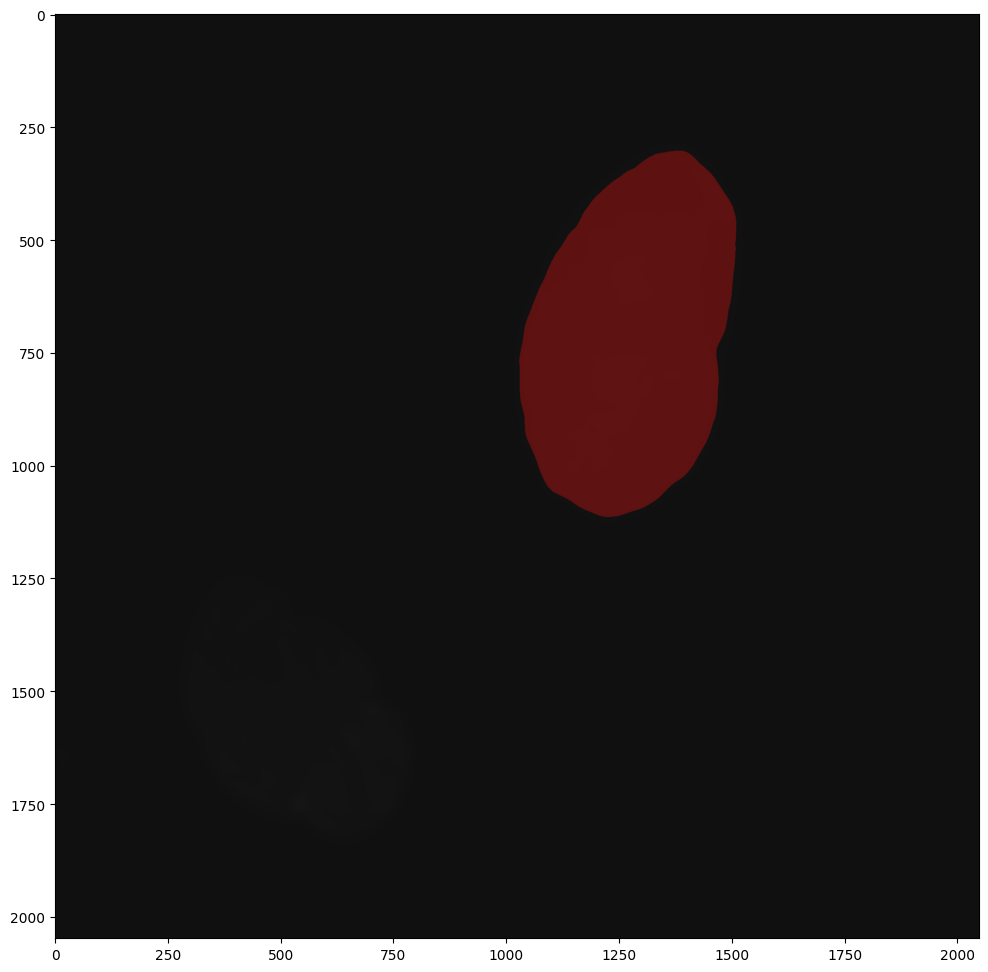

71


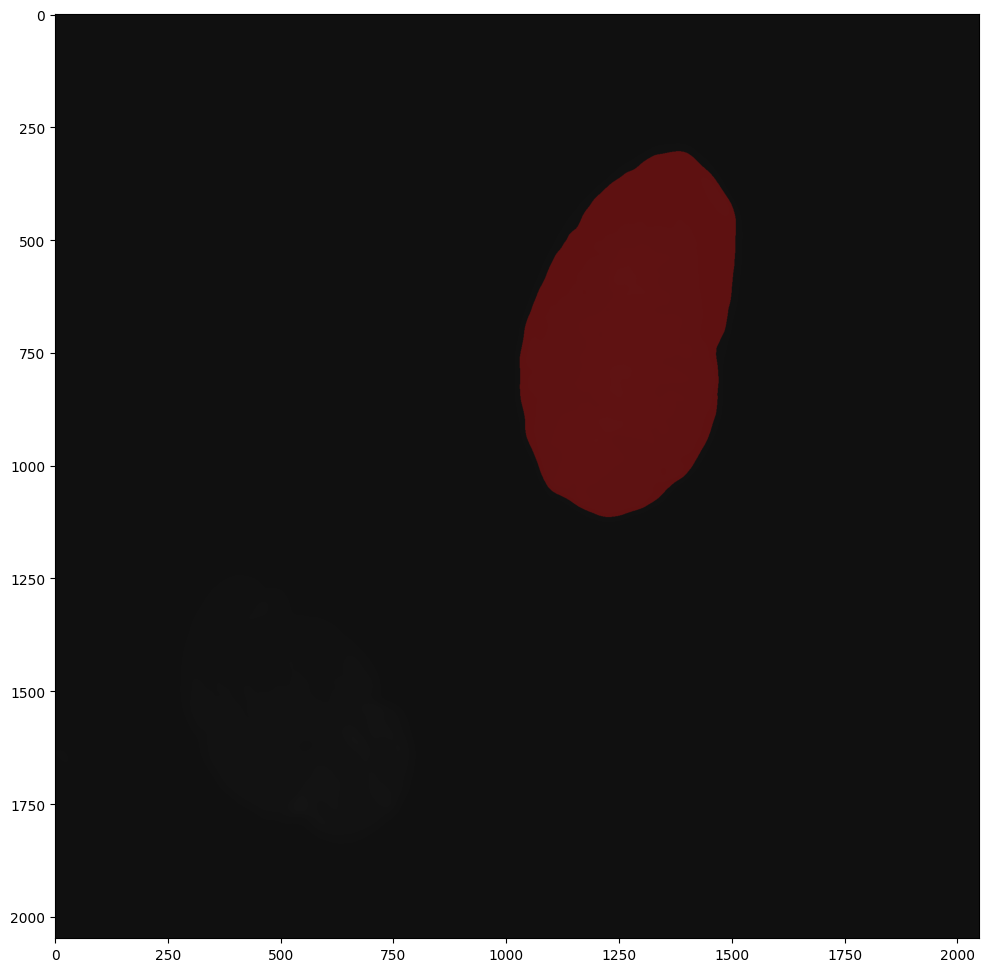

72


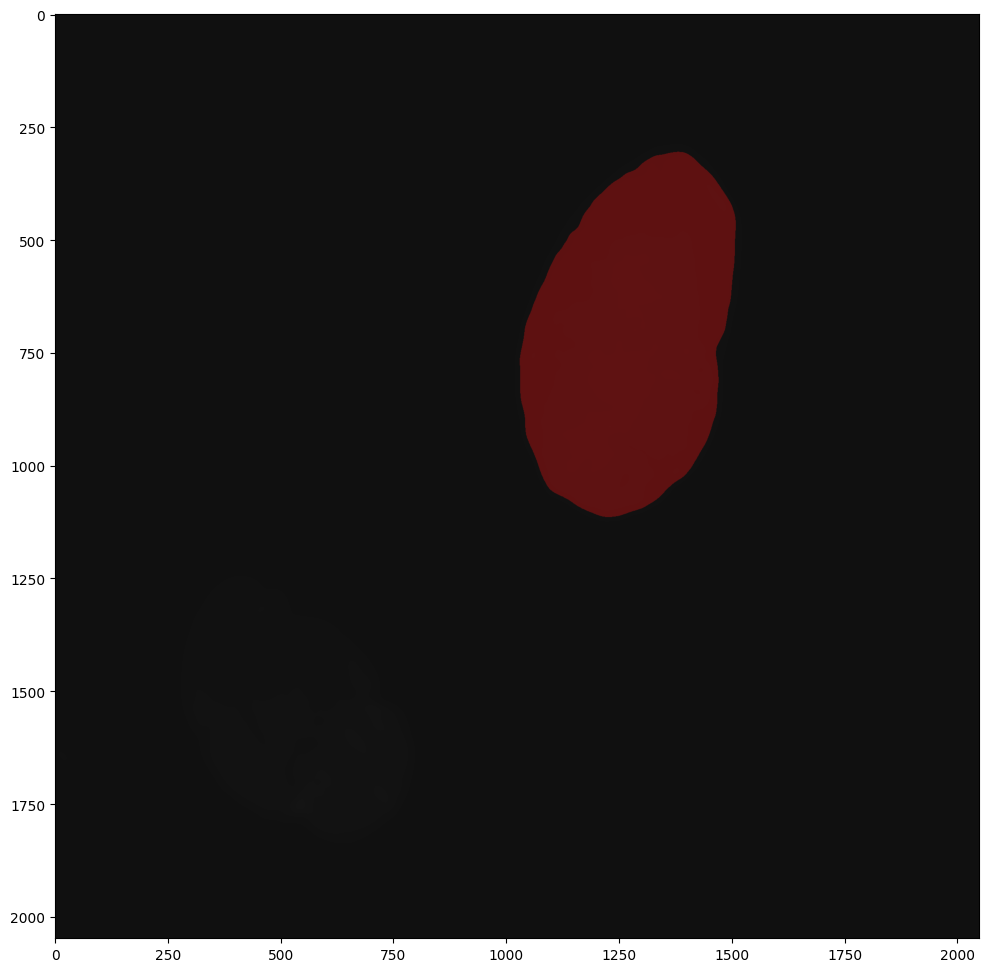

73


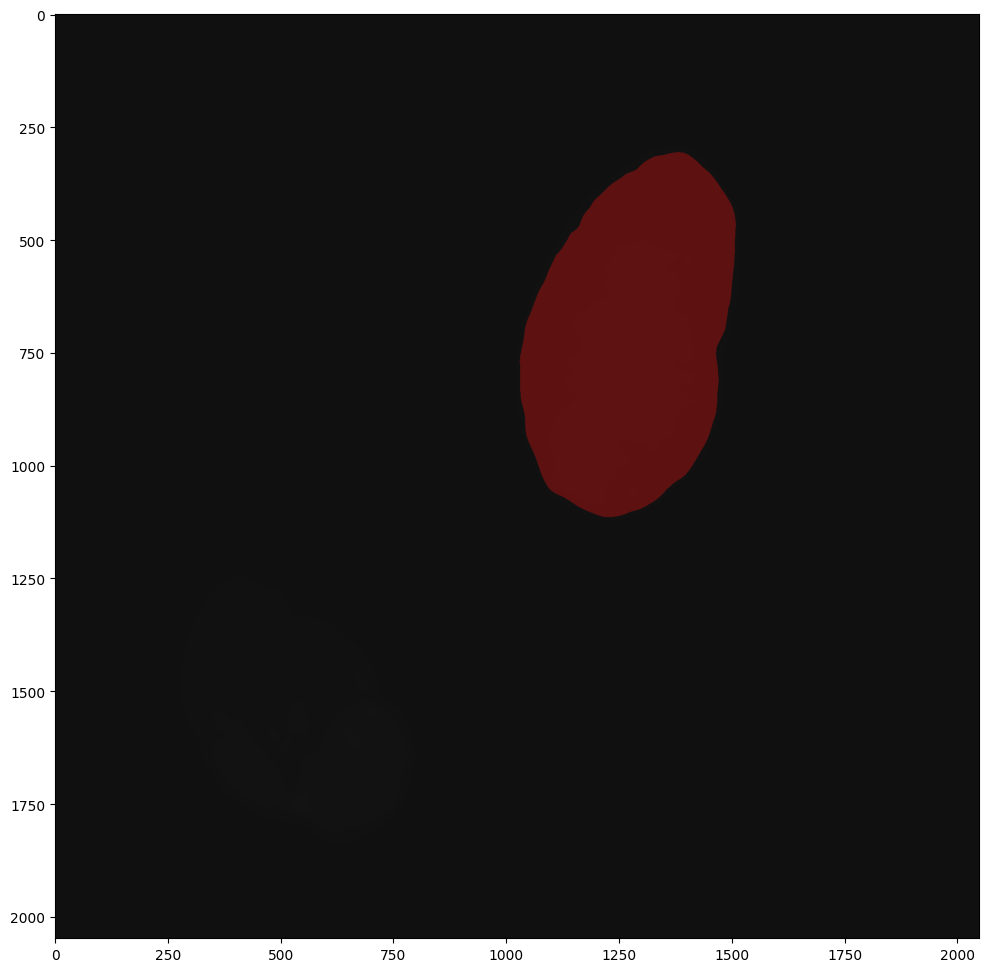

74


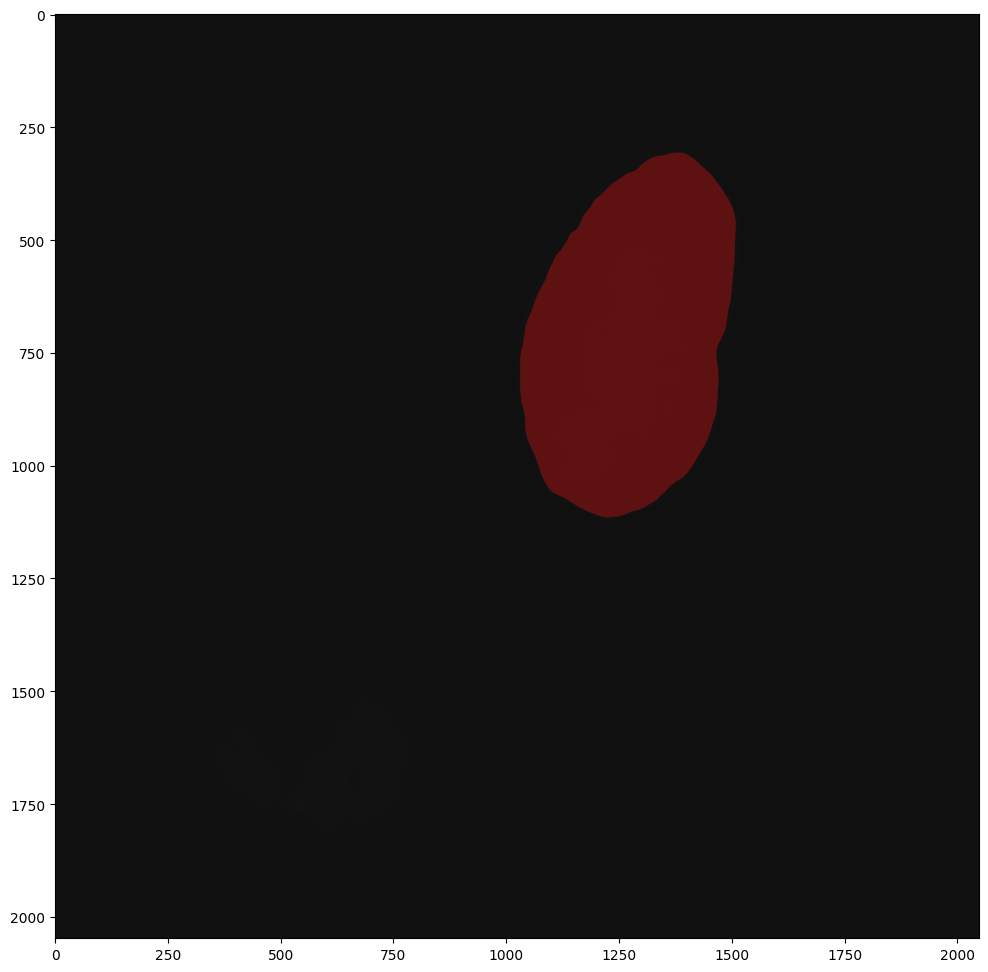

75


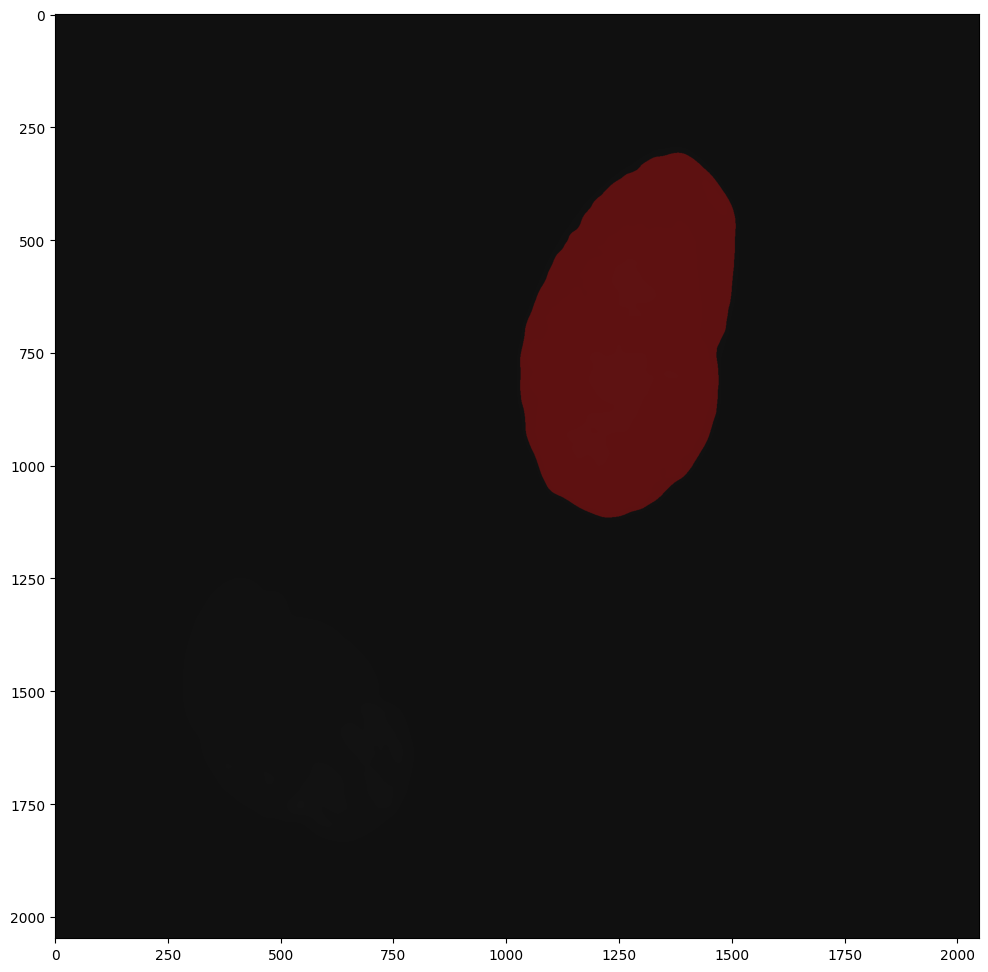

76


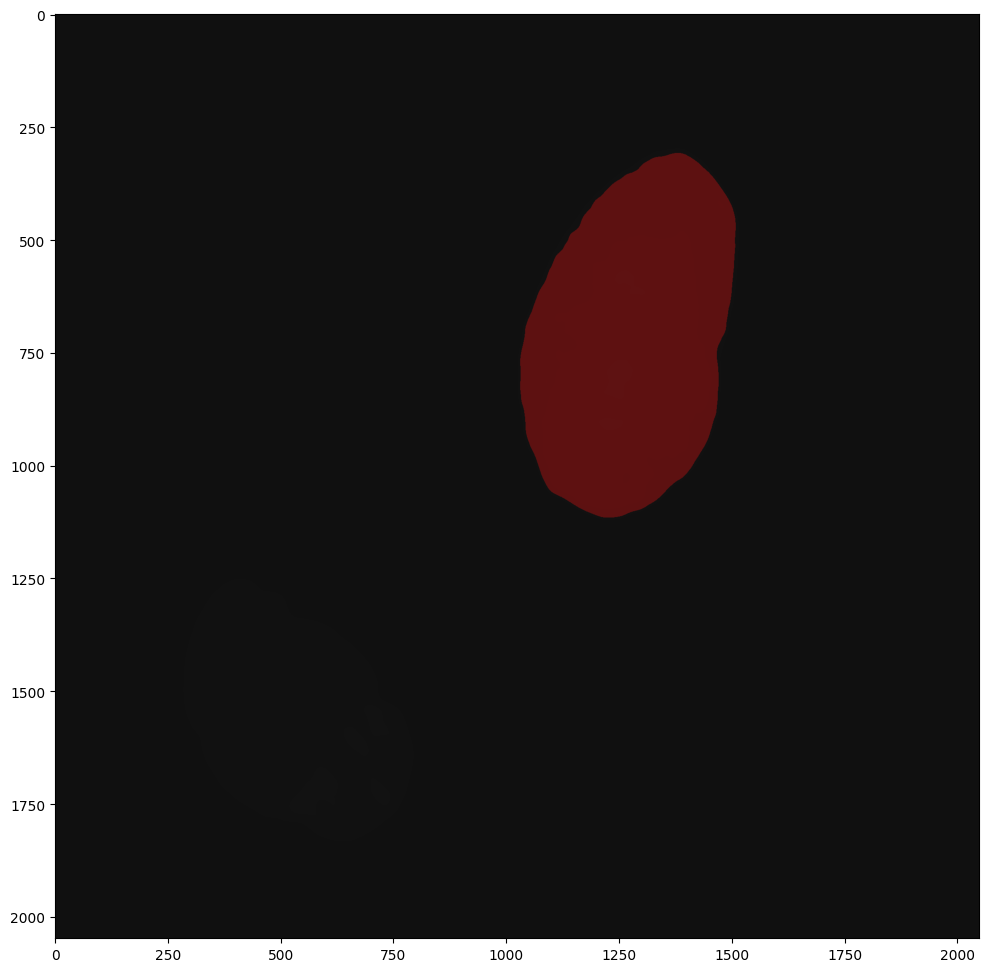

77


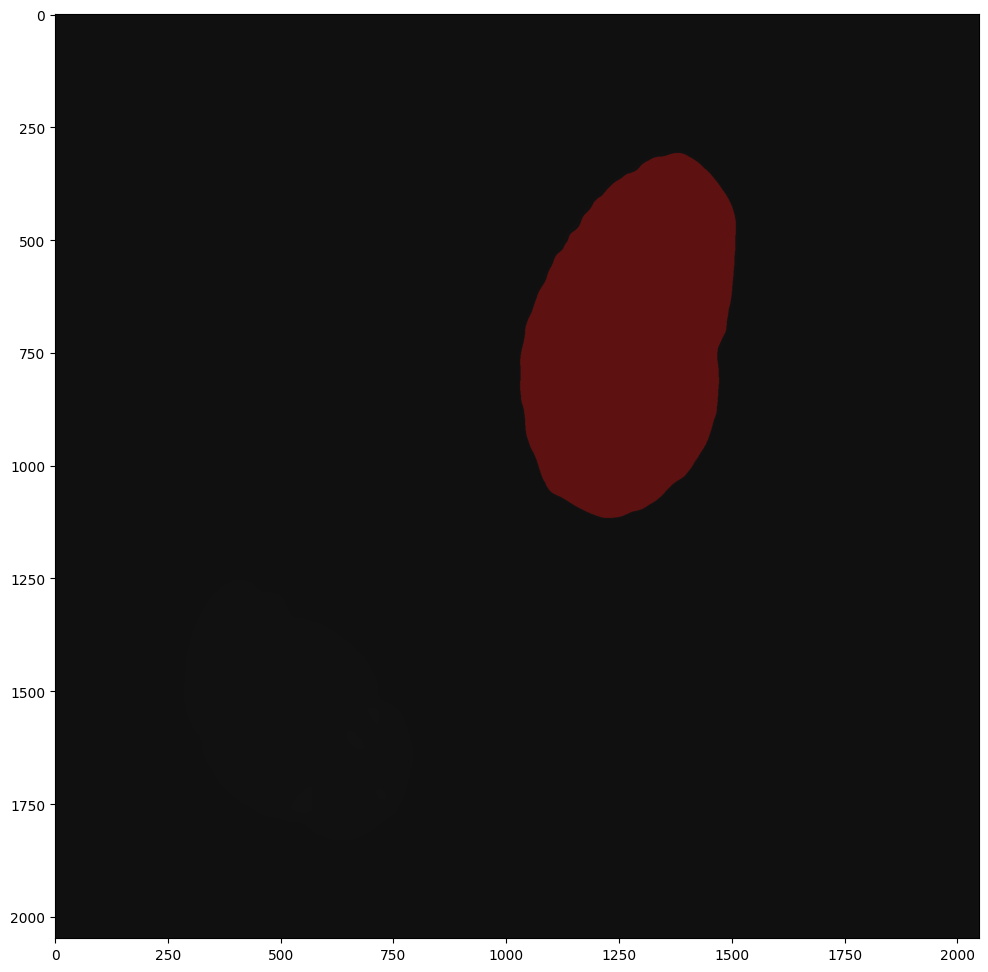

78


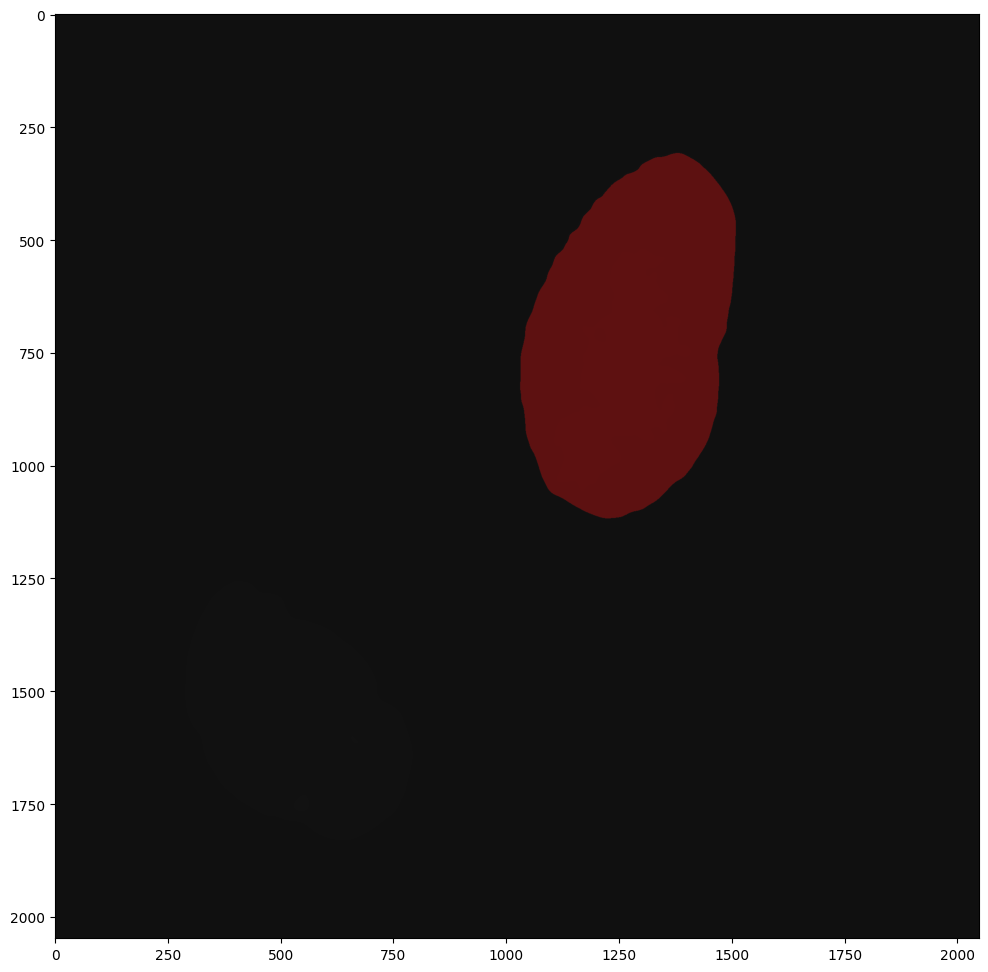

79


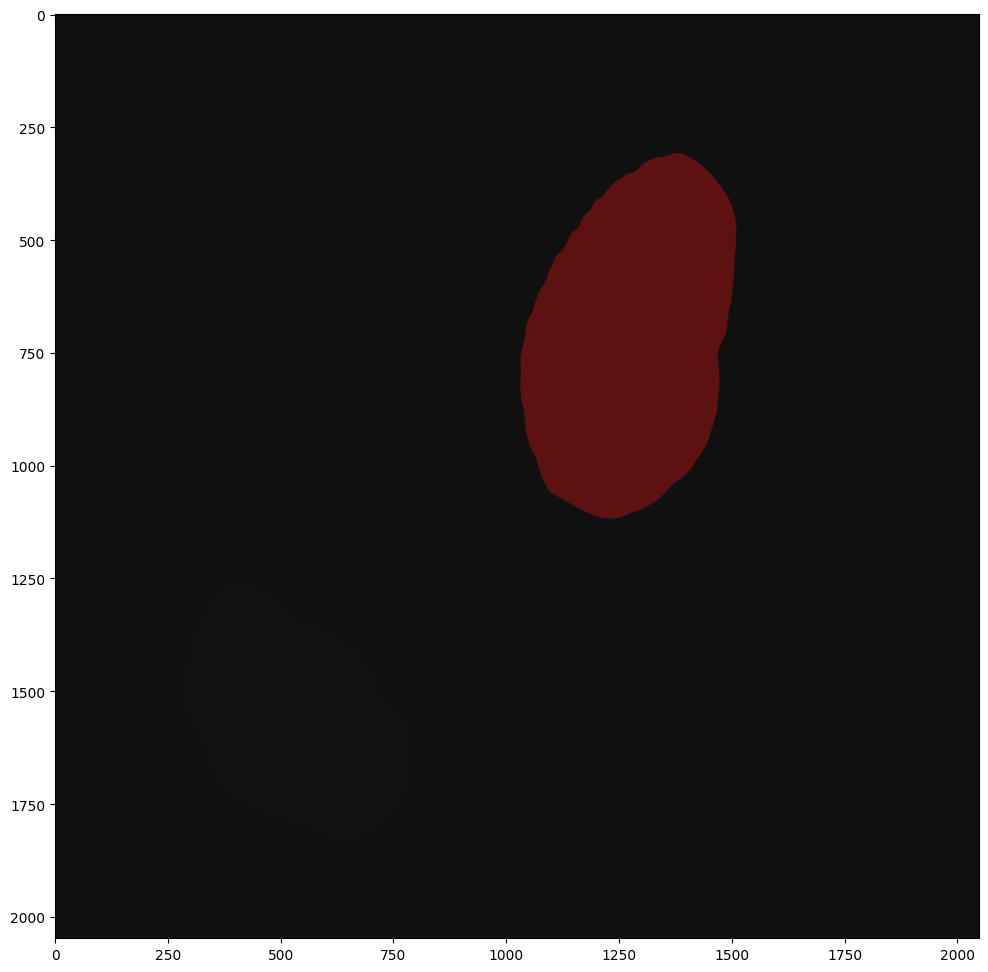

80


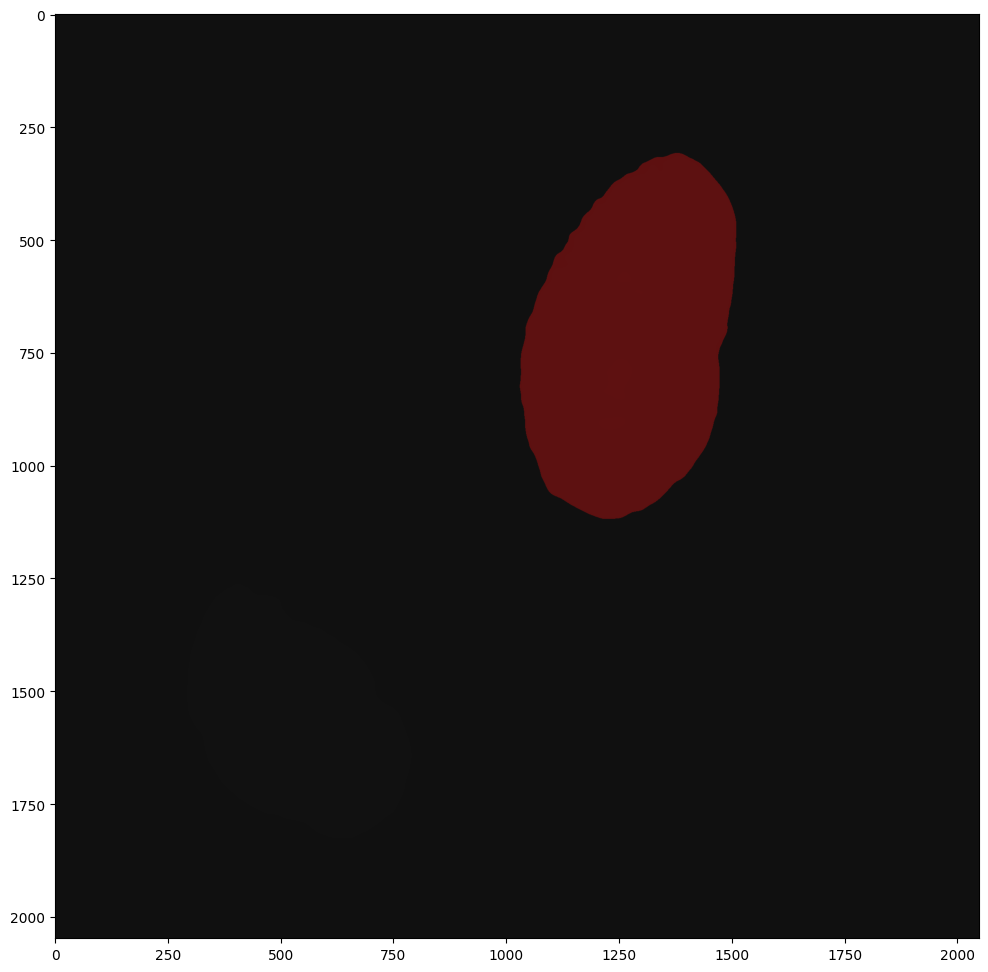

81


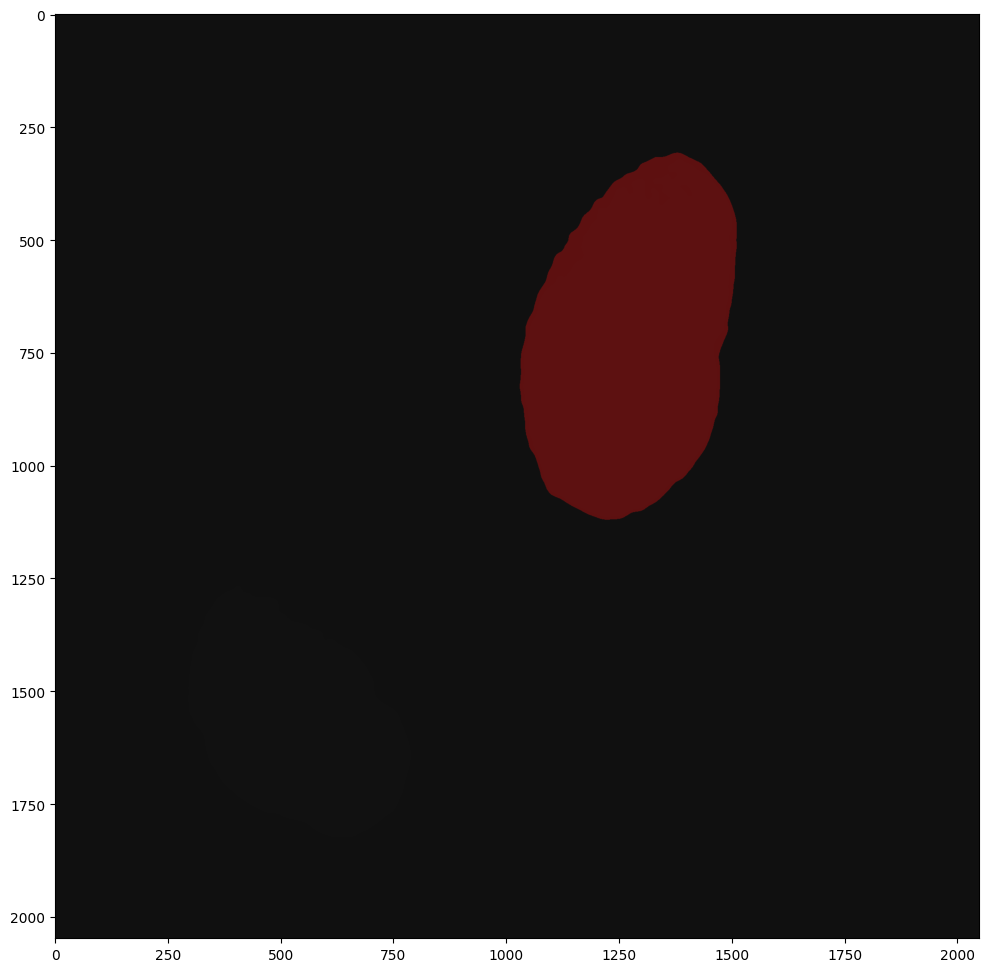

82


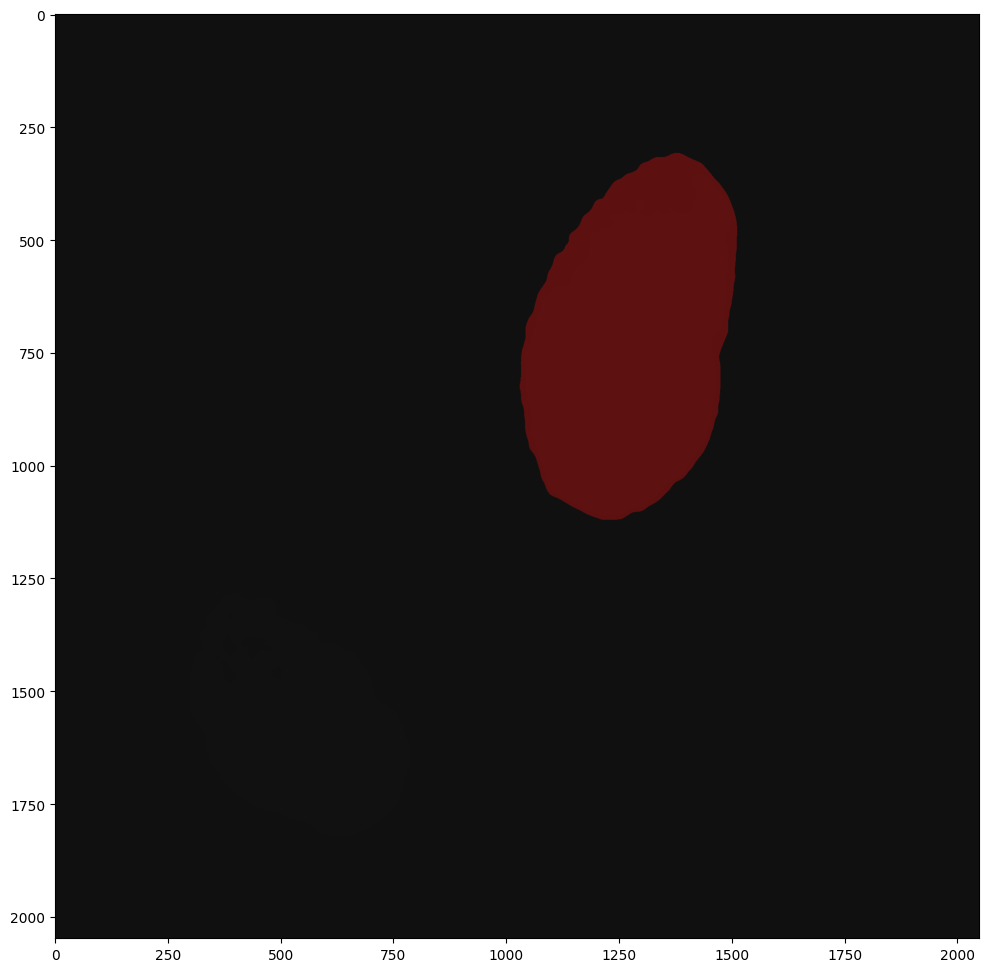

83


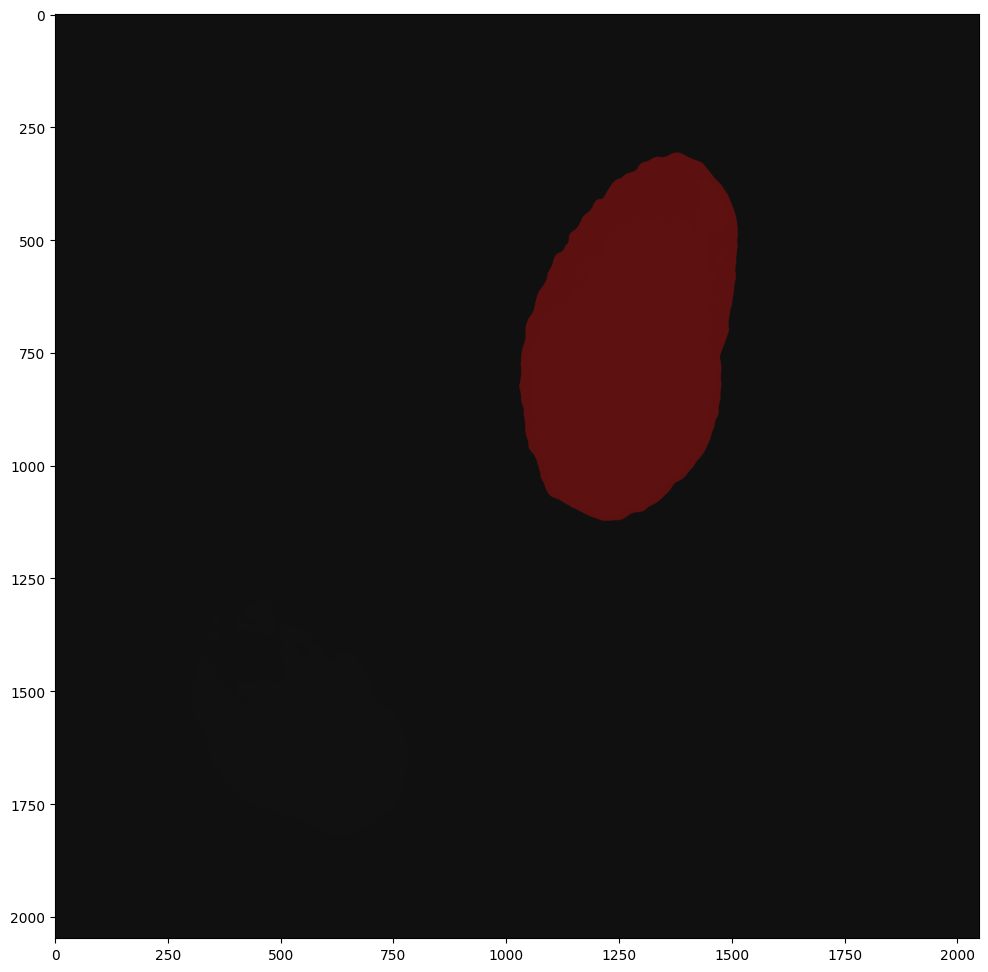

84


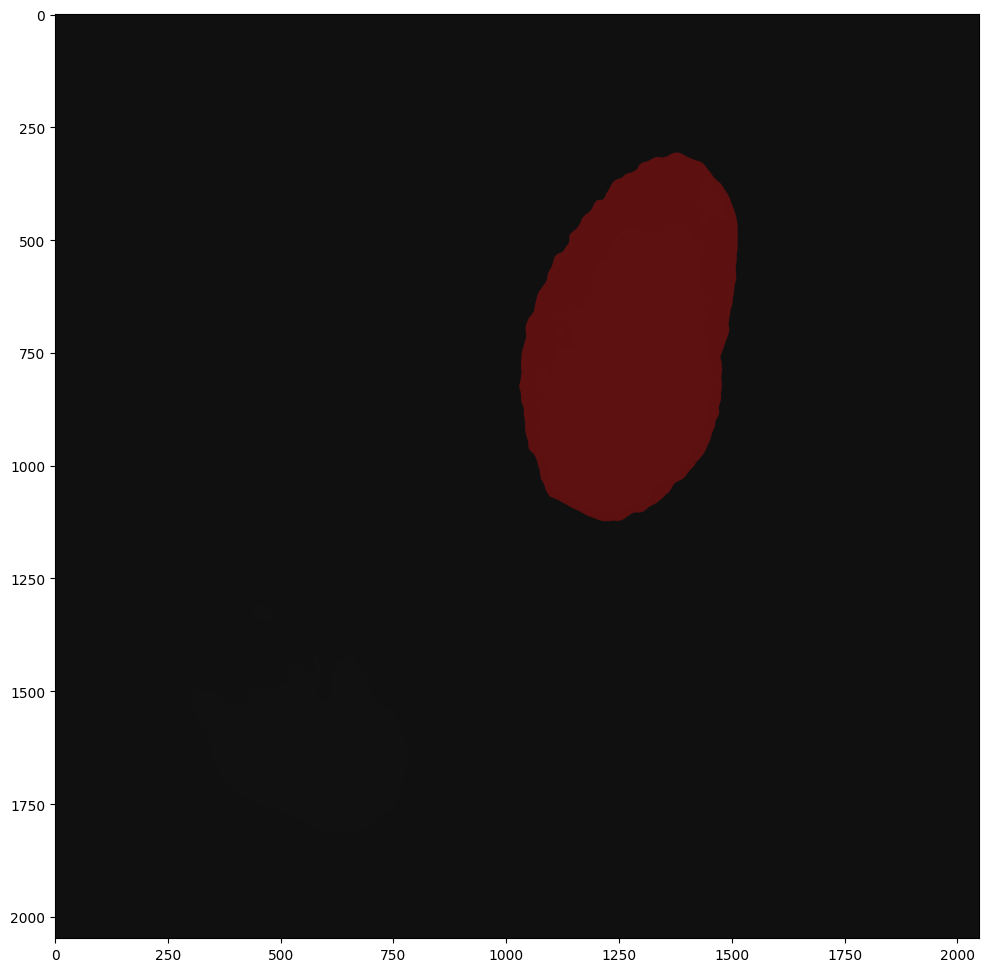

85


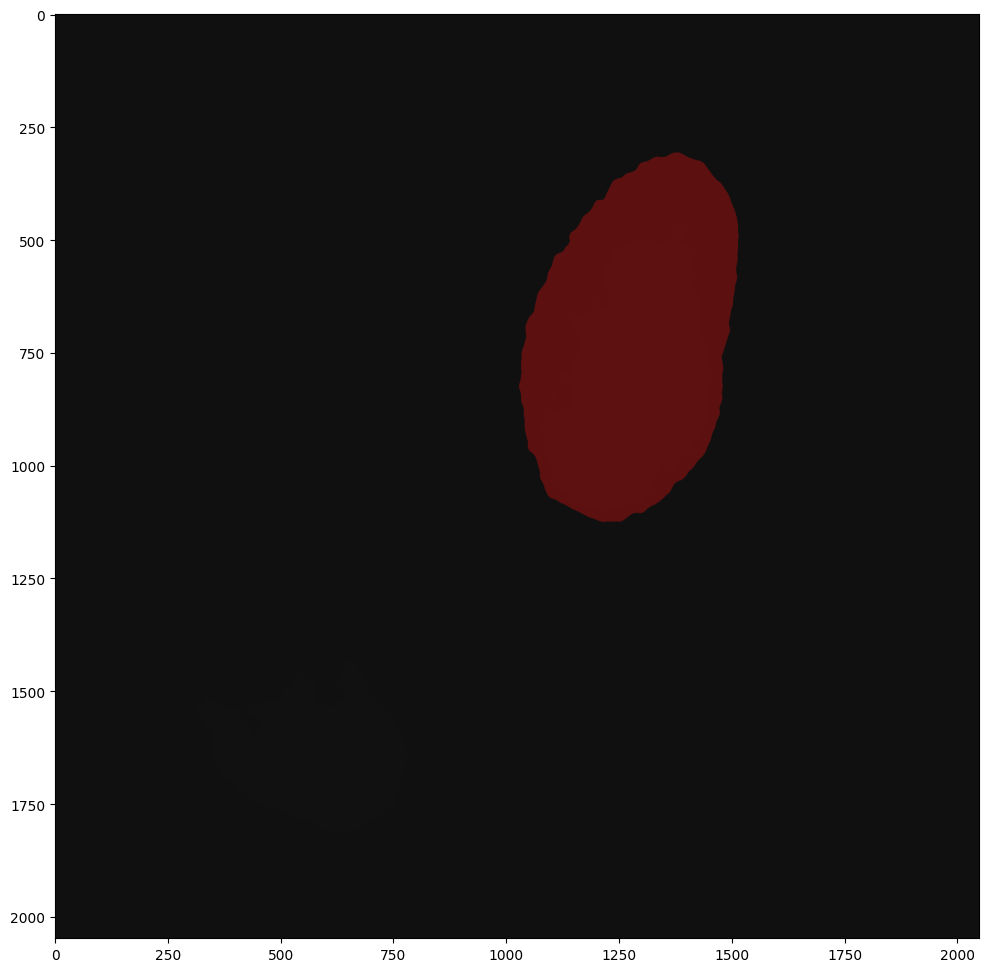

86


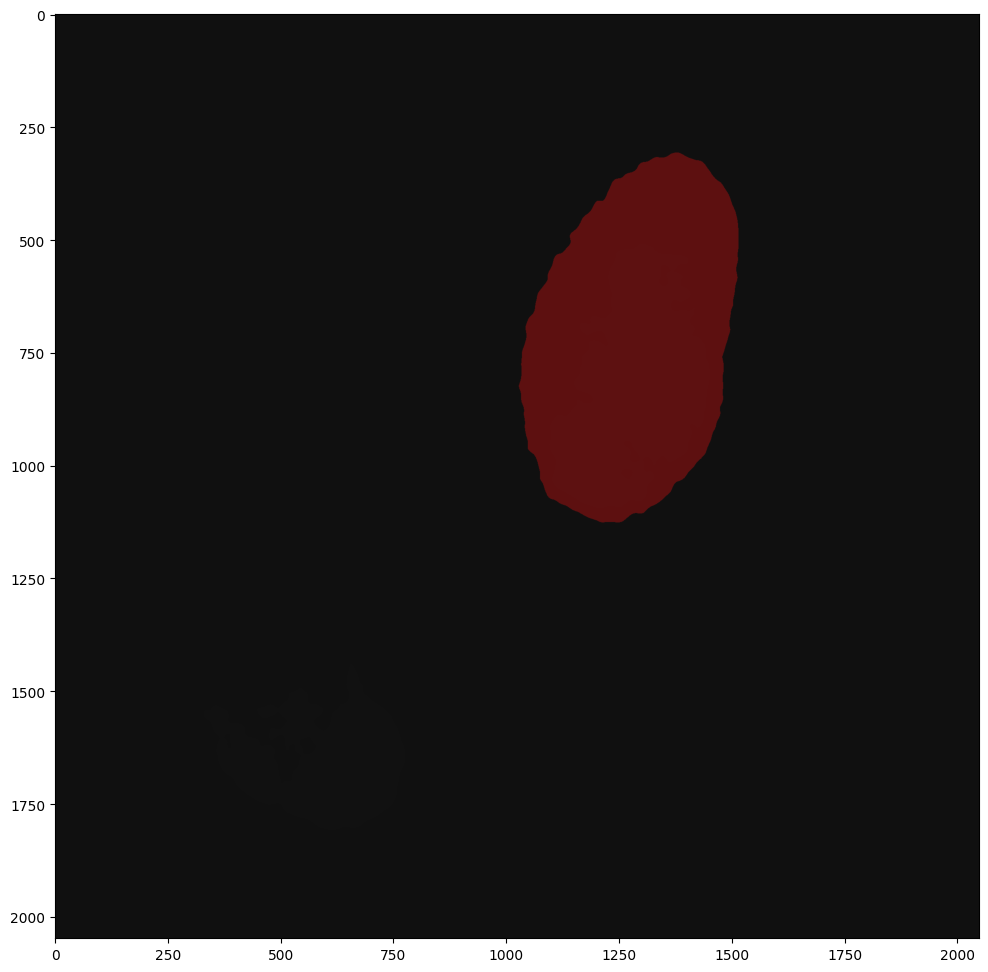

87


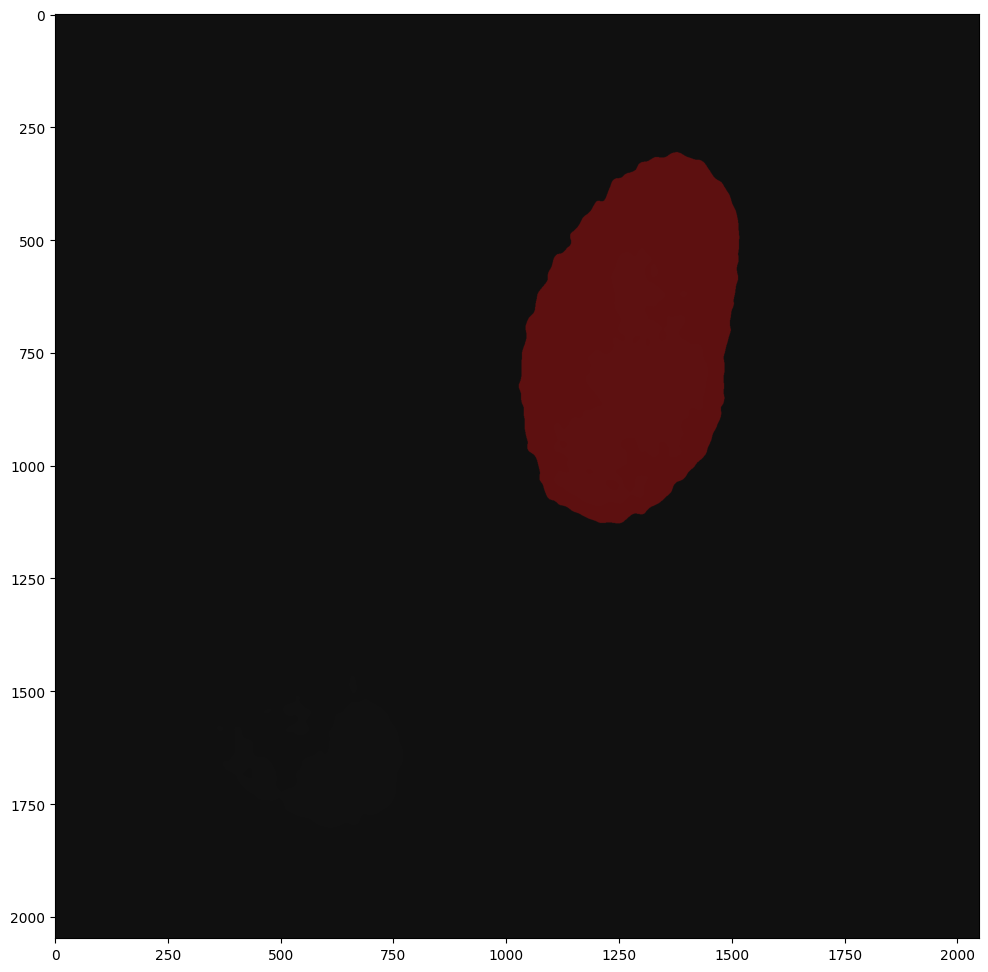

88


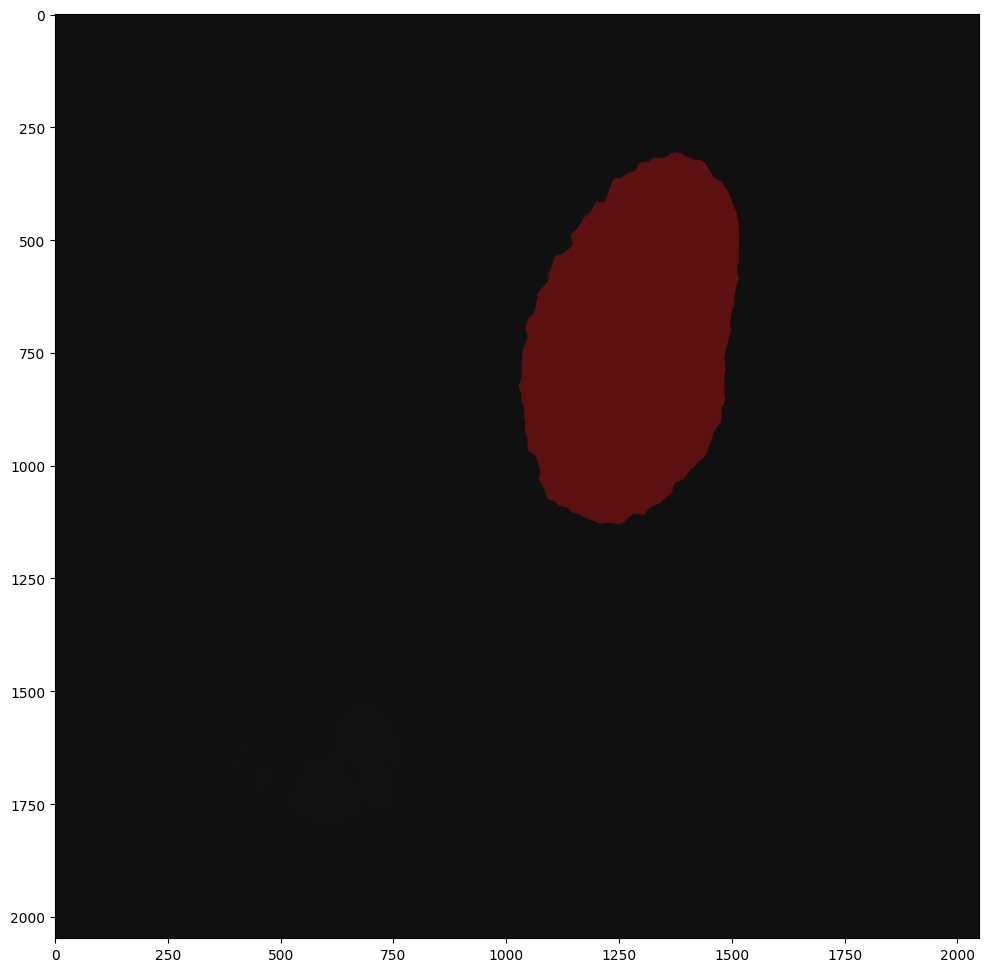

89


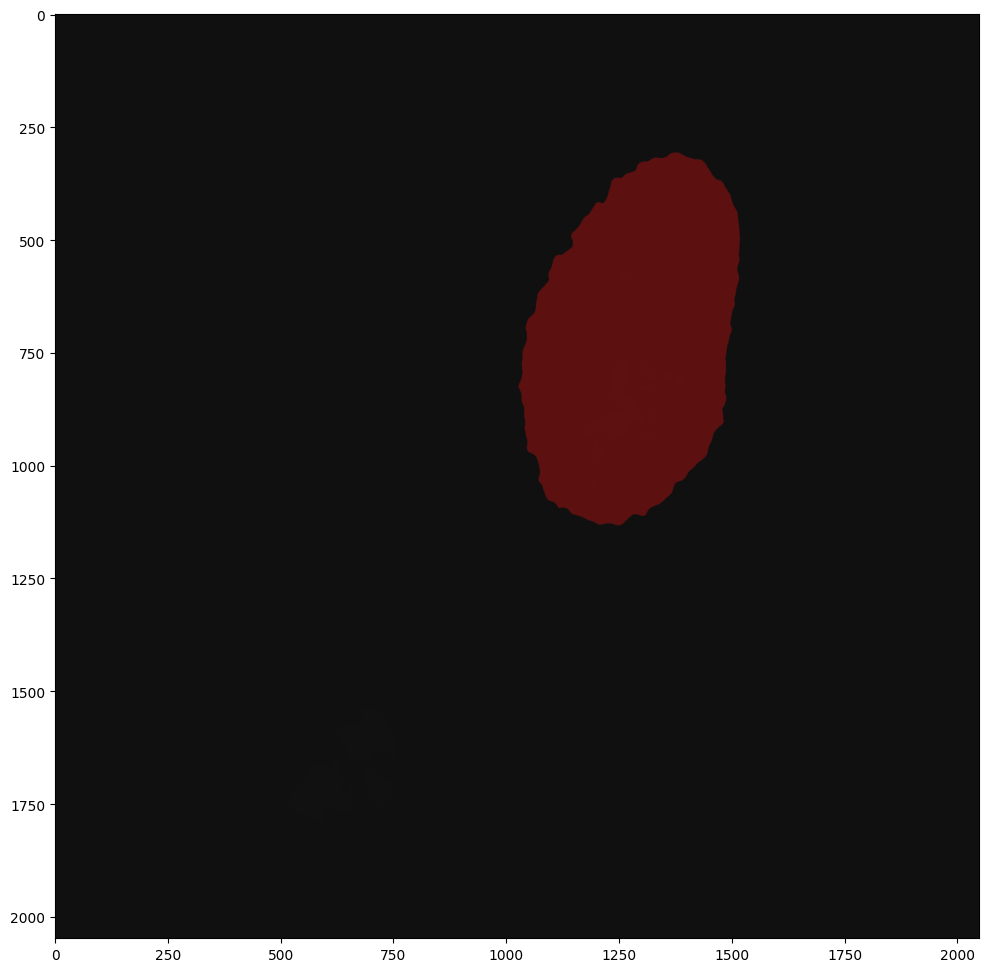

90


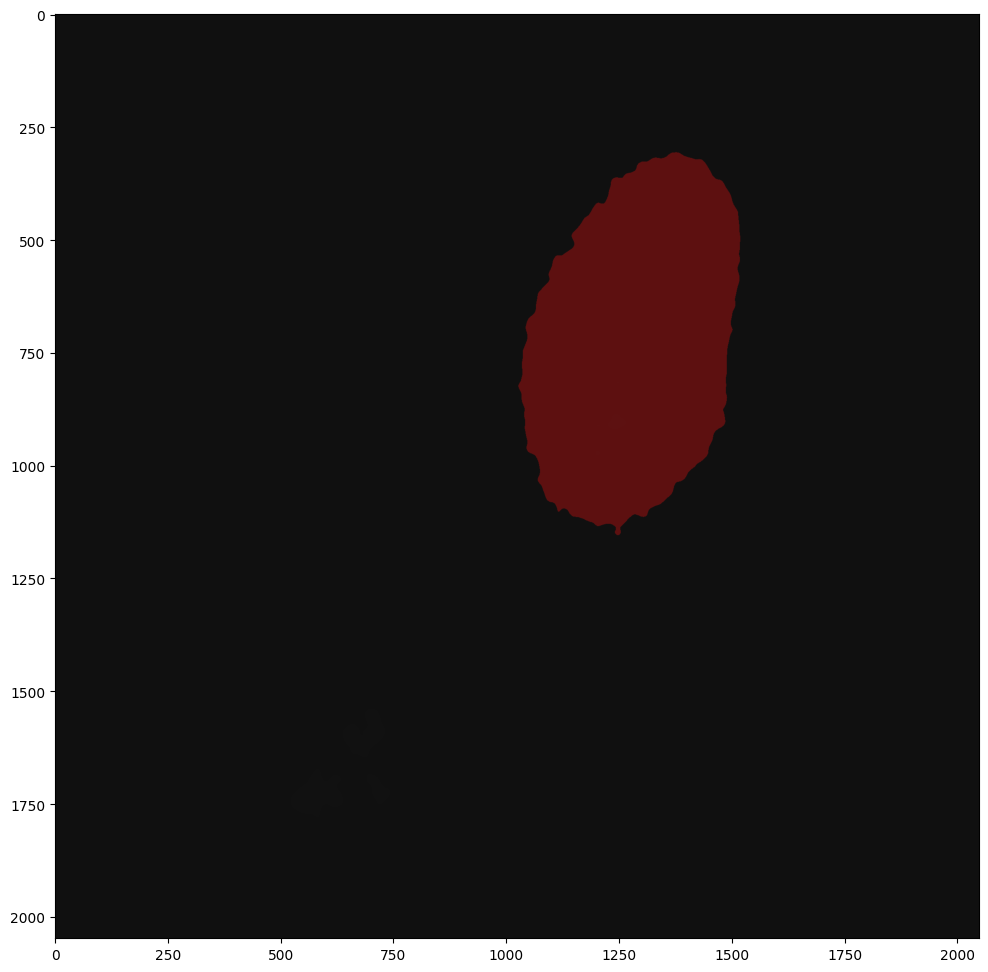

91


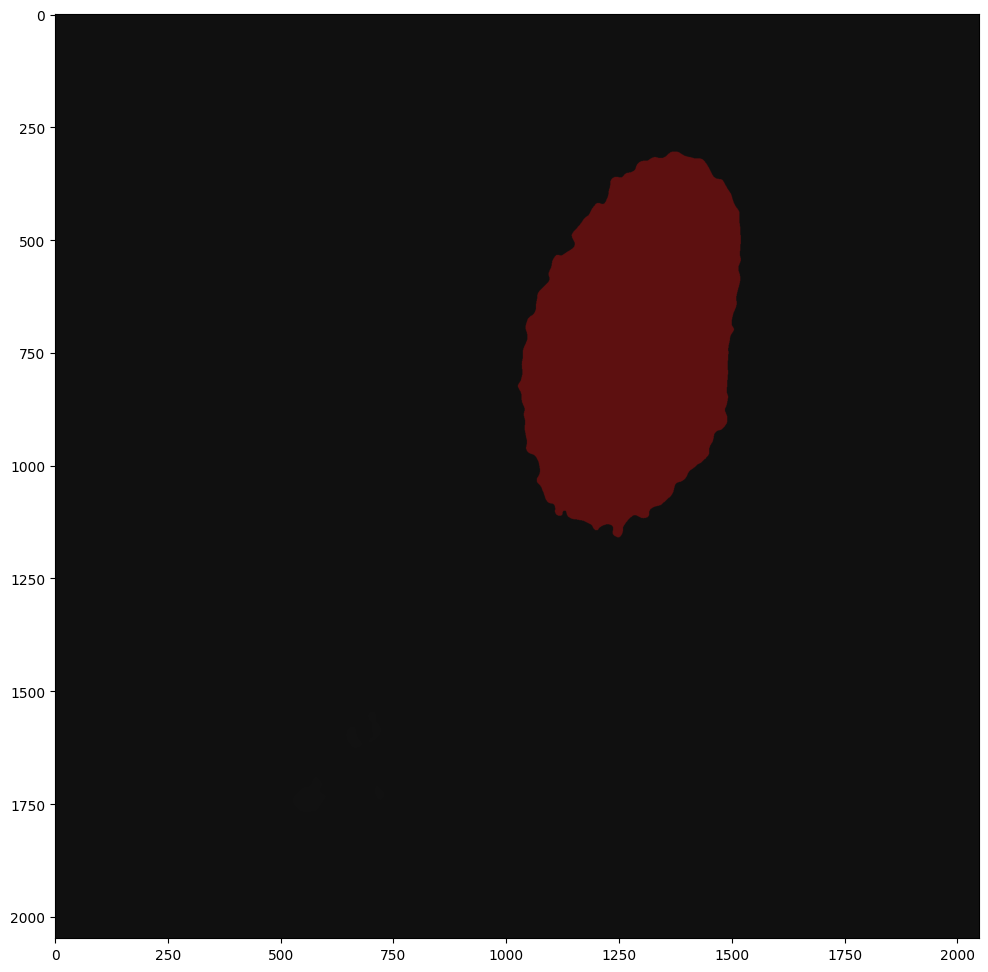

92


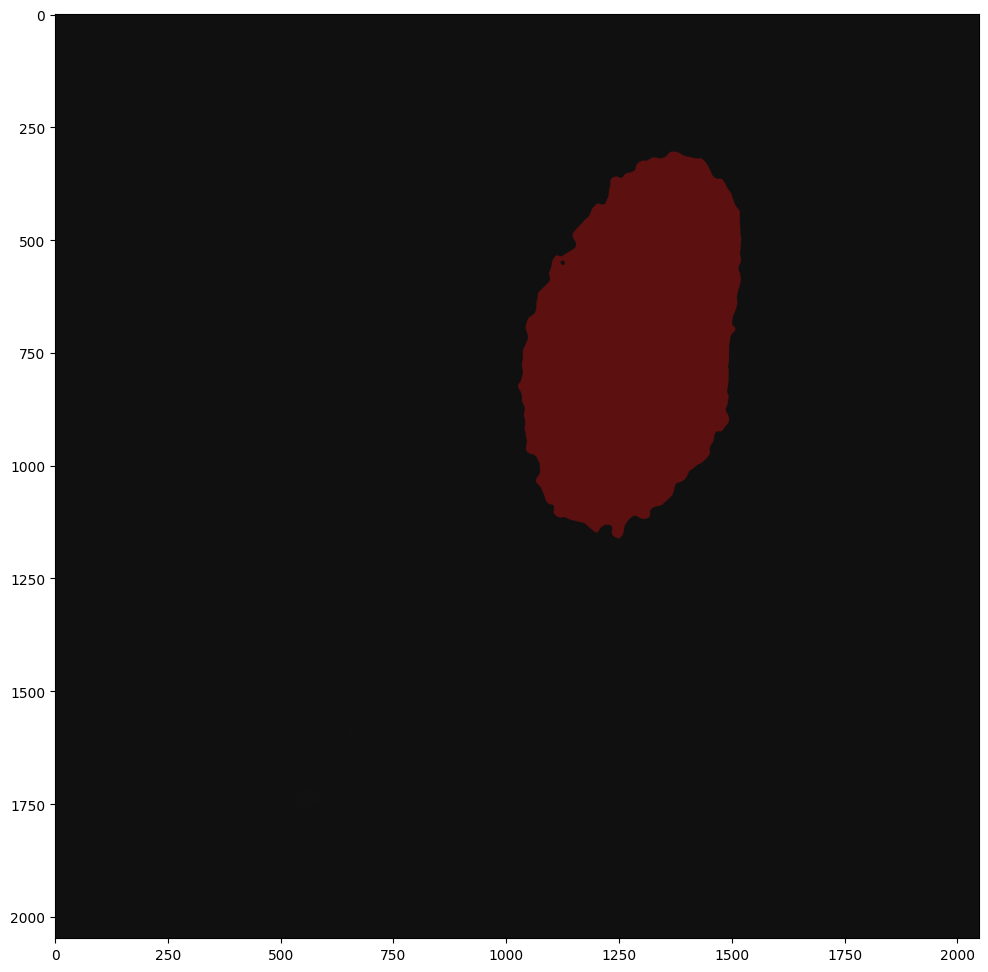

93


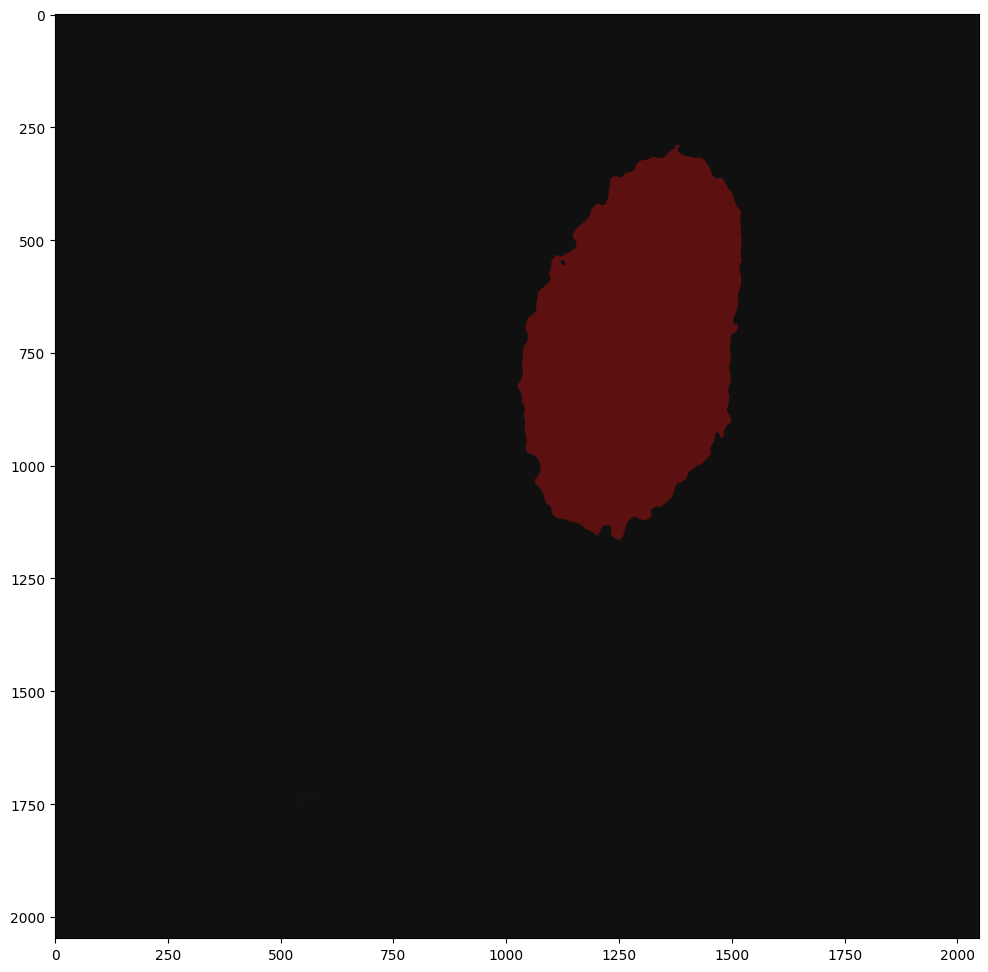

94


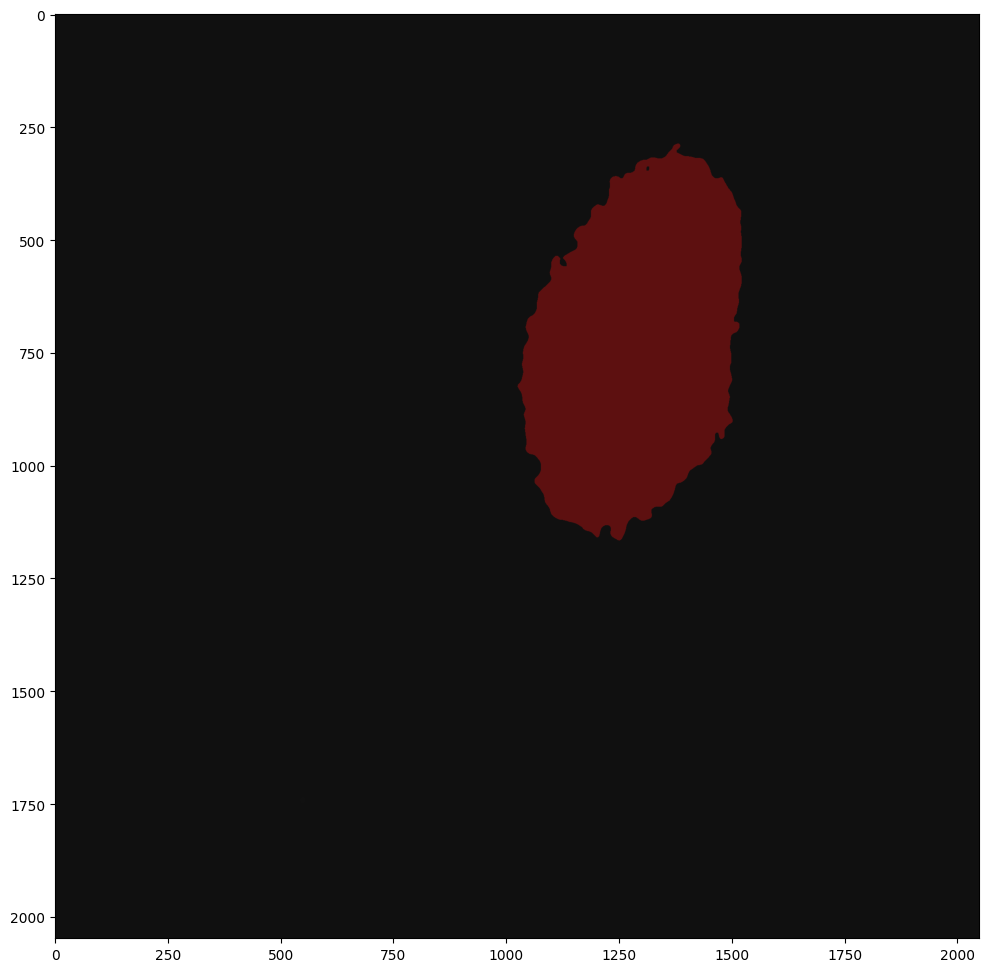

95


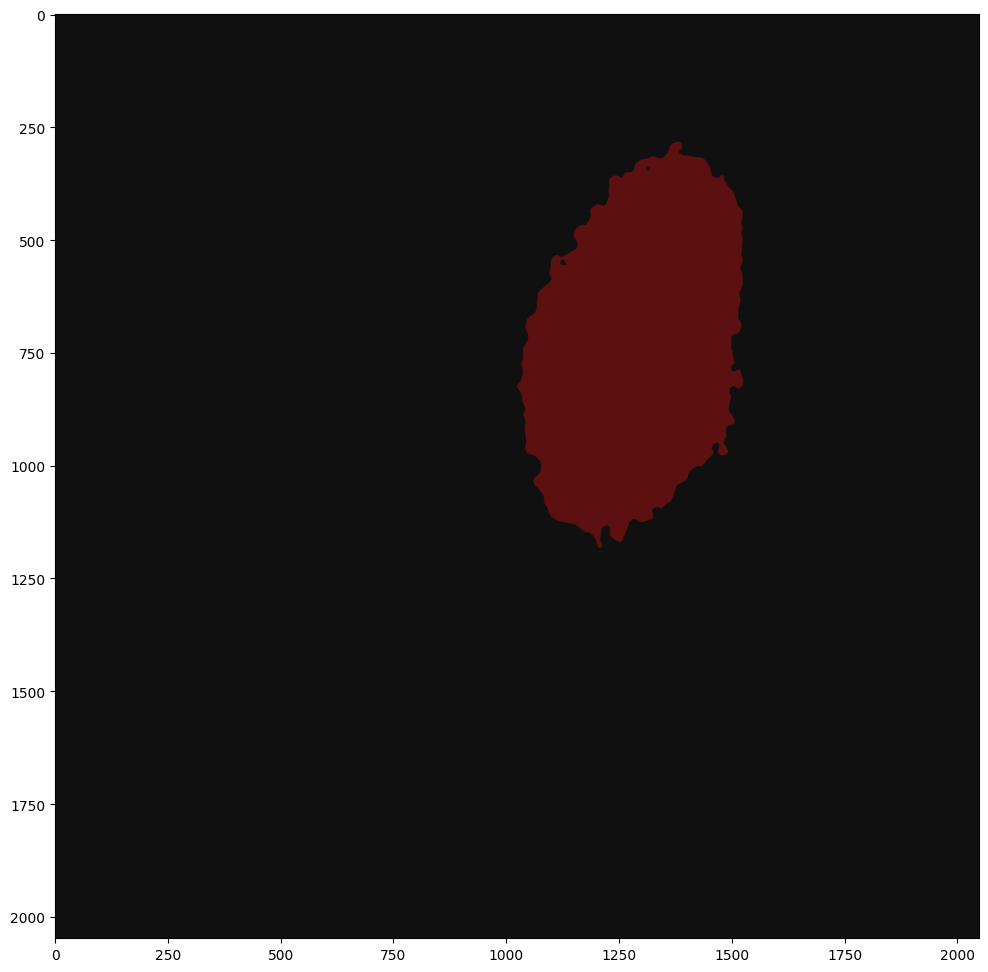

96


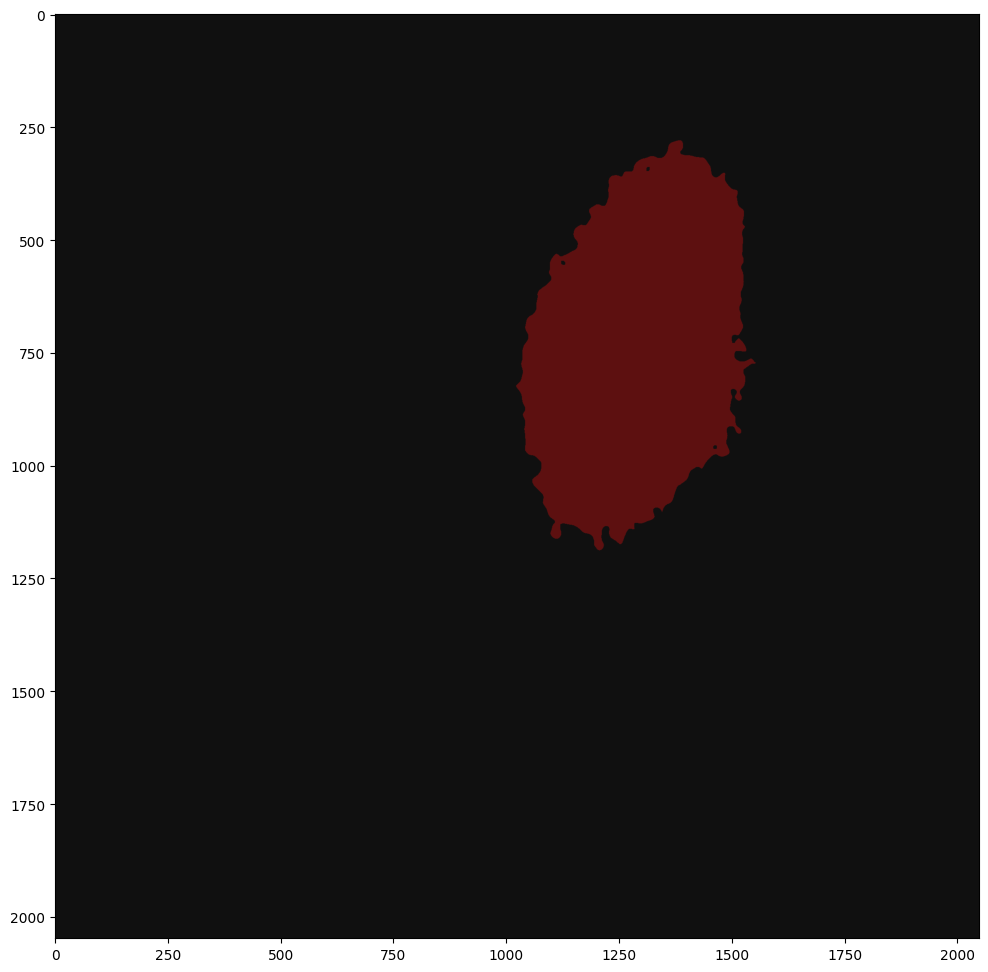

97


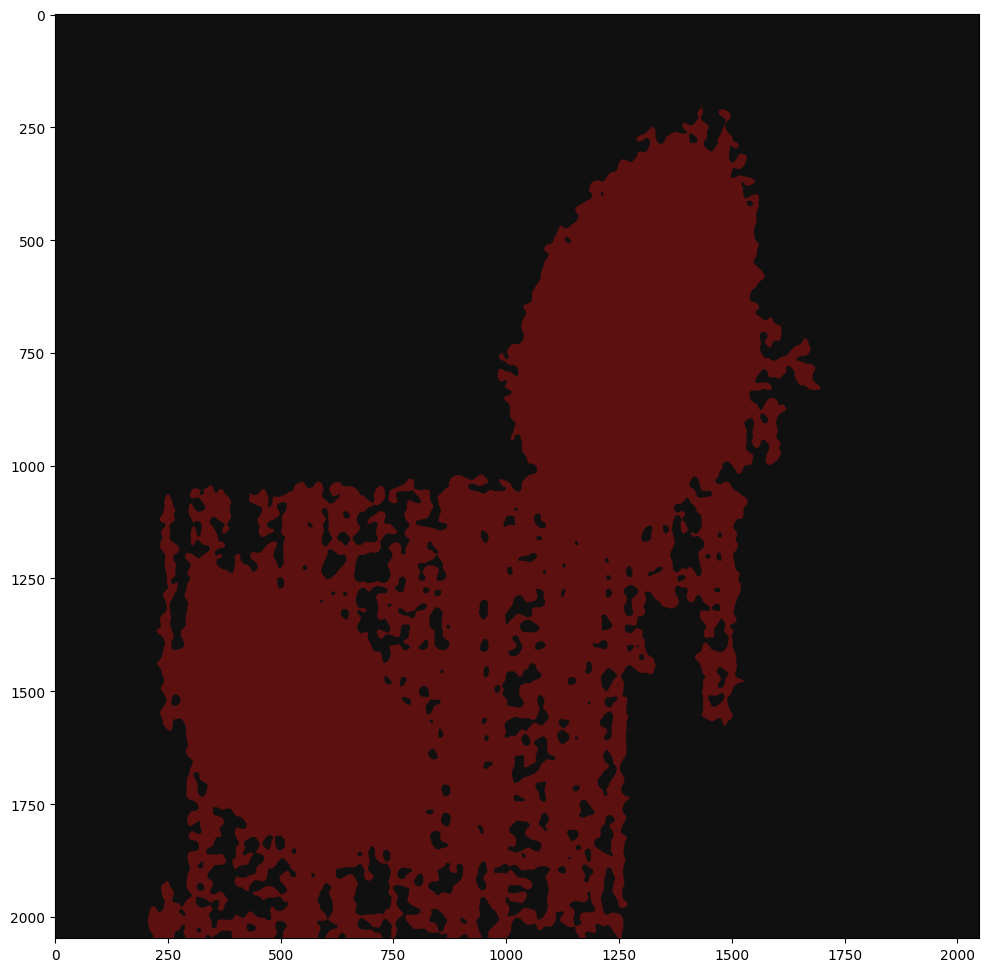

98


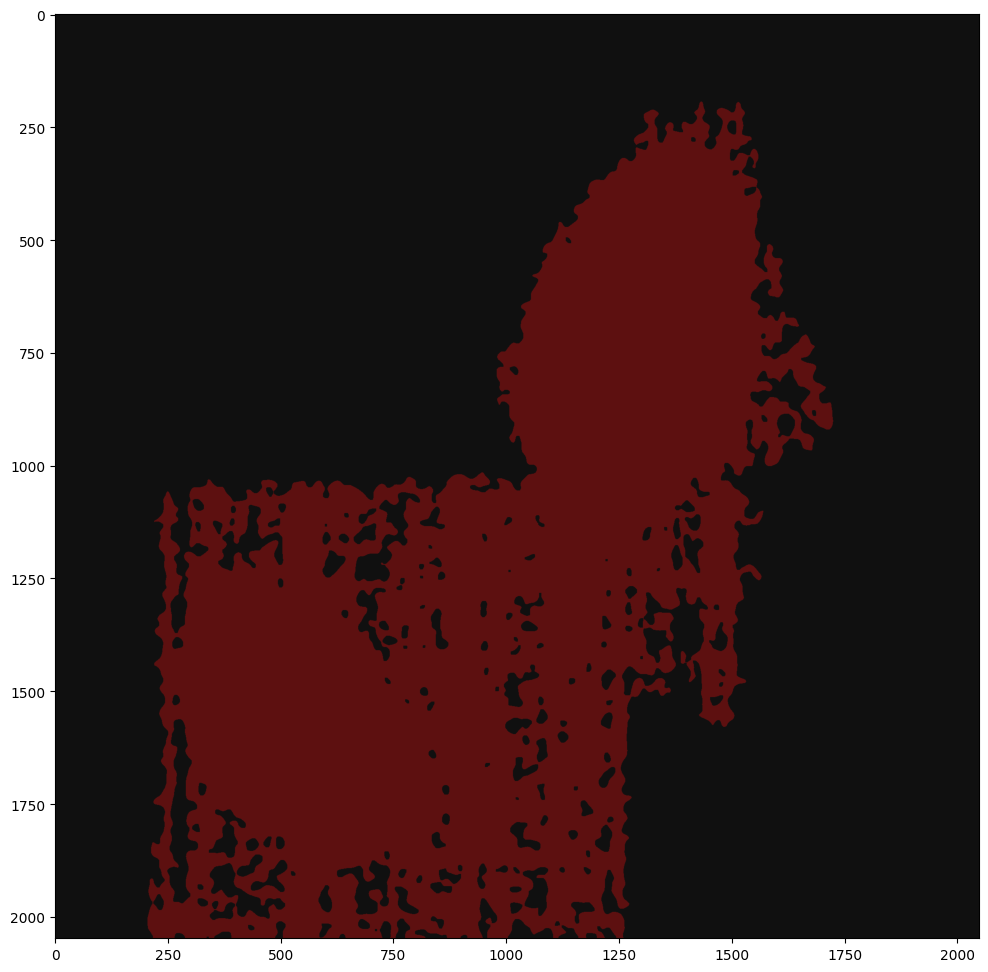

99


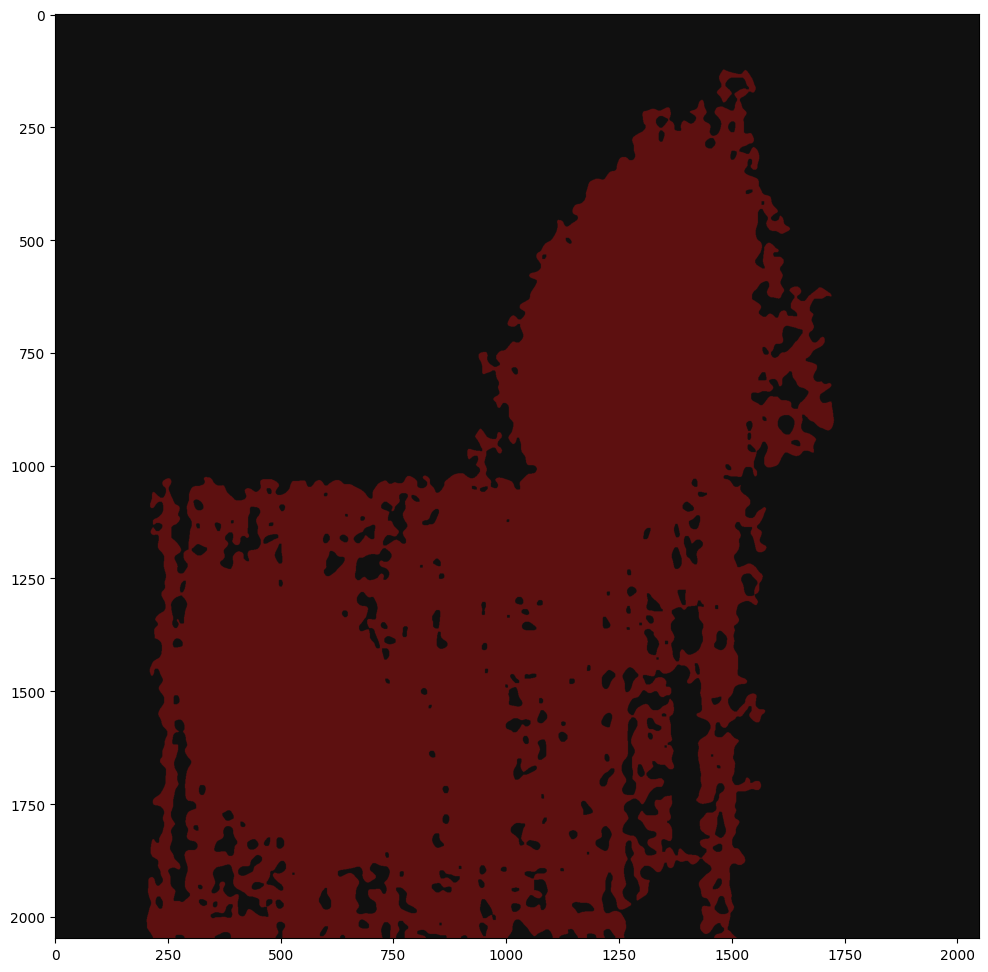

100


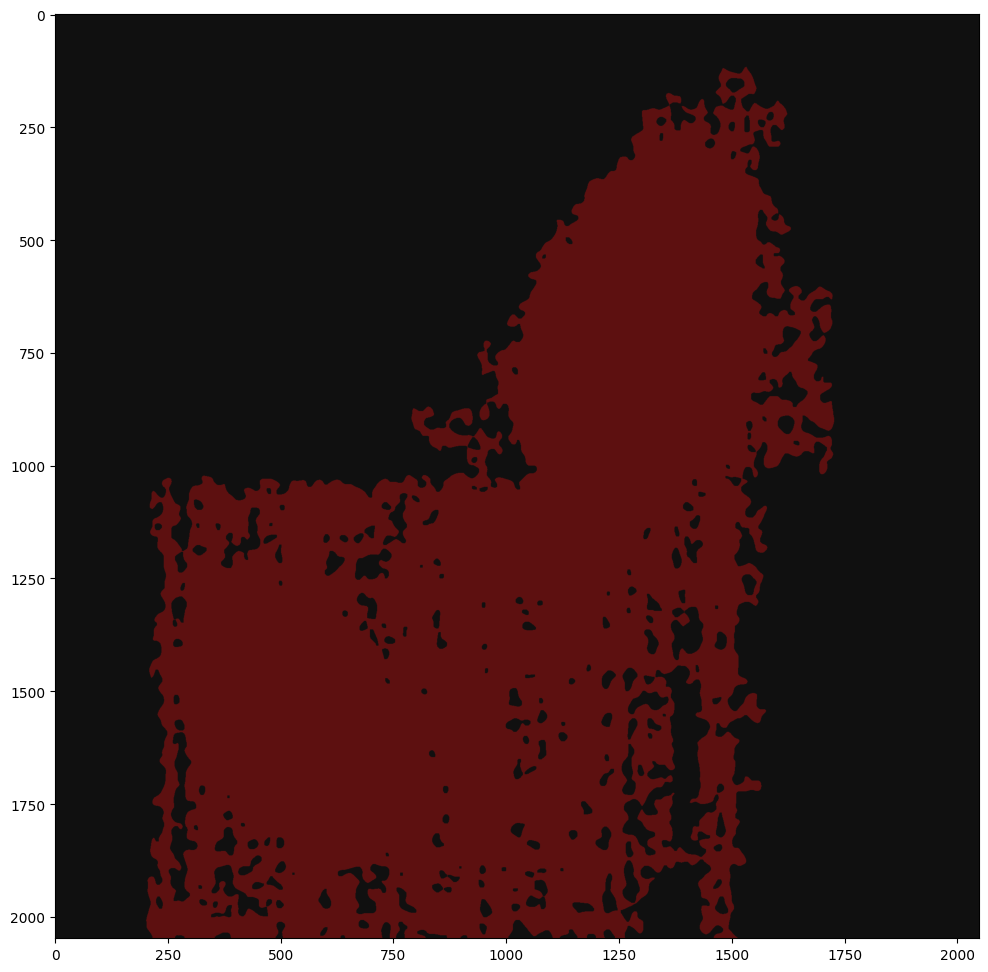

In [9]:
from skimage.exposure import histogram
from skimage.feature import canny
import scipy
from skimage.morphology import closing, square
from skimage.color import label2rgb

binary_mask = np.zeros(np.shape(c2))
# 
for i in range(np.shape(c2)[0]):
    print(i)
    thresh = skimage.filters.threshold_otsu(structure_img_smooth[i])
    binary = structure_img_smooth[i] > thresh
    bw = closing(binary, square(5))
    labeled,_ = scipy.ndimage.label(bw)
    region_table = pd.DataFrame.from_dict(skimage.measure.regionprops_table(labeled,properties=['label','area']))
    largest = region_table.loc[np.argmax(region_table['area']),'label']
    binary_mask[i][np.where(labeled==largest)] = 1
    image_label_overlay = label2rgb(binary_mask[i], image=structure_img_smooth[i], bg_label=0)
    """plt.imshow(image_label_overlay)
    plt.show()"""

In [ ]:
att = np.array(binary_mask[0],dtype=int)
att_2 = skimage.morphology.diameter_opening(att, diameter_threshold=20)
plt.imshow(att_2,cmap="gray")

In [10]:
skimage.io.imsave("NP_LMNA_K9me2_Pol2_Well2_40X_F00_c2_binarymask_v2.tif", binary_mask[18:97])

## LMNA stain

In [37]:
progeria_mask = skimage.io.imread("Late_progeria_IF_Test_1_c2_binarymask_v2.tif")

In [50]:
(coeffs, grid_rec), (image_, mesh, grid_down, transform) = shparam.get_shcoeffs(image=progeria_mask, lmax=16)

In [54]:
coeffs = pd.DataFrame.from_dict({k : [v] for k, v in coeffs.items()})

In [4]:
import pickle
with open("progeria_test_binary_v2_coefs_l8.pkl", "rb") as f:
    coeffs = pickle.load(f)

In [7]:
import pandas as pd

In [9]:
co = pd.DataFrame.from_dict({k:[v] for k,v in coeffs.items()})

In [51]:
mesh_calc = shtools.get_even_reconstruction_from_grid(grid_rec)

In [52]:
shtools.save_polydata(mesh_calc, 'progeria_mesh_calc_binary_l16_v2.vtk')

## visualizations

In [14]:
# orig cell mesh
mesh_orig, img_output, centroid = shtools.get_mesh_from_image(image=binary_mask[18:97])

In [16]:
shtools.save_polydata(mesh_orig, 'normal_mesh_orig_binary_v2.vtk')